In [25]:
import os
import shutil
from glob import glob
from tqdm.notebook import tqdm
import pydicom
import uuid
from subtle.subtle_preprocess import dcm_to_sitk, register_im, scale_im_enhao, get_largest_connected_component
from scipy.ndimage.morphology import binary_erosion, binary_fill_holes, binary_closing
from sklearn.mixture import GaussianMixture
import subtle.utils.io as suio
from ipywidgets import interact, interact_manual, widgets

import SimpleITK as sitk
import sigpy as sp
sitk.ProcessObject_SetGlobalWarningDisplay(False)
import numpy as np
import torch
import h5py
from subtle.dnn.generators import GeneratorUNet2D
from skimage.measure import regionprops
import json
import pandas as pd
import cv2
import seaborn as sns
import subtle.subtle_metrics as sumetrics

import matplotlib.pyplot as plt
plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (10, 8)

import warnings
warnings.filterwarnings('ignore')

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

def generate_uuid():
    prefix = "1.2.826.0.1.3680043.10.221."
    entropy_src = uuid.uuid4().int
    avail_digits = 64 - len(prefix)
    int_val = entropy_src % (10 ** avail_digits)
    return prefix + str(int_val)

def get_dest_path(fpath_dcm, dest_path, patient_prefix='MDACC_'):
    dcm_hdr = pydicom.dcmread(fpath_dcm)
    
    pnum = int(str(dcm_hdr.PatientName).split('^')[0].replace('p', ''))
    pid = '{}{:04d}'.format(patient_prefix, pnum)
    
    ser_name = '{}_{}'.format(dcm_hdr.SeriesNumber, dcm_hdr.SeriesDescription.upper().replace(' ', '_'))
    return os.path.join(dest_path, pid, ser_name)

def organize_dcm_file(fpath_dcm, dest_path):
    copy_path = get_dest_path(fpath_dcm, dest_path)
    if not os.path.isdir(copy_path):
        os.makedirs(copy_path, exist_ok=False)
    fname = fpath_dcm.split('/')[-1]
    shutil.copy(fpath_dcm, os.path.join(copy_path, fname))

def group_acq_nums(dpath_dcm):
    acq_num_groups = {}
    fpath_dcms = sorted([fp for fp in glob('{}/*.dcm'.format(dpath_dcm))])
    
    for fp in fpath_dcms:
        dcm_hdr = pydicom.dcmread(fp)
        acq_num = int(dcm_hdr.AcquisitionNumber)
        if acq_num not in acq_num_groups:
            acq_num_groups[acq_num] = [(fp, dcm_hdr)]
        else:
            acq_num_groups[acq_num].append((fp, dcm_hdr))
    
    for acq_num, dcm_list in acq_num_groups.items():
        dcm_list = sorted(dcm_list, key=lambda dcm:int(dcm[1].InstanceNumber))
        acq_num_groups[acq_num] = [d[0] for d in dcm_list]
    return acq_num_groups

def split_dyn_sequence(dpath_dcm):
    acq_num_groups = group_acq_nums(dpath_dcm)
    base_num = int(dpath_dcm.split('/')[-1].split('_')[0]) * 100
    suffix = 'ACQ'
    
    root_dir = '/'.join(dpath_dcm.split('/')[:-1])
    ser_name = dpath_dcm.split('/')[-1]
    ser_name = '_'.join(ser_name.split('_')[1:])

    for acq_num, dcm_files in acq_num_groups.items():
        ser_num = base_num + acq_num
        ser_desc = '{}_{}_{}_{}'.format(ser_num, ser_name, suffix, acq_num)
        
        dest_path = os.path.join(root_dir, ser_desc)
        os.makedirs(dest_path, exist_ok=False)
        
        for fp_dcm in dcm_files:
            fname = fp_dcm.split('/')[-1]
            shutil.copy(fp_dcm, os.path.join(dest_path, fname))

def rename_dyn_subseries(fpath_dcm, ser_uid):
    ser_name = fpath_dcm.split('/')[-2]
    ser_desc = ' '.join(ser_name.split('_')[1:])
    ser_num = int(ser_name.split('_')[0])
    
    dcm = pydicom.dcmread(fpath_dcm)
    dcm.SeriesNumber = ser_num
    dcm.SeriesDescription = ser_desc
    dcm.SeriesInstanceUID = ser_uid
    
    pydicom.dcmwrite(fpath_dcm, dcm)
    
def rename_patient_id(fpath_dcm, kw=None):
#     case_num = fpath_dcm.split('/')[-3]
    case_num = [sp for sp in fpath_dcm.split('/') if kw in sp][0]
    
    dcm_ds = pydicom.dcmread(fpath_dcm)
    dcm_ds.PatientID = case_num
    dcm_ds.PatientName = case_num

    dcm_ds.StudyID = case_num
    dcm_ds.AccessionNumber = case_num
    
    dcm_ds.OtherPatientIDs = case_num
    pydicom.dcmwrite(fpath_dcm, dcm_ds)
    
def resize_and_scale(vol, rs=240, scale_ref=8.62):
    vol = sp.util.resize(vol, (vol.shape[0], rs, rs))
    vol = vol / vol.mean()
    vol = np.interp(vol, (vol.min(), vol.max()), (0, scale_ref))
    return vol

def get_boost_prediction(t1_pre, t1_post, net, sl_num=7):
    delta = sl_num // 2
    Y_pred = []

    for c_idx in tqdm(np.arange(t1_pre.shape[0]), total=t1_pre.shape[0]):
        slices = np.arange(c_idx - delta, c_idx + delta + 1)
        slices = np.clip(slices, 0, t1_pre.shape[0]-1)
        x1 = t1_pre[slices]
        x2 = t1_post[slices]

        Xinp = np.append(x1, x2, axis=0)
        Xinp = torch.from_numpy(Xinp[None].astype(np.float32)).to('cuda')

        Yp = net(Xinp)
        Yp = Yp.detach().cpu().numpy().squeeze()
        Yp = np.clip(Yp, 0, Yp.max())
        Y_pred.append(Yp)
    Y_pred = np.array(Y_pred)
    return Y_pred

def get_dcm_ser_nums(dpath_root):
    dcm_sers = [d for d in glob('{}/*'.format(dpath_root))]
    ser_nums = []
    for dpath in dcm_sers:
        fp_dcms = [f for f in glob('{}/*.dcm'.format(dpath))]
        dcm = pydicom.dcmread(fp_dcms[0])
        ser_nums.append((dpath, int(dcm.SeriesNumber)))
    ser_nums = sorted(ser_nums, key=lambda r:r[1])
    return ser_nums

def get_acquisition_time(dcm_root):
    fps_dcm = [fp for fp in glob('{}/*.dcm'.format(dcm_root))][0]
    dcm_hdr = pydicom.dcmread(fps_dcm)
    return float(dcm_hdr.AcquisitionTime)

def plot_kinetic_curves(
    df_kin, cnum, npy_path, gad_path, boost_path, sc_ref_gad, sc_ref_boost, show_boost=True, invert_slices=False
):
    crow = df_kin.query('case == @cnum').to_dict(orient='records')[0]
    vol = np.load('{}/{}.npy'.format(npy_path, cnum))
    vol_roi = vol[:, crow['slice'], crow['x1']:crow['x2'], crow['y1']:crow['y2']]
    si = [np.mean(vol_roi[idx]) for idx in np.arange(vol_roi.shape[0])]
    acq_time = np.array([v for k, v in crow.items() if 'acq_' in k and not np.isnan(v)])
    acq_time = acq_time - acq_time[0]

    _, vol_ldose, _ = np.load('{}/{}.npy'.format(ldose_path, cnum))
    ldose_roi = vol_ldose[crow['slice'], crow['x1']:crow['x2'], crow['y1']:crow['y2']]
    si_ldose = np.mean(ldose_roi)

    vol_gad = get_pred_vol(gad_path, cnum, sc_ref_gad)
    sl = crow['slice']
    if invert_slices:
        sl = -sl
    gad_roi = vol_gad[sl, crow['x1']:crow['x2'], crow['y1']:crow['y2']]
    si_gad = np.mean(gad_roi)

    vol_boost = get_pred_vol(boost_path, cnum, sc_ref_boost)
    boost_roi = vol_boost[sl, crow['x1']:crow['x2'], crow['y1']:crow['y2']]
    si_boost = np.mean(boost_roi)

    sns.set_theme()
    sns.set_style("dark")
    fig = sns.lineplot(x=acq_time, y=si, lw=5)
    fig.set_xlabel("Time (ms) post injection", fontsize=25)
    fig.set_ylabel("Signal Intensity", fontsize=25)
    fig.set_title('Enhancement Kinetic Curves', fontsize=30)
    _ = fig.set(
        xticklabels=[], yticklabels=[]
    )
    p1 = sns.scatterplot(x=[acq_time[1]], y=[si_ldose], ax=fig, c='orange', marker='o', s=200)
    p2 = sns.scatterplot(x=[acq_time[1]], y=[si_boost], ax=fig, c='red', marker='o', s=200)
    
    legend_labels = ['_', '_', 'CB SI']
    
    if show_boost:
        p3 = sns.scatterplot(x=[acq_time[1]], y=[si_boost], ax=fig, c='orange', marker='o', s=100)
        legend_labels.append('BOOST')
    
    plt.legend(labels=legend_labels)
    
    cnr_pre, lbr_pre = get_cnr_lbr(vol[0], vol_roi[0])
    cnr_post, lbr_post = get_cnr_lbr(vol[1], vol_roi[1])
    cnr_boost, lbr_boost = get_cnr_lbr(vol_boost, boost_roi)
    cep_post = get_cep(vol_roi[1], vol_roi[0])
    cep_boost = get_cep(boost_roi, vol_roi[0])
    
    boost_metrics = {
        'cnr_pre': cnr_pre, 'lbr_pre': lbr_pre,
        'cnr_post': cnr_post, 'lbr_post': lbr_post,
        'cnr_boost': cnr_boost, 'lbr_boost': lbr_boost,
        'cep_post': cep_post, 'cep_boost': cep_boost
    }
    return np.hstack([vol_roi[0], vol_roi[1], gad_roi, boost_roi]), boost_metrics

def get_pred_vol(pred_path, cnum, sc_ref_post):
    case = cnum.replace('_L', '').replace('_R', '')
    side = 'LEFT' if '_L' in cnum else 'RIGHT'
    ser = [s for s in glob('{}/{}/*'.format(pred_path, case)) if side in s][0]
    gad_sitk = dcm_to_sitk(ser)
    gad_npy = sitk.GetArrayFromImage(gad_sitk)
    gad_npy = resize_and_scale(gad_npy, scale_ref=sc_ref_post)
    return gad_npy

def get_cnr_lbr(vol, roi):
    si_br = vol.mean()
    si_roi = roi.mean()
    sd_br = vol.std()
    
    cnr = (si_roi - si_br) / sd_br
    lbr = si_roi / si_br
    
    return cnr, lbr

def get_cep(post_roi, pre_roi):
    si_con = post_roi.mean()
    si_pre = pre_roi.mean()
    
    return (si_con - si_pre) / si_pre

<Figure size 1000x800 with 0 Axes>

In [ ]:
fixed_sitk = dcm_to_sitk('/home/srivathsa/projects/studies/gad/breast/reg_ref/MDACC_0003/3_AX_3D_T1')
moving_sitk = dcm_to_sitk('/home/srivathsa/projects/studies/gad/breast/data/MDACC_0003/501_SAG_DYN_3D_ACQ_1')

fixed = sitk.GetArrayFromImage(fixed_sitk)
moving = sitk.GetArrayFromImage(moving_sitk)

pmap = sitk.GetDefaultParameterMap('affine')

moved, _ = register_im(fixed, moving, param_map=pmap, ref_fixed=fixed_sitk, ref_moving=moving_sitk)

In [ ]:
plt.imshow(moved[150])

### Group into patients

In [ ]:
base_path = '/mnt/local_datasets/srivathsa/mdacc/MDACC/SUBJECTS'
dest_path = '/mnt/local_datasets/srivathsa/mdacc'

In [ ]:
patient_prefix = 'MDACC_'

fpath_dcms = [fp for fp in glob('{}/**/*.dcm'.format(base_path), recursive=True)]

for fp_dcm in tqdm(fpath_dcms):
    organize_dcm_file(fp_dcm, dest_path)

### Split the DYN series based on `AcquisitionNumber` `(0020,0012)`

In [ ]:
bpath = '/mnt/local_datasets/srivathsa/mdacc'
case_paths = sorted([dp for dp in glob('{}/MDACC*'.format(bpath))])

for dpath_case in tqdm(case_paths):
    sers = [d for d in glob('{}/*'.format(dpath_case)) if 'dyn' in d.lower()]
    
    for ser in sers:
        split_dyn_sequence(ser)

In [ ]:
for dpath_case in tqdm(case_paths):
    sers = [d for d in glob('{}/*'.format(dpath_case)) if 'acq' in d.lower()]
    
    for ser in sers:
        ser_uid = generate_uuid()
        dcm_files = [fp for fp in glob('{}/*.dcm'.format(ser))]
        for fpath_dcm in dcm_files:
            rename_dyn_subseries(fpath_dcm, ser_uid)

In [ ]:
bpath = '/mnt/local_datasets/srivathsa/tcia'

all_dcms = [fp for fp in glob('{}/**/*.dcm'.format(bpath), recursive=True)]
for fp in tqdm(all_dcms):
    rename_patient_id(fp)

In [ ]:
bpath = '/mnt/local_datasets/srivathsa/mdacc'
cases = sorted([c.split('/')[-1] for c in glob('{}/MDACC*'.format(bpath))])

data_path = '/home/srivathsa/projects/studies/gad/breast/data'

for cnum in cases:
    case_path = os.path.join(data_path, cnum)
    os.makedirs(case_path)
    
    acq1 = [d for d in glob('{}/{}/*'.format(bpath, cnum)) if 'ACQ_1' in d][0]
    dname1 = acq1.split('/')[-1]
    
    acq2 = [d for d in glob('{}/{}/*'.format(bpath, cnum)) if 'ACQ_2' in d][0]
    dname2 = acq2.split('/')[-1]
    
    os.symlink(acq1, os.path.join(data_path, cnum, dname1))
    os.symlink(acq2, os.path.join(data_path, cnum, dname2))

In [ ]:
sl_num = 7
delta = sl_num // 2
Y_pred = []

for c_idx in tqdm(np.arange(t1_pre.shape[0]), total=t1_pre.shape[0]):
    slices = np.arange(c_idx - delta, c_idx + delta + 1)
    slices = np.clip(slices, 0, t1_pre.shape[0]-1)
    x1 = t1_pre[slices]
    x2 = t1_post[slices]
    
    Xinp = np.append(x1, x2, axis=0)
    Xinp = torch.from_numpy(Xinp[None].astype(np.float32)).to('cuda')

    Yp = net(Xinp)
    Yp = Yp.detach().cpu().numpy().squeeze()
    Yp = np.clip(Yp, 0, Yp.max())
    Y_pred.append(Yp)
Y_pred = np.array(Y_pred)

In [ ]:
plt.imshow(np.hstack([t1_pre[124], t1_post[124], Y_pred[124]]))
# plt.imshow(Y_pred[124])
plt.axis('off')

In [ ]:
mask = np.array(f['segdata/mask1'])
mask = np.rot90(mask, axes=(1, 2))

pre_path = '/mnt/local_datasets/srivathsa/mdacc/MDACC_0001/3_AX_T1_3D'
pre = sitk.GetArrayFromImage(dcm_to_sitk(pre_path))

In [ ]:
plt.imshow(mask[160] * pre[160])

In [ ]:
prefix = 'MDACC'
dpath = '/mnt/local_datasets/srivathsa/mdacc/t1_no_fs'

for num in np.arange(1, 31):
    os.mkdir('{}/{}_{:04d}'.format(dpath, prefix, num))

In [ ]:
bpath = '/mnt/local_datasets/srivathsa/mdacc'
dpath = '/home/srivathsa/projects/studies/gad/breast/reg_ref'
cases = sorted([c.split('/')[-1] for c in glob('{}/MDACC*'.format(bpath))])

for cnum in cases:
    sers = [ser for ser in glob('{}/{}/*'.format(bpath, cnum))]
    sers = [ser for ser in sers if 'AX' in ser and 'T1' in ser and ('3D' in ser or 'BIL' in ser) and '+C' not in ser]
    ax_ser = sers[0]
    os.makedirs('{}/{}'.format(dpath, cnum))
    os.symlink(ax_ser, '{}/{}/{}'.format(dpath, cnum, ax_ser.split('/')[-1]))

### Read and save masks from Matlab (DeepSeA)

In [ ]:
raw_masks = '/mnt/local_datasets/srivathsa/mdacc/mdacc_masks'
save_path = '/home/srivathsa/projects/studies/gad/breast/preprocess/masks'
for fpath_mat in sorted(glob('{}/*.mat'.format(raw_masks))):
    cnum = fpath_mat.split('/')[-1].split('_Ax')[0]
    
    f = h5py.File(fpath_mat)
    fbounds = np.array(f['segdata/frontBounds'])
    mask = np.array(f['segdata/mask1'])
    cwl = np.array(f['segdata/CWLs'])
    print(cwl.shape)
    break
#     mask = np.rot90(mask, axes=(1, 2))
    
#     np.save('{}/{}.npy'.format(save_path, cnum), mask)

### Manual crop and pad

In [ ]:
raw_path = '/home/srivathsa/projects/studies/gad/breast/data'
dest_path = '/home/srivathsa/projects/studies/gad/breast/preprocess/data_crop'
plot_path = '/home/srivathsa/projects/studies/gad/breast/preprocess/plots_crop'

df_meta = pd.read_csv('/home/srivathsa/projects/studies/gad/breast/preprocess/meta_info_rotate.csv')
meta_info_list = df_meta.to_dict(orient='records')

sc_ref_pre = 8.62
sc_ref_post = 11.93

for meta_row in meta_info_list:
    case_num = meta_row['case']
    print('Processing {}...'.format(case_num))
    
    pre_dpath, post_dpath = sorted([s for s in glob('{}/{}/*'.format(raw_path, case_num))])
    pre_sitk = dcm_to_sitk(pre_dpath)
    post_sitk = dcm_to_sitk(post_dpath)

    pre = sitk.GetArrayFromImage(pre_sitk)
    post = sitk.GetArrayFromImage(post_sitk)

    pmap = sitk.GetDefaultParameterMap('affine')
    post, _ = register_im(pre, post, param_map=pmap, ref_fixed=pre_sitk, ref_moving=post_sitk)
    
    if meta_row['rotate'] == 'yes':
        pre = np.rot90(pre, k=2, axes=(1, 2))
        post = np.rot90(post, k=2, axes=(1, 2))
    
    sl = pre.shape[0] // 2
#     plt.imshow(np.hstack([pre[sl], post[sl]]))
    x1 = int(meta_row['x1'])
    x2 = int(meta_row['x2'])
    y1 = int(meta_row['y1'])
    y2 = int(meta_row['y2'])
    
    rs_dim = int(meta_row['rs_dim'])
    
    pre_crop = pre[:, x1:x2, y1:y2]
    post_crop = post[:, x1:x2, y1:y2]
    
#     plt.imshow(np.hstack([pre_crop[sl], post_crop[sl]]))
    
    pre_l = pre_crop[..., :(pre_crop.shape[2] // 2)]
    sh_bef_pad = pre_l.shape
    pre_l = resize_and_scale(pre_l, rs=rs_dim, scale_ref=sc_ref_pre)

    pre_r = pre_crop[..., (pre_crop.shape[2] // 2):]
    pre_r = resize_and_scale(pre_r, rs=rs_dim, scale_ref=sc_ref_pre)

    post_l = post_crop[..., :(post_crop.shape[2] // 2)]
    post_l = resize_and_scale(post_l, rs=rs_dim, scale_ref=sc_ref_post)

    post_r = post_crop[..., (post_crop.shape[2] // 2):]
    post_r = resize_and_scale(post_r, rs=rs_dim, scale_ref=sc_ref_post)

    row1 = np.hstack([pre_l[sl], post_l[sl]])
    row2 = np.hstack([pre_r[sl], post_r[sl]])
    disp = np.vstack([row1, row2])

    plt.imshow(disp)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('{}/{}.png'.format(plot_path, case_num))
    
    vol_left = np.array([pre_l, post_l, post_l])
    vol_right = np.array([pre_r, post_r, post_r])

#     meta_info = {
#         'x1': x1,
#         'x2': x2,
#         'y1': y1,
#         'y2': y2,
#         'shape_before_zero_pad': sh_bef_pad,
#         'rs_dim': rs_dim
#     }
#     with open('{}/{}_meta.json'.format(dest_path,  case_num), 'w') as fson:
#         fson.write(json.dumps(meta_info, indent=2))

    np.save('{}/{}_L.npy'.format(dest_path, case_num), vol_left)
    np.save('{}/{}_R.npy'.format(dest_path, case_num), vol_right)

### Save all acquisitions (delayed contrasts) as Left/Right numpy files

In [ ]:
raw_path = '/home/srivathsa/projects/studies/gad/breast/data'
dest_path = '/home/srivathsa/projects/studies/gad/breast/preprocess/data_all_acqs'
plot_path = '/home/srivathsa/projects/studies/gad/breast/preprocess/plots_all_acqs'

df_meta = pd.read_csv('/home/srivathsa/projects/studies/gad/breast/preprocess/meta_info_rotate.csv')
meta_info_list = df_meta.to_dict(orient='records')

plot_info = pd.read_csv('/home/srivathsa/projects/studies/gad/breast/preprocess/breast_plot_info.csv')
case_list = list(set(plot_info['case']))
meta_info_list = [row for row in meta_info_list if row['case'] in case_list]

sc_ref_pre = 8.62
sc_ref_post = 11.93

for meta_row in meta_info_list:
    case_num = meta_row['case']
    print('Processing {}...'.format(case_num))
    
    all_sers = sorted([s for s in glob('{}/{}/*'.format(raw_path, case_num))])
    pre_sitk = dcm_to_sitk(all_sers[0])
    pre_npy = sitk.GetArrayFromImage(pre_sitk)
    pre_norot = pre_npy
    if meta_row['rotate'] == 'yes':
        pre_npy = np.rot90(pre_npy, k=2, axes=(1, 2))
    
    acq_times = np.array([get_acquisition_time(ser) for ser in all_sers])
    
    sl = pre_npy.shape[0] // 2
    x1 = int(meta_row['x1'])
    x2 = int(meta_row['x2'])
    y1 = int(meta_row['y1'])
    y2 = int(meta_row['y2'])
    
    rs_dim = int(meta_row['rs_dim'])
    pre_crop = pre_npy[:, x1:x2, y1:y2]
    
    pre_l = pre_crop[..., :(pre_crop.shape[2] // 2)]
    pre_l = resize_and_scale(pre_l, rs=rs_dim, scale_ref=sc_ref_pre)

    pre_r = pre_crop[..., (pre_crop.shape[2] // 2):]
    pre_r = resize_and_scale(pre_r, rs=rs_dim, scale_ref=sc_ref_pre)
    
    post_l_vols = []
    post_r_vols = []
    
    for post_dpath in all_sers[1:]:
        post_sitk = dcm_to_sitk(post_dpath)
        post_npy = sitk.GetArrayFromImage(post_sitk)

        pmap = sitk.GetDefaultParameterMap('affine')
        post_npy, _ = register_im(pre_norot, post_npy, param_map=pmap, ref_fixed=pre_sitk, ref_moving=post_sitk)

        if meta_row['rotate'] == 'yes':
            post_npy = np.rot90(post_npy, k=2, axes=(1, 2))

        post_crop = post_npy[:, x1:x2, y1:y2]

        post_l = post_crop[..., :(post_crop.shape[2] // 2)]
        post_l = resize_and_scale(post_l, rs=rs_dim, scale_ref=sc_ref_post)

        post_r = post_crop[..., (post_crop.shape[2] // 2):]
        post_r = resize_and_scale(post_r, rs=rs_dim, scale_ref=sc_ref_post)
        
        post_l_vols.append(post_l)
        post_r_vols.append(post_r)
    
    post_l_vols = np.array(post_l_vols)
    post_r_vols = np.array(post_r_vols)
    
    row1 = np.hstack([pre_l[sl], *post_l_vols[:, sl]])
    row2 = np.hstack([pre_r[sl], *post_r_vols[:, sl]])
    disp = np.vstack([row1, row2])

    plt.imshow(disp)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('{}/{}.png'.format(plot_path, case_num))
    plt.clf()

    vol_left = np.array([pre_l, *post_l_vols])
    vol_right = np.array([pre_r, *post_r_vols])

    np.save('{}/{}_L.npy'.format(dest_path, case_num), vol_left)
    np.save('{}/{}_R.npy'.format(dest_path, case_num), vol_right)
    np.save('{}/{}_acq_time.npy'.format(dest_path, case_num), acq_times)

### Enhancement kinetic curves

In [ ]:
case_num = 'MDACC_0030_L'
proc_path = '/home/srivathsa/projects/studies/gad/breast/preprocess/data_all_acqs'
enh_vol = np.load('{}/{}.npy'.format(proc_path, case_num))
sl = 124

In [ ]:
%matplotlib inline

def show_cropped_image(x1, x2, y1, y2):
    crop = enh_vol[1, sl, x1:x2, y1:y2]
    plt.imshow(crop)
    
wx1 = widgets.IntSlider(min=0, max=240, step=1, value=0)
wx2 = widgets.IntSlider(min=0, max=240, step=1, value=240)
wy1 = widgets.IntSlider(min=0, max=240, step=1, value=0)
wy2 = widgets.IntSlider(min=0, max=240, step=1, value=240)
interact(
    show_cropped_image, 
    x1=wx1,
    x2=wx2,
    y1=wy1,
    y2=wy2,
)

In [ ]:
x1 = wx1.value
x2 = wx2.value
y1 = wy1.value
y2 = wy2.value

plot_info = {
    'case': case_num,
    'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2,
    'slice': sl
}

with open('{}/{}_plot.json'.format(proc_path, case_num), 'w') as fp:
    fp.write(json.dumps(plot_info, indent=2))

### Compile Kinetic Curve Information

In [ ]:
bpath = '/home/srivathsa/projects/studies/gad/breast/preprocess/data_all_acqs'
cases = sorted([c.split('/')[-1].replace('_plot.json', '') for c in glob('{}/*.json'.format(bpath))])

kin_rows = []

for cnum in cases:
    plot_info = json.loads(open('{}/{}_plot.json'.format(bpath, cnum)).read())
    acq_time = list(np.load('{}/{}_acq_time.npy'.format(bpath, cnum.replace('_L', '').replace('_R', ''))))
    
    kin_row = {
        'case': cnum,
        'x1': plot_info['x1'],
        'x2': plot_info['x2'],
        'y1': plot_info['y1'],
        'y2': plot_info['y2'],
        'slice': plot_info['slice']
    }
    
    for idx, atime in enumerate(acq_time):
        kin_row['acq_time_{}'.format(idx)] = atime
    kin_rows.append(kin_row)

plot_info = pd.read_csv(
    '/home/srivathsa/projects/studies/gad/breast/preprocess/breast_plot_info.csv'
).to_dict(orient='records')

for krow in kin_rows:
    prow = [p for p in plot_info if '{}_{}'.format(p['case'], p['side']) == krow['case']][0]
    krow['slice'] = prow['slice']

df_kin_curve = pd.DataFrame(kin_rows)
df_kin_curve.to_csv('/home/srivathsa/projects/studies/gad/breast/preprocess/kincurve_info.csv')

### Plot kinetic curves

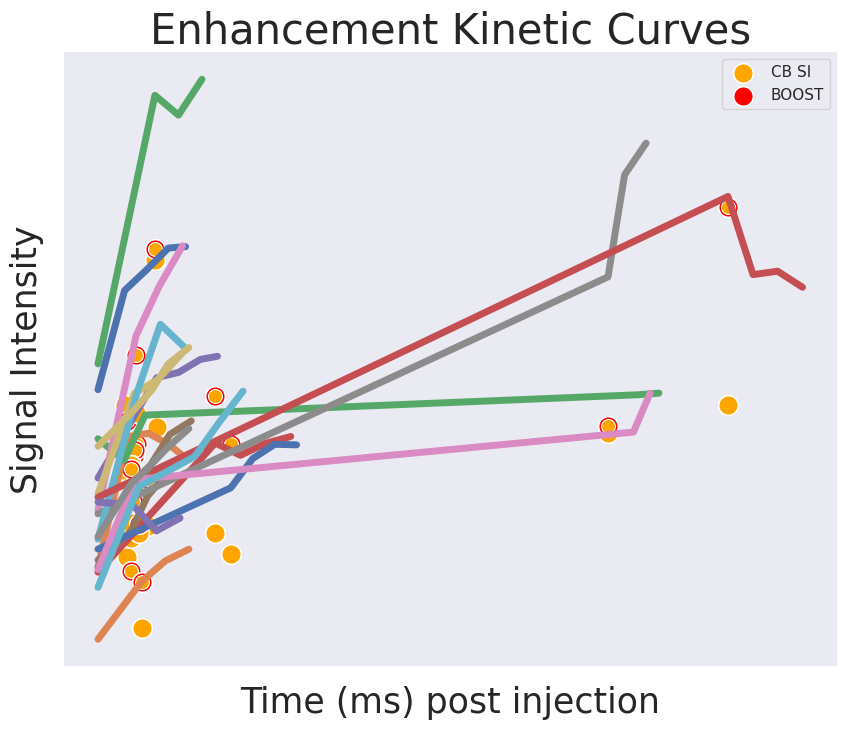

In [32]:
df_kin = pd.read_csv('/home/srivathsa/projects/studies/gad/breast/preprocess/kincurve_info.csv', index_col=0)
npy_path = '/home/srivathsa/projects/studies/gad/breast/preprocess/data_all_acqs'
ldose_path = '/home/srivathsa/projects/studies/gad/breast/preprocess/data_ldose'
gad_path = '/home/srivathsa/projects/studies/gad/breast/data/gad_results'
boost_path = '/home/srivathsa/projects/studies/gad/breast/data/boost_results'

boost_quant_rows = []
cases = list(df_kin['case'])
for cnum in cases:
    disp_img, boost_metrics = plot_kinetic_curves(
        df_kin, cnum, npy_path, gad_path, boost_path, sc_ref_gad=8.5, sc_ref_boost=8,
        show_boost=True, invert_slices=True
    )
    boost_metrics['case'] = cnum
    boost_quant_rows.append(boost_metrics)

In [34]:
df_boost_quant = pd.DataFrame(boost_quant_rows)
df_boost_quant.aggregate(['mean', 'std'])

,cnr_pre,lbr_pre,cnr_post,lbr_post,cnr_boost,lbr_boost,cep_post,cep_boost
mean,2.480951,6.736572,3.569198,9.443618,3.761533,9.636610,0.653382,0.500397
std,0.919808,3.462945,1.354597,5.087069,1.287808,5.373166,0.431153,0.522883


(-0.5, 197.5, 59.5, -0.5)

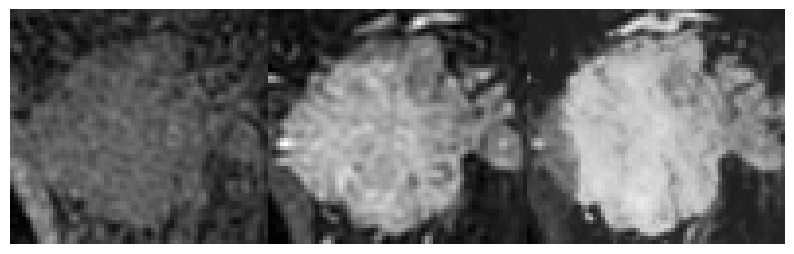

In [21]:
plt.imshow(disp_img, cmap='gray')
plt.axis('off')

### PSNR & SSIM quantitative metrics

In [2]:
gad_path = '/home/srivathsa/projects/studies/gad/breast/data/gad_results'
data_path = '/home/srivathsa/projects/studies/gad/breast/data'
cases = sorted([c.split('/')[-1] for c in glob('{}/*'.format(gad_path))])
pmap = sitk.GetDefaultParameterMap('affine')

metric_rows = []

for cnum in cases:
    all_sers = sorted([ser for ser in glob('{}/{}/*'.format(gad_path, cnum))])
    for ser in all_sers:
        gad_sitk = dcm_to_sitk(ser)
        side = ser.split('/')[-1].split('_')[-1]
        
        case_str = '{}_{}'.format(cnum, side[0])
        ref_path = [ser for ser in glob('{}/{}/*'.format(data_path, case_str, side[0])) if 'ACQ_2' in ser][0]
        ref_sitk = dcm_to_sitk(ref_path)
        
        ref_npy = sitk.GetArrayFromImage(ref_sitk)
        gad_npy = sitk.GetArrayFromImage(gad_sitk)
        gad_npy, _ = register_im(ref_npy, gad_npy, param_map=pmap, ref_fixed=ref_sitk, ref_moving=gad_sitk)
        
        ref_npy = resize_and_scale(ref_npy, scale_ref=11.69)
        gad_npy = resize_and_scale(gad_npy, scale_ref=11.69)
        
        metric_rows.append({
            'case': case_str,
            'psnr': sumetrics.psnr(ref_npy, gad_npy),
            'ssim': sumetrics.ssim(ref_npy, gad_npy)
        })

image registration
Installing all components.
InstallingComponents was successful.

ELASTIX version: 5.000
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
  The default value "true" is used instead.

  From elastix 4.8 it defaults to true!
This may change the behavior of your registrations considerably.

Command line options from TransformBase:
-t0       unspecified, so no initial transform used

Reading images...
Reading images took 0 ms.

  A default pyramid schedule is used.
  A default pyramid schedule is used.
  The default value "false" is used instead.
  The default value "GeometricalCenter" is used instead.
Transform parameters are initialized as: [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
InitializeTransform took 0.00s
Scales are estimated automatically.
Scales for transform parameters are: [1902.44140625, 1902.44140625, 5324.25, 190

56	-0.845658	22.713374	3.010824	0.006347	3.5
57	-0.841670	23.698831	2.944445	0.018467	3.6
58	-0.866026	24.646014	2.883346	0.025392	3.6
59	-0.881795	24.474374	2.894229	0.010447	3.6
60	-0.906103	25.122583	2.853554	0.012094	3.5
61	-0.890287	26.115340	2.793427	0.011442	3.7
62	-0.890365	27.106852	2.735853	0.017092	3.6
63	-0.881407	26.995741	2.742186	0.013705	3.5
64	-0.839663	27.995741	2.686219	0.006456	3.4
65	-0.853650	28.832047	2.641137	0.010700	3.8
66	-0.856858	28.994072	2.632578	0.008642	3.7
67	-0.877259	28.835596	2.640949	0.012837	3.7
68	-0.873024	28.681744	2.649127	0.020863	3.6
69	-0.861178	29.681744	2.596858	0.019565	3.6
70	-0.838887	29.510105	2.605682	0.013042	3.8
71	-0.838677	30.510105	2.555096	0.011098	3.9
72	-0.865374	30.577039	2.551780	0.013796	4.0
73	-0.881142	31.576978	2.503249	0.011354	3.7
74	-0.852995	32.002634	2.483146	0.026797	3.6
75	-0.820674	31.856048	2.490032	0.010153	3.7
76	-0.875375	31.684408	2.498145	0.015748	3.8
77	-0.882900	32.684405	2.451611	0.015091	3.6
78	-0.8440

239	-0.880998	111.859213	0.990622	0.010124	2.5
240	-0.865060	112.859211	0.983222	0.008963	2.5
241	-0.856656	113.784189	0.976474	0.013599	2.4
242	-0.877651	114.730695	0.969665	0.012594	2.4
243	-0.875531	115.719164	0.962654	0.007306	2.5
244	-0.864602	116.573388	0.956677	0.015737	2.6
245	-0.880493	116.401751	0.957872	0.013516	2.4
246	-0.884685	116.284467	0.958690	0.009492	2.4
247	-0.846772	117.284450	0.951758	0.008656	2.5
248	-0.869621	117.120636	0.952886	0.012614	2.5
249	-0.843631	116.951515	0.954055	0.012779	2.6
250	-0.857815	117.878963	0.947683	0.013629	2.6
251	-0.861787	117.714316	0.948808	0.011159	2.6
252	-0.869827	117.542886	0.949982	0.012774	2.4
253	-0.824802	117.371253	0.951161	0.008790	2.5
254	-0.849035	117.394331	0.951002	0.013950	2.5
255	-0.903418	117.222696	0.952183	0.017237	2.6
256	-0.886093	117.051061	0.953367	0.016875	2.6
257	-0.865161	116.879423	0.954553	0.011577	3.8
258	-0.892857	117.879099	0.947682	0.010806	3.5
259	-0.882892	117.769843	0.948428	0.007920	3.6
260	-0.894597

8	-0.769221	0.000000	2.414384	0.009886	2.6
9	-0.785430	0.186787	2.393098	0.022304	2.6
10	-0.782435	0.217873	2.389592	0.014368	2.5
11	-0.762956	0.000000	2.414384	0.017532	2.5
12	-0.725099	0.000000	2.414384	0.018705	2.6
13	-0.797379	0.000000	2.414384	0.014996	2.5
14	-0.787404	0.000000	2.414384	0.026252	2.5
15	-0.757454	0.000000	2.414384	0.022784	2.4
16	-0.736916	0.703452	2.336129	0.017332	2.4
17	-0.779278	0.799820	2.325802	0.023471	2.5
18	-0.780936	1.575967	2.245842	0.028017	2.5
19	-0.790790	2.501908	2.157359	0.023044	2.6
20	-0.825048	3.426761	2.075677	0.021392	2.5
21	-0.782958	3.097524	2.104036	0.019449	2.5
22	-0.747725	3.692704	2.053321	0.016596	2.4
23	-0.767824	3.404180	2.077597	0.012990	2.6
24	-0.760010	4.044961	2.024442	0.020526	2.5
25	-0.787097	3.945334	2.032527	0.024408	2.5
26	-0.807546	4.083223	2.021353	0.024302	2.5
27	-0.753211	5.035689	1.947406	0.016764	2.4
28	-0.809968	5.350255	1.924158	0.017205	2.4
29	-0.765606	5.923539	1.883187	0.030572	2.6
30	-0.769004	6.629232	1.835088	0.0

195	-0.749095	38.447878	0.852883	0.011412	2.4
196	-0.758811	38.535588	0.851626	0.026279	2.5
197	-0.753102	38.349825	0.854292	0.017098	2.5
198	-0.763415	38.567222	0.851174	0.014133	2.5
199	-0.730942	38.294133	0.855094	0.013282	2.4
200	-0.790711	38.615575	0.850483	0.013967	2.3
201	-0.795221	38.643476	0.850086	0.015247	2.5
202	-0.779441	38.427948	0.853169	0.014053	2.4
203	-0.752027	38.742285	0.848680	0.015133	2.4
204	-0.740826	38.860548	0.847003	0.019293	2.4
205	-0.767441	39.501432	0.838031	0.018922	2.3
206	-0.761802	40.222479	0.828161	0.020554	2.3
207	-0.782708	40.205986	0.828384	0.016752	2.3
208	-0.761245	40.570712	0.823477	0.012892	2.5
209	-0.804741	41.027709	0.817410	0.021470	2.4
210	-0.773094	41.862175	0.806559	0.015342	2.5
211	-0.749877	42.476021	0.798759	0.016046	2.4
212	-0.775630	42.881424	0.793690	0.015801	2.3
213	-0.766221	43.314746	0.788343	0.020057	2.5
214	-0.768915	44.132945	0.778440	0.015307	2.5
215	-0.812343	44.010108	0.779910	0.015244	2.5
216	-0.742138	44.247442	0.777074	0

378	-0.776796	67.821977	0.570828	0.017202	3.4
379	-0.780313	68.517391	0.566393	0.017335	3.5
380	-0.755782	68.332319	0.567567	0.015322	3.6
381	-0.770762	68.409289	0.567078	0.009643	3.6
382	-0.770305	68.285992	0.567861	0.013873	3.5
383	-0.770493	68.607719	0.565822	0.011934	3.3
384	-0.807377	68.514097	0.566414	0.020750	3.4
385	-0.754676	68.451648	0.566810	0.020766	3.5
386	-0.756280	69.380479	0.560985	0.017354	3.4
387	-0.783079	69.061684	0.562970	0.012783	3.3
388	-0.774673	69.564806	0.559843	0.024038	3.3
389	-0.796444	70.209347	0.555887	0.022351	3.3
390	-0.785277	70.608743	0.553463	0.025984	3.7
391	-0.781436	70.294895	0.555366	0.028117	3.6
392	-0.749328	69.961608	0.557401	0.015455	3.6
393	-0.773897	69.814172	0.558306	0.027023	3.6
394	-0.770273	70.420662	0.554602	0.012295	3.6
395	-0.783644	71.116932	0.550410	0.010825	3.5
396	-0.764308	71.060105	0.550750	0.023159	3.5
397	-0.775418	71.620831	0.547415	0.012693	3.5
398	-0.782633	71.332560	0.549124	0.020725	3.6
399	-0.819183	71.081893	0.550619	0

99	-0.730494	29.389972	1.110686	0.027287	3.1
100	-0.728249	30.363422	1.089636	0.029789	3.0
101	-0.708932	30.973361	1.076849	0.019485	3.4
102	-0.701157	30.437926	1.088058	0.015900	3.2
103	-0.711193	31.180122	1.072582	0.027897	3.0
104	-0.731402	30.872094	1.078951	0.013242	3.1
105	-0.721994	31.375172	1.068587	0.012874	3.4
106	-0.725497	31.344360	1.069216	0.036945	3.2
107	-0.725039	31.150372	1.073194	0.017877	3.1
108	-0.693419	31.941762	1.057151	0.018939	3.0
109	-0.719283	32.361397	1.048838	0.018702	3.3
110	-0.727707	32.440558	1.047284	0.028430	3.4
111	-0.742999	31.931624	1.057354	0.034204	3.2
112	-0.723340	31.702977	1.061941	0.024667	3.3
113	-0.736317	32.637774	1.043433	0.019544	3.2
114	-0.716619	32.733981	1.041565	0.024191	3.2
115	-0.700378	32.523659	1.045658	0.022820	3.3
116	-0.691474	33.415849	1.028514	0.031773	3.2
117	-0.742123	32.872613	1.038885	0.032824	3.3
118	-0.703877	33.495896	1.027003	0.019310	3.3
119	-0.698249	32.983857	1.036744	0.018596	3.2
120	-0.737767	33.327008	1.030196	0.

319	-0.735959	54.670615	0.739619	0.034481	3.0
320	-0.727401	54.243566	0.743817	0.014512	3.3
321	-0.688301	54.406324	0.742212	0.024218	3.2
322	-0.730305	54.881196	0.737567	0.029145	3.2
323	-0.730248	54.337890	0.742886	0.025193	3.1
324	-0.724819	53.971921	0.746512	0.032208	3.3
325	-0.710997	53.441119	0.751835	0.023897	3.2
326	-0.755796	52.903569	0.757304	0.022560	3.1
327	-0.734776	53.582295	0.750412	0.041842	3.2
328	-0.755688	53.038752	0.755921	0.014654	3.4
329	-0.704641	52.511049	0.761347	0.019487	3.4
330	-0.695916	52.777372	0.758599	0.030763	3.4
331	-0.706333	52.942457	0.756905	0.017098	3.3
332	-0.688419	53.793526	0.748293	0.040679	3.3
333	-0.705727	54.541278	0.740886	0.020598	3.6
334	-0.717324	55.009943	0.736317	0.012167	3.2
335	-0.732353	54.831231	0.738053	0.024210	3.3
336	-0.733544	54.470355	0.741582	0.014636	3.3
337	-0.736279	54.923830	0.737153	0.016705	3.3
338	-0.712566	54.670820	0.739617	0.014292	3.3
339	-0.691680	55.058470	0.735848	0.028752	3.2
340	-0.692728	55.965867	0.727172	0

45	-0.598866	21.243835	1.898379	0.021073	3.3
46	-0.649100	22.243564	1.854491	0.020757	3.1
47	-0.628801	21.916303	1.868633	0.015311	3.5
48	-0.604747	22.545903	1.841616	0.017322	3.4
49	-0.625576	22.333965	1.850623	0.019207	3.2
50	-0.633039	22.002296	1.864896	0.025836	3.0
51	-0.646011	22.996992	1.822734	0.013542	3.0
52	-0.604847	22.665642	1.836566	0.014616	3.3
53	-0.617751	22.426500	1.846679	0.021871	3.3
54	-0.618771	23.388621	1.806653	0.025480	3.2
55	-0.607648	24.380569	1.767162	0.020562	3.2
56	-0.617858	24.047826	1.780215	0.017169	3.2
57	-0.626230	24.106072	1.777916	0.021910	3.4
58	-0.608014	23.774015	1.791102	0.019954	3.5
59	-0.617239	24.324174	1.769361	0.023869	3.3
60	-0.620994	25.324039	1.731171	0.018845	3.2
61	-0.616737	24.994591	1.743571	0.023823	3.4
62	-0.622364	25.988041	1.706707	0.016067	3.4
63	-0.634795	25.655479	1.718873	0.022528	3.3
64	-0.618515	26.554382	1.686381	0.020601	3.3
65	-0.572937	26.222694	1.698226	0.014390	3.4
66	-0.637300	25.900314	1.709899	0.014226	3.3
67	-0.6508

250	-0.622235	97.469065	0.676926	0.013554	2.3
251	-0.635561	97.692743	0.675651	0.014342	2.4
252	-0.628877	97.800780	0.675036	0.012875	2.3
253	-0.637297	97.470670	0.676917	0.019997	2.3
254	-0.640940	97.166030	0.678662	0.028317	2.4
255	-0.605384	98.165921	0.672968	0.019265	2.4
256	-0.591841	98.450371	0.671365	0.012757	2.3
257	-0.619299	98.147292	0.673073	0.020097	2.2
258	-0.645139	97.826801	0.674888	0.022290	2.3
259	-0.612422	97.909941	0.674416	0.017672	3.5
260	-0.650455	98.909758	0.668793	0.015693	3.0
261	-0.607049	99.368495	0.666244	0.022322	3.3
262	-0.612993	100.313812	0.661053	0.021764	3.3
263	-0.651091	100.934017	0.657690	0.030713	3.1
264	-0.631280	100.601285	0.659490	0.021781	3.3
265	-0.601387	101.566086	0.654299	0.026150	3.3
266	-0.637428	102.565461	0.649007	0.023976	3.3
267	-0.593009	102.232715	0.650759	0.019667	3.3
268	-0.616132	102.941147	0.647040	0.021482	3.2
269	-0.622702	103.939998	0.641867	0.020049	3.3
270	-0.640971	103.607723	0.643578	0.031169	3.3
271	-0.636435	103.274977	

18	-0.801100	6.132474	9.347737	0.014594	2.2
19	-0.795130	7.132474	9.015461	0.007008	2.1
20	-0.780741	6.705640	9.154354	0.004948	2.3
21	-0.773012	6.308605	9.287447	0.011553	2.2
22	-0.776426	7.276008	8.969697	0.007560	2.1
23	-0.772303	8.240031	8.673973	0.008459	2.1
24	-0.733355	9.178673	8.404188	0.019110	2.6
25	-0.735058	10.178673	8.134638	0.012255	3.8
26	-0.779531	11.178673	7.881842	0.007435	3.3
27	-0.803984	10.751838	7.987797	0.009259	3.1
28	-0.804891	11.749457	7.744471	0.013117	3.0
29	-0.768755	12.749457	7.515002	0.011585	3.2
30	-0.810649	13.740419	7.300638	0.010726	3.2
31	-0.755832	14.709221	7.102570	0.012216	3.3
32	-0.776388	15.709119	6.909107	0.013971	2.9
33	-0.804596	16.709119	6.725886	0.007646	3.1
34	-0.791894	17.709114	6.552132	0.025596	3.1
35	-0.796693	18.709114	6.387129	0.021285	3.1
36	-0.787151	19.709114	6.230232	0.007483	3.3
37	-0.729681	20.709114	6.080859	0.013001	3.3
38	-0.783993	21.566920	5.958318	0.004820	3.3
39	-0.801403	21.246272	6.003541	0.007270	3.3
40	-0.771244	21.9

213	-0.803258	69.614672	2.798964	0.003743	2.7
214	-0.782170	69.202492	2.811754	0.005536	2.9
215	-0.747306	69.533798	2.801465	0.007482	2.8
216	-0.788658	70.531848	2.770918	0.005510	2.8
217	-0.794293	70.108299	2.783799	0.009872	2.8
218	-0.721446	69.681591	2.796899	0.009828	2.8
219	-0.776265	70.681591	2.766392	0.012335	2.9
220	-0.786773	70.254756	2.779332	0.010868	2.8
221	-0.743889	69.827921	2.792393	0.013548	2.8
222	-0.785336	69.401086	2.805577	0.012999	2.7
223	-0.759645	70.401086	2.774882	0.006522	2.8
224	-0.786016	70.247561	2.779551	0.007176	2.7
225	-0.819356	71.226045	2.750061	0.013360	2.9
226	-0.795504	72.226042	2.720562	0.009926	3.0
227	-0.777169	73.226042	2.691689	0.009994	3.0
228	-0.785150	74.226042	2.663423	0.008807	3.1
229	-0.741915	73.799207	2.675415	0.007403	3.2
230	-0.762321	74.683624	2.650686	0.006999	3.0
231	-0.836674	75.678779	2.623401	0.010911	3.1
232	-0.757172	75.254532	2.634964	0.015959	3.1
233	-0.811583	74.827883	2.646696	0.012692	3.1
234	-0.777541	74.401236	2.658532	0

29	-0.705884	12.698920	4.032035	0.012634	2.4
30	-0.689504	12.594784	4.044533	0.033218	2.2
31	-0.706913	13.594399	3.927665	0.021324	2.1
32	-0.666703	14.594399	3.817320	0.005320	2.2
33	-0.712129	14.082913	3.872974	0.018531	2.1
34	-0.728028	14.399531	3.838334	0.015134	2.2
35	-0.725441	15.252278	3.748046	0.011492	2.2
36	-0.739184	15.957435	3.676533	0.029153	3.3
37	-0.710281	16.749421	3.599399	0.014320	3.0
38	-0.680486	17.749421	3.506509	0.022193	2.9
39	-0.660820	17.135042	3.563001	0.012471	3.2
40	-0.722493	18.014571	3.482679	0.016238	3.7
41	-0.714376	19.007648	3.396231	0.006333	2.8
42	-0.711030	19.760991	3.333462	0.016037	3.0
43	-0.716737	19.529852	3.352472	0.019998	3.3
44	-0.712068	19.464466	3.357890	0.028227	3.2
45	-0.682902	20.464466	3.276907	0.016933	2.3
46	-0.707929	21.464465	3.199739	0.010442	2.2
47	-0.716528	21.168840	3.222171	0.014544	2.1
48	-0.648753	21.888390	3.168112	0.009486	2.1
49	-0.722278	21.396676	3.204855	0.013924	2.4
50	-0.721465	22.310597	3.137228	0.018368	2.4
51	-0.7550

242	-0.717984	85.954338	1.270404	0.017422	2.9
243	-0.704885	85.395223	1.277080	0.013237	2.8
244	-0.678140	86.395221	1.265189	0.013409	2.8
245	-0.716822	87.394319	1.253527	0.009955	2.9
246	-0.672819	87.137135	1.256508	0.013094	2.8
247	-0.719169	87.363707	1.253881	0.026732	2.7
248	-0.732948	86.748587	1.261039	0.018267	2.9
249	-0.716007	87.748587	1.249443	0.015324	2.9
250	-0.663483	87.469345	1.252660	0.011264	2.8
251	-0.689068	88.469141	1.241219	0.009999	2.9
252	-0.700412	88.625531	1.239449	0.018213	2.9
253	-0.684673	89.624814	1.228253	0.013371	2.8
254	-0.730243	90.624794	1.217249	0.006722	2.7
255	-0.718341	90.190743	1.222001	0.009744	2.9
256	-0.700648	89.860553	1.225641	0.008802	2.8
257	-0.716914	90.125970	1.222713	0.010751	2.7
258	-0.735084	90.897915	1.214278	0.009293	2.8
259	-0.709361	90.353657	1.220213	0.010532	3.1
260	-0.713166	90.473917	1.218897	0.011213	3.1
261	-0.709726	91.418327	1.208657	0.013555	3.0
262	-0.696325	90.808384	1.215251	0.022086	3.1
263	-0.688748	91.723749	1.205382	0

49	-0.652958	26.125726	2.495142	0.023227	2.2
50	-0.666024	27.125726	2.443296	0.018757	2.2
51	-0.658749	28.125323	2.393580	0.016286	2.2
52	-0.628403	27.652983	2.416818	0.014369	2.3
53	-0.677038	28.368885	2.381771	0.033502	2.3
54	-0.660110	29.368885	2.334485	0.024732	2.1
55	-0.638095	30.368885	2.289039	0.014114	2.2
56	-0.629548	29.877828	2.311132	0.014535	2.1
57	-0.650185	30.628618	2.277524	0.013974	2.2
58	-0.698327	30.149492	2.298858	0.018700	2.1
59	-0.679129	31.149222	2.254787	0.010121	2.2
60	-0.660802	31.472701	2.240887	0.020565	2.2
61	-0.673455	31.001195	2.261206	0.024512	2.1
62	-0.683136	32.001195	2.218542	0.010676	2.1
63	-0.666674	31.759434	2.228708	0.019014	2.2
64	-0.653056	32.435004	2.200531	0.021702	2.2
65	-0.660623	32.912899	2.181025	0.019805	2.3
66	-0.645750	32.422030	2.201066	0.023483	2.1
67	-0.622319	33.421993	2.160623	0.018116	2.2
68	-0.677221	34.421805	2.121645	0.032087	2.2
69	-0.648556	35.421805	2.084042	0.012654	2.1
70	-0.666705	36.421789	2.047749	0.017107	2.2
71	-0.6557

257	-0.675369	110.545727	0.893875	0.010023	3.0
258	-0.702065	110.225752	0.896054	0.018320	2.8
259	-0.643364	110.198688	0.896239	0.016601	2.9
260	-0.623756	109.708648	0.899599	0.013915	2.9
261	-0.656204	109.219034	0.902982	0.032243	2.8
262	-0.638651	109.836890	0.898717	0.037374	2.8
263	-0.669434	109.344710	0.902111	0.016127	2.8
264	-0.654471	110.344695	0.895243	0.018530	2.9
265	-0.644500	111.246652	0.889137	0.025507	2.8
266	-0.647510	111.745533	0.885796	0.028987	2.8
267	-0.636390	111.253354	0.889092	0.015341	2.9
268	-0.655131	110.779497	0.892289	0.013451	2.9
269	-0.662534	110.428525	0.894672	0.012828	2.9
270	-0.701781	110.460050	0.894457	0.014223	2.8
271	-0.656767	111.165024	0.889686	0.023496	2.7
272	-0.647767	110.725553	0.892654	0.014654	3.1
273	-0.680440	111.711533	0.886022	0.021311	3.0
274	-0.659275	112.694593	0.879508	0.024802	3.0
275	-0.628507	113.694592	0.872978	0.008245	3.0
276	-0.648632	113.989146	0.871073	0.019128	3.0
277	-0.669379	114.982866	0.864707	0.015844	3.0
278	-0.712445

67	-0.598599	25.262745	2.538954	0.018128	2.3
68	-0.632874	24.708581	2.569736	0.018788	2.2
69	-0.608499	24.671341	2.571832	0.016001	2.2
70	-0.561566	25.597574	2.520711	0.027884	2.3
71	-0.618002	25.172087	2.543940	0.019958	2.1
72	-0.634291	26.058011	2.496047	0.021214	2.1
73	-0.604681	26.724484	2.461190	0.019087	2.1
74	-0.608233	26.727833	2.461017	0.034662	2.1
75	-0.581498	27.727833	2.410512	0.030267	2.3
76	-0.624698	28.727833	2.362037	0.029692	2.1
77	-0.612330	29.727658	2.315482	0.015072	2.1
78	-0.616756	30.727641	2.270720	0.035154	2.2
79	-0.628838	30.173483	2.295310	0.019932	2.1
80	-0.646795	30.956888	2.260701	0.027582	2.4
81	-0.609014	31.943687	2.218565	0.024783	3.2
82	-0.606519	32.943686	2.177437	0.018721	2.8
83	-0.615348	33.943686	2.137807	0.030364	2.9
84	-0.627087	34.943686	2.099594	0.016610	3.0
85	-0.615383	35.867584	2.065483	0.028835	3.0
86	-0.621592	35.317394	2.085661	0.020007	2.9
87	-0.603946	36.317381	2.049274	0.025332	3.2
88	-0.605042	37.007115	2.024907	0.035581	3.1
89	-0.6231

271	-0.599212	94.381072	1.018009	0.018506	3.1
272	-0.596355	95.347919	1.009550	0.017696	2.8
273	-0.635310	95.523556	1.008028	0.027510	2.9
274	-0.607684	94.969403	1.012845	0.024136	2.9
275	-0.630092	94.490060	1.017049	0.023187	2.8
276	-0.564643	93.935892	1.021952	0.024830	2.8
277	-0.637269	94.935892	1.013138	0.015958	2.9
278	-0.624603	95.935837	1.004474	0.021534	2.7
279	-0.586630	95.382466	1.009250	0.029012	2.8
280	-0.583829	94.828299	1.014079	0.024558	2.9
281	-0.630696	95.802020	1.005625	0.020185	2.7
282	-0.588412	96.802015	0.997088	0.019257	2.8
283	-0.589851	97.801264	0.988702	0.033135	3.0
284	-0.606054	98.801263	0.980449	0.021191	2.8
285	-0.612004	98.406826	0.983687	0.022351	2.7
286	-0.633139	97.852821	0.988273	0.013993	3.1
287	-0.573755	98.300143	0.984567	0.039424	3.1
288	-0.599159	99.299726	0.976386	0.025453	3.0
289	-0.631289	100.299726	0.968337	0.020506	3.1
290	-0.582032	99.749968	0.972746	0.015425	3.2
291	-0.656515	99.336408	0.976089	0.023851	3.2
292	-0.633263	99.939904	0.971218	

Initialization of all components (before registration) took: 2 ms.
Preparation of the image pyramids took: 257 ms.

Resolution: 0
  The default value "false" is used instead.
  The default value "true" is used instead.
Setting the fixed masks took: 0 ms.
Setting the moving masks took: 0 ms.
  The default value "1" is used instead.
  The default value "false" is used instead.
  The default value "32" is used instead.
  The default value "32" is used instead.
  The default value "32" is used instead.
  The default value "0.01" is used instead.
  The default value "0.01" is used instead.
  The default value "0" is used instead.
  The default value "3" is used instead.
  The default value "true" is used instead.
  The default value "false" is used instead.
  The default value "false" is used instead.
  The default value "20" is used instead.

  This functionality is known to cause problems (stack overflow) for large values.
  If elastix stops or segfaults for no obvious reason, reduce this

118	-0.809761	46.593082	1.212167	0.023296	3.2
119	-0.784367	46.308236	1.217297	0.018460	3.3
120	-0.832162	47.308234	1.199476	0.021033	3.1
121	-0.797055	47.023391	1.204499	0.016049	3.2
122	-0.841032	48.023388	1.187048	0.016405	3.1
123	-0.822758	49.023271	1.170098	0.023106	3.1
124	-0.781106	50.023270	1.153623	0.014300	3.2
125	-0.811475	51.013605	1.137759	0.019292	3.0
126	-0.792761	52.013561	1.122177	0.017084	3.2
127	-0.820613	52.758857	1.110838	0.012480	3.0
128	-0.806111	52.501441	1.114728	0.022606	3.1
129	-0.834305	52.216780	1.119062	0.011240	3.0
130	-0.810029	53.213613	1.104031	0.020755	3.2
131	-0.816936	54.211198	1.089387	0.011013	3.1
132	-0.843449	53.931017	1.093461	0.017661	3.2
133	-0.836965	54.611706	1.083617	0.023779	3.0
134	-0.818306	55.611642	1.069473	0.015745	3.3
135	-0.863252	56.611642	1.055694	0.022501	3.3
136	-0.773859	56.437898	1.058062	0.017324	3.3
137	-0.835331	57.368675	1.045496	0.013296	3.2
138	-0.812603	57.083962	1.049308	0.018734	3.3
139	-0.815538	57.541149	1.043200	0

306	-0.780252	115.625464	0.599699	0.016722	2.9
307	-0.791756	116.259757	0.596927	0.011587	2.9
308	-0.807516	117.251663	0.592645	0.013789	2.7
309	-0.823802	117.051460	0.593504	0.015783	2.9
310	-0.828852	116.777953	0.594682	0.019555	2.8
311	-0.786445	116.494257	0.595909	0.010288	2.9
312	-0.814040	116.809710	0.594545	0.020467	3.0
313	-0.808843	116.899979	0.594156	0.016114	2.9
314	-0.797718	117.203469	0.592851	0.012762	2.9
315	-0.818948	117.425432	0.591901	0.015649	2.7
316	-0.784766	118.284415	0.588250	0.032323	2.9
317	-0.811194	117.999589	0.589456	0.017027	2.8
318	-0.780885	117.714743	0.590666	0.011158	2.9
319	-0.841459	118.707899	0.586467	0.024107	2.8
320	-0.796130	119.626309	0.582637	0.025575	2.8
321	-0.795399	119.341465	0.583820	0.021407	3.0
322	-0.814311	119.056619	0.585007	0.017545	2.7
323	-0.810194	120.056619	0.580860	0.022986	2.9
324	-0.767907	119.772846	0.582031	0.010819	2.8
325	-0.815657	119.545909	0.582970	0.011688	2.9
326	-0.788896	119.287484	0.584044	0.015714	3.0
327	-0.843507

42	-0.649093	5.739316	1.149509	0.016010	3.3
43	-0.724024	5.139065	1.175906	0.024881	3.2
44	-0.720980	5.809876	1.146483	0.014731	3.3
45	-0.671061	5.837203	1.145316	0.028347	3.1
46	-0.699234	6.491616	1.118053	0.022861	3.3
47	-0.691744	5.910884	1.142180	0.009185	3.1
48	-0.668560	6.280637	1.126700	0.025167	3.3
49	-0.718367	6.538418	1.116153	0.024947	3.2
50	-0.697580	5.914559	1.142024	0.035060	3.4
51	-0.730026	6.898918	1.101730	0.032085	3.2
52	-0.776610	6.176287	1.131026	0.012437	3.3
53	-0.713366	6.905014	1.101490	0.038819	3.1
54	-0.695461	7.273243	1.087144	0.020911	3.2
55	-0.668704	8.223437	1.051796	0.038051	3.1
56	-0.665263	7.552197	1.076522	0.007521	3.5
57	-0.691532	7.494512	1.078702	0.018500	3.4
58	-0.672197	7.306562	1.085864	0.020717	3.4
59	-0.640968	7.506816	1.078236	0.028594	3.4
60	-0.676401	7.188094	1.090428	0.018264	3.4
61	-0.705815	7.709170	1.070636	0.025853	3.4
62	-0.661282	7.205839	1.089742	0.018263	3.3
63	-0.730108	7.107838	1.093541	0.016989	3.4
64	-0.708697	7.626486	1.073729	0

248	-0.733709	21.520476	0.722877	0.035849	3.1
249	-0.655433	22.486681	0.706816	0.016300	3.3
250	-0.666400	23.081270	0.697282	0.011081	3.3
251	-0.738673	23.332828	0.693326	0.023691	3.1
252	-0.697757	23.749530	0.686869	0.027522	3.2
253	-0.687129	24.724951	0.672217	0.020396	3.1
254	-0.723624	24.193501	0.680122	0.025402	3.2
255	-0.733123	23.858556	0.685200	0.019431	3.1
256	-0.676483	23.824374	0.685722	0.027885	3.2
257	-0.664970	24.477580	0.675873	0.022448	3.2
258	-0.705513	24.383708	0.677271	0.024119	3.1
259	-0.718371	24.633593	0.673563	0.018984	3.1
260	-0.679172	24.195251	0.680095	0.011472	3.0
261	-0.697293	24.492355	0.675654	0.021356	3.1
262	-0.652018	25.029433	0.667770	0.020544	3.2
263	-0.679416	24.620395	0.673757	0.015655	3.0
264	-0.701556	24.823895	0.670765	0.005576	3.3
265	-0.717241	24.836429	0.670582	0.022037	3.3
266	-0.680225	24.878077	0.669973	0.029450	3.3
267	-0.656802	25.438425	0.661889	0.021491	3.3
268	-0.680329	26.177706	0.651517	0.016945	3.3
269	-0.686447	26.925361	0.641353	0

38	-0.635374	11.670898	1.341583	0.017086	3.3
39	-0.638880	12.074627	1.325207	0.027117	3.4
40	-0.637883	12.752829	1.298579	0.043489	3.0
41	-0.646501	13.752800	1.261214	0.045911	3.4
42	-0.647489	14.752800	1.225938	0.035613	3.1
43	-0.646724	15.752800	1.192582	0.030849	3.3
44	-0.631104	16.740356	1.161375	0.021198	3.3
45	-0.669595	17.365355	1.142456	0.018118	3.0
46	-0.611272	17.845005	1.128349	0.021249	3.2
47	-0.641469	17.399569	1.141438	0.051571	3.2
48	-0.617367	18.398738	1.112490	0.044504	3.2
49	-0.593551	19.398738	1.084953	0.023556	3.1
50	-0.646955	18.915818	1.098079	0.026546	3.5
51	-0.596402	19.901514	1.071616	0.036888	3.5
52	-0.645726	20.901078	1.046052	0.026874	3.5
53	-0.665955	21.542903	1.030271	0.049954	3.4
54	-0.622134	21.060723	1.042082	0.021751	3.3
55	-0.607367	21.591450	1.029097	0.014413	3.3
56	-0.609735	21.953990	1.020411	0.032914	3.3
57	-0.608704	21.763525	1.024956	0.021031	3.4
58	-0.655139	21.843933	1.023032	0.025034	3.4
59	-0.644476	21.406299	1.033590	0.023393	3.2
60	-0.6445

236	-0.576559	56.726817	0.563907	0.032196	3.4
237	-0.666971	56.244729	0.567427	0.018771	3.5
238	-0.631846	57.233414	0.560256	0.037310	2.2
239	-0.629555	58.042970	0.554518	0.022128	2.3
240	-0.628850	58.741003	0.549663	0.022837	2.2
241	-0.660330	59.484442	0.544586	0.029796	2.4
242	-0.628529	60.302992	0.539103	0.024858	2.4
243	-0.646276	59.828297	0.542269	0.021534	2.3
244	-0.607778	59.921815	0.541643	0.023780	2.3
245	-0.680549	59.823031	0.542305	0.029620	2.2
246	-0.643821	59.627902	0.543617	0.022681	2.3
247	-0.632512	59.239015	0.546252	0.022263	2.2
248	-0.660761	59.786466	0.542550	0.017899	2.2
249	-0.625686	59.658362	0.543412	0.032649	2.3
250	-0.652322	59.954298	0.541425	0.016159	2.2
251	-0.604848	60.827375	0.535649	0.030233	2.3
252	-0.643470	60.433102	0.538242	0.030938	2.1
253	-0.626500	60.746772	0.536177	0.033196	2.3
254	-0.606773	60.382580	0.538576	0.019569	2.2
255	-0.628390	60.212511	0.539704	0.050832	2.3
256	-0.635745	61.156568	0.533502	0.027476	2.3
257	-0.657919	62.156463	0.527087	0

23	-0.599666	5.481213	1.226553	0.017121	2.5
24	-0.529045	5.208049	1.239337	0.026910	2.4
25	-0.591459	5.368478	1.231797	0.052410	2.5
26	-0.594184	6.362405	1.187052	0.017827	2.6
27	-0.591534	7.137020	1.154373	0.040204	2.5
28	-0.606569	6.627491	1.175662	0.026703	3.4
29	-0.622244	6.292348	1.190099	0.018408	3.4
30	-0.621149	6.732111	1.171227	0.046309	3.5
31	-0.607633	7.265566	1.149123	0.030145	3.5
32	-0.544579	7.507992	1.139351	0.022264	3.4
33	-0.600751	8.117901	1.115486	0.028792	3.5
34	-0.589822	7.775156	1.128772	0.052057	3.5
35	-0.565651	8.769167	1.091082	0.026685	3.5
36	-0.577923	9.768567	1.055642	0.027217	3.4
37	-0.607858	9.238925	1.074132	0.022356	3.5
38	-0.570266	8.887161	1.086774	0.022194	3.5
39	-0.585648	9.421858	1.067673	0.032430	3.6
40	-0.589934	9.801051	1.054529	0.027462	3.5
41	-0.585488	10.597923	1.027935	0.025188	3.6
42	-0.582977	10.067235	1.045494	0.032319	3.6
43	-0.566614	9.751878	1.056215	0.012879	3.4
44	-0.569749	9.519488	1.064258	0.032266	3.8
45	-0.553914	9.760841	1.055908

267	-0.580637	51.861662	0.445785	0.018431	2.6
268	-0.576142	51.601023	0.447385	0.034703	2.7
269	-0.596554	51.247586	0.449574	0.026417	2.6
270	-0.607026	51.930594	0.445363	0.036119	2.6
271	-0.592108	52.064308	0.444548	0.023598	2.6
272	-0.573664	51.707015	0.446733	0.015189	2.6
273	-0.593478	52.210836	0.443658	0.026187	2.7
274	-0.588275	52.047768	0.444649	0.020231	2.6
275	-0.559311	51.622499	0.447253	0.027671	2.6
276	-0.587325	51.856829	0.445814	0.030262	2.7
277	-0.596429	52.782940	0.440218	0.053418	2.7
278	-0.585796	52.236112	0.443505	0.017345	2.7
279	-0.598365	51.734010	0.446567	0.021805	2.7
280	-0.566685	52.032348	0.444743	0.015721	2.7
281	-0.608856	51.876866	0.445692	0.039279	2.7
282	-0.546701	51.511859	0.447935	0.026992	2.6
283	-0.579872	52.024828	0.444789	0.051847	2.7
284	-0.584907	51.746764	0.446489	0.011711	2.6
285	-0.607466	51.558874	0.447645	0.026698	2.7
286	-0.603375	51.497127	0.448026	0.040130	2.7
287	-0.574099	51.057325	0.450761	0.017845	2.6
288	-0.584183	51.988825	0.445008	0

Initialization of all components (before registration) took: 1 ms.
Preparation of the image pyramids took: 195 ms.

Resolution: 0
  The default value "false" is used instead.
  The default value "true" is used instead.
Setting the fixed masks took: 0 ms.
Setting the moving masks took: 0 ms.
  The default value "1" is used instead.
  The default value "false" is used instead.
  The default value "32" is used instead.
  The default value "32" is used instead.
  The default value "32" is used instead.
  The default value "0.01" is used instead.
  The default value "0.01" is used instead.
  The default value "0" is used instead.
  The default value "3" is used instead.
  The default value "true" is used instead.
  The default value "false" is used instead.
  The default value "false" is used instead.
  The default value "20" is used instead.

  This functionality is known to cause problems (stack overflow) for large values.
  If elastix stops or segfaults for no obvious reason, reduce this

114	-1.318253	35.596321	1.630601	0.011902	3.6
115	-1.301055	35.895480	1.622027	0.012402	3.5
116	-1.323000	35.787234	1.625119	0.009082	3.6
117	-1.310896	36.212649	1.613035	0.016529	3.6
118	-1.314879	36.211824	1.613059	0.023299	3.8
119	-1.293288	37.211796	1.585349	0.014705	3.7
120	-1.305474	37.260385	1.584027	0.007761	3.6
121	-1.273675	37.110608	1.588110	0.018350	3.5
122	-1.339003	37.543904	1.576356	0.015761	3.6
123	-1.329103	37.610105	1.574575	0.010658	3.6
124	-1.288449	37.461701	1.578572	0.022765	3.5
125	-1.299695	38.202263	1.558826	0.017699	3.5
126	-1.304543	39.202042	1.532939	0.012275	3.6
127	-1.358654	40.178051	1.508483	0.011006	3.5
128	-1.299682	40.617917	1.497714	0.013053	3.5
129	-1.327457	40.890492	1.491118	0.012803	3.5
130	-1.295191	40.791232	1.493513	0.008564	3.5
131	-1.276438	40.686794	1.496042	0.008292	3.6
132	-1.309887	40.603127	1.498074	0.009639	3.5
133	-1.312139	41.288332	1.481594	0.008979	3.5
134	-1.318750	41.204083	1.483601	0.007471	3.5
135	-1.316900	41.225687	1.483086	0

362	-1.266338	98.414356	0.772822	0.013346	2.3
363	-1.309233	98.465910	0.772488	0.011592	2.2
364	-1.293589	99.211869	0.767695	0.020064	2.2
365	-1.298720	99.098323	0.768421	0.011091	2.2
366	-1.287516	98.956035	0.769332	0.018521	2.3
367	-1.326997	99.678962	0.764723	0.014607	2.2
368	-1.308134	99.507830	0.765809	0.011097	2.1
369	-1.307660	100.317143	0.760701	0.011833	2.3
370	-1.317594	100.170331	0.761622	0.006774	2.2
371	-1.338335	100.180526	0.761558	0.015268	2.2
372	-1.313452	100.222210	0.761296	0.009232	2.2
373	-1.292921	100.131391	0.761867	0.018369	2.1
374	-1.305148	100.243911	0.761160	0.015476	2.3
375	-1.339893	100.189070	0.761505	0.014256	2.3
376	-1.286064	100.014714	0.762602	0.008079	2.2
377	-1.308115	99.848619	0.763650	0.016594	2.2
378	-1.312253	99.707987	0.764540	0.011808	2.3
379	-1.318860	100.438938	0.759938	0.017507	2.3
380	-1.281765	101.364874	0.754187	0.011823	2.2
381	-1.304902	101.336901	0.754360	0.008841	2.2
382	-1.286467	101.178612	0.755337	0.017417	2.3
383	-1.297617	101.0540

37	-1.132030	13.697119	1.826600	0.012564	2.3
38	-1.176329	13.551571	1.834295	0.016794	2.4
39	-1.165328	13.725732	1.825095	0.018763	2.5
40	-1.150911	13.425737	1.841000	0.017286	2.4
41	-1.163420	14.165151	1.802289	0.017806	2.4
42	-1.167075	13.868663	1.817614	0.023345	2.4
43	-1.170823	14.842441	1.768232	0.015453	2.5
44	-1.183899	14.670929	1.776734	0.025990	2.4
45	-1.132746	15.328783	1.744561	0.018516	2.3
46	-1.182648	16.128489	1.706985	0.006528	2.4
47	-1.178266	16.241401	1.701809	0.015618	2.3
48	-1.163167	16.237530	1.701986	0.015060	2.4
49	-1.184602	16.528124	1.688807	0.017906	2.4
50	-1.161394	16.317223	1.698352	0.032082	2.4
51	-1.183576	17.285686	1.655391	0.023953	2.3
52	-1.199781	17.979258	1.625936	0.016834	2.4
53	-1.194660	18.942921	1.586708	0.014977	2.5
54	-1.165404	19.058287	1.582139	0.017161	2.4
55	-1.163073	19.520768	1.564081	0.015191	2.4
56	-1.156362	19.255305	1.574395	0.015817	2.3
57	-1.152798	19.919812	1.548828	0.016962	2.5
58	-1.139399	20.187355	1.538768	0.013312	2.4
59	-1.1319

235	-1.170802	59.329532	0.788972	0.015220	3.4
236	-1.179151	60.060794	0.781855	0.023730	3.4
237	-1.173725	60.349958	0.779076	0.017842	3.4
238	-1.176169	60.964594	0.773233	0.016378	3.4
239	-1.196919	60.642238	0.776286	0.022392	3.5
240	-1.159986	61.392386	0.769219	0.026814	3.4
241	-1.193646	62.271676	0.761096	0.025104	3.5
242	-1.163601	62.649394	0.757660	0.016454	3.4
243	-1.192256	62.486591	0.759137	0.017624	3.4
244	-1.143225	62.980089	0.754676	0.018087	3.3
245	-1.192326	63.724556	0.748045	0.017503	3.5
246	-1.156835	63.703749	0.748229	0.017829	3.5
247	-1.197616	63.444500	0.750526	0.019943	3.4
248	-1.186728	64.056516	0.745125	0.022307	3.5
249	-1.150547	63.743047	0.747882	0.022359	3.3
250	-1.151133	64.570098	0.740653	0.017189	3.4
251	-1.183426	64.338842	0.742660	0.017358	3.5
252	-1.170531	64.096435	0.744776	0.012254	3.5
253	-1.156654	64.262814	0.743322	0.022673	3.5
254	-1.180865	64.055889	0.745131	0.022112	3.5
255	-1.147494	64.084879	0.744877	0.021505	3.4
256	-1.161520	63.746800	0.747848	0

31	-1.069690	11.030030	1.456092	0.025707	2.2
32	-1.066018	10.776674	1.467701	0.024024	2.2
33	-1.067592	11.235043	1.446831	0.024042	2.4
34	-1.033508	11.009310	1.457034	0.011614	2.4
35	-1.033679	11.010274	1.456991	0.023151	3.5
36	-1.028074	10.962723	1.459158	0.031428	3.6
37	-1.077157	11.918405	1.416796	0.029582	3.5
38	-1.061746	12.760423	1.381460	0.017726	3.5
39	-1.060699	13.282993	1.360402	0.027893	3.4
40	-1.044849	13.230345	1.362495	0.019560	3.7
41	-1.057960	12.941179	1.374103	0.035841	3.7
42	-1.049698	13.289306	1.360152	0.030535	3.5
43	-1.016492	14.222344	1.324122	0.029204	3.7
44	-1.043260	14.435131	1.316170	0.025924	3.6
45	-1.051404	15.307462	1.284548	0.025197	3.6
46	-1.041166	16.214440	1.253241	0.026807	3.7
47	-1.046708	16.605818	1.240198	0.029057	3.7
48	-1.043542	17.548622	1.209866	0.018169	3.5
49	-1.006656	17.693957	1.205322	0.028692	3.7
50	-1.036732	18.104415	1.192670	0.022852	3.5
51	-0.998958	18.729408	1.173908	0.026451	3.6
52	-1.025472	19.423596	1.153749	0.028670	3.6
53	-1.0478

263	-1.064615	66.669260	0.531984	0.031236	3.5
264	-1.025730	67.345359	0.527913	0.033277	3.5
265	-1.026340	67.216017	0.528687	0.019551	3.4
266	-1.082721	66.968094	0.530177	0.031656	3.4
267	-1.058644	66.750006	0.531495	0.027702	3.0
268	-1.064907	66.869344	0.530773	0.022818	3.1
269	-1.045851	66.664299	0.532014	0.022223	3.2
270	-1.052035	67.253634	0.528462	0.025555	3.5
271	-1.020206	67.186631	0.528863	0.024492	3.4
272	-1.026809	67.059714	0.529625	0.025024	3.4
273	-1.056580	67.032679	0.529788	0.016083	3.5
274	-1.016368	66.846159	0.530913	0.020769	3.4
275	-1.016650	66.711965	0.531725	0.023748	3.4
276	-1.025183	66.448561	0.533327	0.030788	3.1
277	-1.034480	67.362712	0.527809	0.029573	3.3
278	-1.053859	67.049958	0.529684	0.021912	3.3
279	-1.094469	67.855346	0.524883	0.019978	3.5
280	-1.026989	67.815669	0.525118	0.024992	3.5
281	-1.055087	67.860194	0.524854	0.021002	3.3
282	-1.055795	67.685689	0.525887	0.027698	3.4
283	-1.024604	67.394328	0.527621	0.032540	3.4
284	-1.037498	68.367249	0.521876	0

56	-0.907030	28.056320	1.108285	0.031602	3.6
57	-0.883490	28.368832	1.101269	0.054030	3.5
58	-0.892734	29.368829	1.079405	0.044328	3.6
59	-0.868246	29.331985	1.080196	0.034466	3.6
60	-0.870157	30.269813	1.060437	0.044972	3.5
61	-0.896666	30.588639	1.053883	0.035004	3.7
62	-0.881728	31.555776	1.034489	0.038440	3.5
63	-0.915824	31.266137	1.040222	0.031019	3.7
64	-0.907898	32.130420	1.023301	0.028789	3.7
65	-0.877022	33.047390	1.005939	0.046621	3.6
66	-0.896380	33.952624	0.989368	0.031117	3.7
67	-0.925022	34.950551	0.971722	0.038130	3.7
68	-0.914835	35.876690	0.955899	0.033986	3.5
69	-0.874994	36.766549	0.941174	0.028909	3.5
70	-0.896337	37.752771	0.925376	0.025178	3.5
71	-0.907414	37.404828	0.930889	0.019444	3.6
72	-0.919687	37.393274	0.931073	0.042982	3.5
73	-0.895560	38.166290	0.918908	0.032121	3.6
74	-0.899567	39.141931	0.904001	0.028990	3.5
75	-0.883084	40.106853	0.889726	0.036549	3.5
76	-0.895770	40.716683	0.880935	0.031211	3.5
77	-0.888014	41.330362	0.872262	0.035151	3.7
78	-0.8889

290	-0.873624	108.944221	0.418398	0.019382	2.2
291	-0.903213	108.898399	0.418545	0.034633	2.5
292	-0.904555	108.643586	0.419368	0.018912	2.4
293	-0.891183	108.305627	0.420464	0.055994	2.3
294	-0.889381	108.303161	0.420472	0.021363	2.3
295	-0.895765	108.319365	0.420420	0.028270	2.4
296	-0.888172	108.995323	0.418233	0.045344	2.4
297	-0.910509	109.947156	0.415193	0.026304	2.3
298	-0.888434	109.773168	0.415746	0.026740	2.2
299	-0.900767	110.042279	0.414892	0.026389	2.3
300	-0.878322	110.172486	0.414480	0.028958	2.5
301	-0.898398	109.819612	0.415598	0.026390	2.4
302	-0.894887	109.798393	0.415666	0.028877	2.3
303	-0.875024	109.449631	0.416777	0.033104	2.5
304	-0.918106	109.150702	0.417734	0.024124	2.4
305	-0.924678	109.702459	0.415971	0.023543	2.4
306	-0.899875	109.910708	0.415309	0.029510	2.3
307	-0.900987	110.156701	0.414530	0.033820	2.3
308	-0.937015	110.268202	0.414178	0.017521	2.4
309	-0.901094	110.690560	0.412850	0.031315	2.4
310	-0.899101	110.842325	0.412374	0.022219	2.3
311	-0.901484

  The default value "0" is used instead.
  The default value "192" is used instead.
  The default value "10" is used instead.
  The default value "true" is used instead.
  The default value "false" is used instead.
  The default value "1" is used instead.
  The default value "0.6836" is used instead.
  The default value "0" is used instead.
  The default value "1000" is used instead.
  The default value "0.1" is used instead.
Elastix initialization of all components (for this resolution) took: 0 ms.
  Computing the fixed image extrema took 1 ms.
  Computing the moving image extrema took 1 ms.
Initialization of AdvancedMattesMutualInformation metric took: 3 ms.
Starting automatic parameter estimation for AdaptiveStochasticGradientDescent ...
  The default value "Original" is used instead.
  Computing JacobianTerms ...
  Computing the Jacobian terms took 0.001011s
  NumberOfGradientMeasurements to estimate sigma_i: 3
  Sampling gradients ...
  Sampling the gradients took 0.012642s
Automa

183	-1.177075	40.879142	1.362029	0.016814	3.6
184	-1.185097	41.822676	1.341573	0.016079	3.6
185	-1.191840	42.795507	1.321115	0.015191	3.5
186	-1.198704	42.852026	1.319945	0.013100	3.5
187	-1.201100	42.955275	1.317815	0.027655	3.7
188	-1.206457	42.685538	1.323396	0.015146	3.7
189	-1.187840	42.633728	1.324474	0.014318	3.7
190	-1.189862	43.339441	1.309946	0.015753	3.7
191	-1.194201	43.738065	1.301880	0.017870	3.7
192	-1.189173	43.540923	1.305857	0.006709	3.7
193	-1.213803	44.046841	1.295700	0.016436	3.7
194	-1.188008	44.016902	1.296297	0.015373	3.8
195	-1.182976	44.939832	1.278153	0.013197	3.5
196	-1.193862	45.845137	1.260843	0.017579	3.5
197	-1.179443	45.638487	1.264753	0.010053	3.4
198	-1.192914	45.264545	1.271890	0.013487	3.5
199	-1.208497	45.277005	1.271651	0.013275	3.5
200	-1.174940	46.148320	1.255150	0.020094	3.5
201	-1.198483	47.117740	1.237287	0.016850	3.7
202	-1.163343	47.771974	1.225517	0.012000	3.4
203	-1.194885	47.444196	1.231386	0.018365	3.5
204	-1.194897	47.809121	1.224855	0

18	-1.053520	0.576321	3.630180	0.020298	2.4
19	-1.034082	0.265104	3.683308	0.015657	2.3
20	-1.050777	1.050122	3.552177	0.018893	2.4
21	-1.023696	0.691337	3.610931	0.025241	2.5
22	-1.030573	1.689001	3.452154	0.013906	2.5
23	-1.014810	1.821411	3.432125	0.023581	2.4
24	-1.036217	1.852065	3.427521	0.023538	5.0
25	-1.034946	2.003118	3.405013	0.020147	2.5
26	-1.047591	1.646418	3.458645	0.019107	2.3
27	-1.059849	2.026243	3.401594	0.019316	2.4
28	-1.037168	2.933424	3.272659	0.028178	2.3
29	-1.040885	3.913742	3.143884	0.022229	2.4
30	-1.045062	4.913645	3.022575	0.018490	2.3
31	-1.047158	5.834584	2.918843	0.024527	2.6
32	-1.043642	5.474156	2.958581	0.020769	2.8
33	-1.034547	6.473645	2.850948	0.020125	3.7
34	-1.026568	6.115172	2.888638	0.022662	3.6
35	-1.045385	7.050713	2.792297	0.022848	3.5
36	-1.048715	6.707392	2.826896	0.015792	3.6
37	-1.021326	7.644482	2.734416	0.013333	3.6
38	-1.045345	7.678969	2.731128	0.024684	3.5
39	-1.021229	7.323685	2.765386	0.014818	3.5
40	-1.035658	8.312149	2.672132	0

215	-1.070921	52.498915	1.065675	0.017080	3.5
216	-1.026481	53.457186	1.051959	0.024743	3.4
217	-1.030378	54.138016	1.042427	0.013649	3.5
218	-1.052167	54.545074	1.036810	0.012243	3.5
219	-1.062164	54.397970	1.038833	0.017273	3.4
220	-1.047496	54.049192	1.043661	0.016294	3.5
221	-1.043114	53.693664	1.048629	0.024464	3.4
222	-1.038516	54.690828	1.034814	0.019033	3.4
223	-1.021072	55.372608	1.025576	0.013995	3.4
224	-1.053907	55.842578	1.019304	0.014050	3.4
225	-1.053883	55.618147	1.022289	0.019379	3.4
226	-1.065655	55.423091	1.024899	0.014884	3.4
227	-1.024510	55.606604	1.022444	0.010808	3.5
228	-1.029718	55.348952	1.025894	0.028427	3.4
229	-1.036444	55.014536	1.030407	0.021845	3.4
230	-1.054285	56.013959	1.017035	0.018335	3.4
231	-1.037491	57.012992	1.004011	0.027928	3.5
232	-1.032303	58.010719	0.991333	0.021970	3.3
233	-1.041986	57.665760	0.995680	0.025654	3.4
234	-1.050540	57.402419	0.999024	0.016104	3.3
235	-1.024039	58.362785	0.986935	0.015182	3.3
236	-1.073788	58.603391	0.983952	0

395	-1.038279	83.636036	0.748556	0.015643	3.4
396	-1.023433	84.212313	0.744456	0.018567	3.3
397	-1.031047	84.226730	0.744354	0.017368	3.4
398	-1.025151	84.371525	0.743331	0.018260	3.4
399	-1.035426	84.402438	0.743113	0.018054	3.5
Time spent in resolution 1 (ITK initialization and iterating): 1.291 s.
Stopping condition: Maximum number of iterations has been reached.
Settings of AdaptiveStochasticGradientDescent in resolution 1:
( SP_a 78.325926 )
( SP_A 20.000000 )
( SP_alpha 1.000000 )
( SigmoidMax 1.000000 )
( SigmoidMin -0.360934 )
( SigmoidScale 0.000033 )


Resolution: 2
  The default value "false" is used instead.
  The default value "true" is used instead.
Setting the fixed masks took: 0 ms.
Setting the moving masks took: 0 ms.
  The default value "1" is used instead.
  The default value "false" is used instead.
  The default value "32" is used instead.
  The default value "32" is used instead.
  The default value "32" is used instead.
  The default value "0.01" is used instead.

120	-0.977428	45.663321	1.102585	0.031348	2.3
121	-0.953853	45.205629	1.110207	0.020797	2.2
122	-0.983487	45.943034	1.097978	0.028108	2.3
123	-0.964596	46.548663	1.088134	0.033506	2.2
124	-0.965339	47.548627	1.072260	0.030714	2.4
125	-0.985183	47.098688	1.079345	0.031372	2.2
126	-0.962868	47.737482	1.069314	0.023081	2.3
127	-0.971744	47.279810	1.076482	0.031799	2.2
128	-0.974761	48.279325	1.060951	0.027725	2.3
129	-0.975124	49.279317	1.045855	0.021709	2.4
130	-0.973950	48.910219	1.051377	0.021965	2.3
131	-0.968404	49.868155	1.037165	0.037486	2.2
132	-0.974760	50.865878	1.022766	0.024340	2.2
133	-0.969931	51.865872	1.008730	0.020414	2.4
134	-0.960625	52.864441	0.995093	0.033461	2.2
135	-0.976314	52.640880	0.998114	0.019930	2.4
136	-0.971038	52.314830	1.002552	0.019969	2.3
137	-0.961066	51.880962	1.008521	0.021026	2.3
138	-0.971116	51.429641	1.014805	0.026888	2.2
139	-0.965773	52.088860	1.005652	0.036769	2.3
140	-0.974459	53.088739	0.992080	0.031302	2.2
141	-0.956465	54.086018	0.978903	0

315	-0.955450	110.799197	0.557681	0.021705	3.4
316	-0.981628	110.343754	0.559615	0.034051	3.3
317	-0.971413	111.343655	0.555387	0.023915	3.3
318	-0.942005	110.932982	0.557116	0.020480	3.5
319	-0.976287	111.932216	0.552928	0.027641	3.1
320	-0.948026	111.491381	0.554768	0.020945	3.1
321	-0.965198	112.183623	0.551884	0.025940	3.2
322	-0.964735	111.727163	0.553782	0.033349	3.3
323	-0.962848	112.725791	0.549647	0.019074	3.3
324	-0.951209	112.443723	0.550809	0.016946	3.4
325	-0.939654	111.989403	0.552690	0.019237	3.4
326	-0.995150	112.782272	0.549415	0.030745	3.3
327	-0.956262	112.385522	0.551049	0.045625	3.3
328	-0.998659	111.929621	0.552939	0.033555	3.0
329	-0.967234	111.482219	0.554806	0.040058	3.2
330	-0.970195	112.374660	0.551094	0.033157	3.2
331	-0.948002	113.374660	0.546993	0.041630	3.2
332	-0.973887	112.916905	0.548862	0.020568	3.3
333	-0.979448	113.916903	0.544794	0.028914	3.5
334	-0.945281	114.915341	0.540792	0.027752	3.4
335	-0.954873	115.915330	0.536842	0.026657	3.3
336	-0.994440

41	-0.852283	16.071061	1.463726	0.037804	3.5
42	-0.870308	16.778486	1.436317	0.039497	3.5
43	-0.871465	16.119183	1.461828	0.043552	3.5
44	-0.867725	17.116632	1.423575	0.040995	3.5
45	-0.853481	18.115664	1.387216	0.028216	3.6
46	-0.880572	17.457355	1.410962	0.031144	3.5
47	-0.847205	18.452815	1.375361	0.031860	3.5
48	-0.842693	17.793346	1.398742	0.041634	3.6
49	-0.897893	17.237073	1.419091	0.029289	3.4
50	-0.854331	18.226251	1.383305	0.044360	3.6
51	-0.858965	17.568842	1.406884	0.030100	3.5
52	-0.867619	18.546953	1.372087	0.041650	3.5
53	-0.835367	17.896874	1.395019	0.035594	3.5
54	-0.833035	18.890622	1.360266	0.043395	3.5
55	-0.854311	19.088081	1.353566	0.036296	3.4
56	-0.833915	20.088075	1.320623	0.039748	3.4
57	-0.837545	19.569248	1.337512	0.017981	3.5
58	-0.854844	20.280327	1.314473	0.035541	3.4
59	-0.843273	19.955296	1.324905	0.044267	3.5
60	-0.868186	20.955270	1.293327	0.024265	3.5
61	-0.841092	21.402927	1.279673	0.039296	3.5
62	-0.856207	22.386380	1.250666	0.039287	3.4
63	-0.8615

251	-0.849541	65.203691	0.629461	0.022312	3.4
252	-0.862380	65.560805	0.626864	0.047861	3.6
253	-0.827638	65.056008	0.630541	0.033196	3.5
254	-0.848181	66.056005	0.623298	0.022526	3.3
255	-0.849781	65.409634	0.627961	0.032646	4.1
256	-0.842931	66.332812	0.621323	0.035524	3.4
257	-0.839473	65.677907	0.626017	0.021386	3.5
258	-0.864285	66.600275	0.619426	0.042331	3.6
259	-0.868397	66.153226	0.622603	0.030084	3.4
260	-0.862507	65.788904	0.625217	0.040936	3.4
261	-0.859761	66.788890	0.618095	0.041918	3.9
262	-0.853068	66.129657	0.622772	0.023743	3.4
263	-0.855867	67.126162	0.615729	0.033313	3.3
264	-0.864834	67.956723	0.609981	0.033790	3.6
265	-0.850905	68.953029	0.603225	0.047429	3.4
266	-0.855375	69.953027	0.596592	0.035275	3.4
267	-0.830309	70.658203	0.592002	0.026684	3.4
268	-0.832196	71.397574	0.587265	0.044138	3.4
269	-0.846343	70.741936	0.591462	0.033278	3.4
270	-0.827655	70.082696	0.595743	0.038436	3.3
271	-0.864362	71.014696	0.589709	0.041230	3.4
272	-0.873274	71.960835	0.583707	0

Initialization of all components (before registration) took: 2 ms.
Preparation of the image pyramids took: 199 ms.

Resolution: 0
  The default value "false" is used instead.
  The default value "true" is used instead.
Setting the fixed masks took: 0 ms.
Setting the moving masks took: 0 ms.
  The default value "1" is used instead.
  The default value "false" is used instead.
  The default value "32" is used instead.
  The default value "32" is used instead.
  The default value "32" is used instead.
  The default value "0.01" is used instead.
  The default value "0.01" is used instead.
  The default value "0" is used instead.
  The default value "3" is used instead.
  The default value "true" is used instead.
  The default value "false" is used instead.
  The default value "false" is used instead.
  The default value "20" is used instead.

  This functionality is known to cause problems (stack overflow) for large values.
  If elastix stops or segfaults for no obvious reason, reduce this

112	-0.975746	36.518667	2.497286	0.015140	3.3
113	-0.947173	37.396924	2.459728	0.008421	3.4
114	-1.006697	37.078766	2.473202	0.009723	3.4
115	-0.976164	37.816543	2.442179	0.008545	3.2
116	-0.978904	37.715508	2.446382	0.009228	3.4
117	-0.984717	38.209758	2.425961	0.009814	3.2
118	-0.957161	38.853400	2.399873	0.010747	3.3
119	-0.948049	39.844831	2.360768	0.011395	3.2
120	-0.969250	40.783138	2.324915	0.011585	3.1
121	-0.958341	41.712432	2.290464	0.011616	3.1
122	-1.003277	41.464153	2.299568	0.015967	3.5
123	-0.984003	42.441100	2.264156	0.019111	3.3
124	-0.970810	43.441100	2.229021	0.012671	3.3
125	-0.972080	44.385483	2.196826	0.008572	3.3
126	-0.988887	44.430629	2.195310	0.014032	3.3
127	-0.999532	45.422368	2.162533	0.013319	3.3
128	-0.993653	45.098584	2.173126	0.007714	3.3
129	-0.988088	44.781434	2.183603	0.012040	3.3
130	-0.981431	44.646800	2.188081	0.015448	3.3
131	-0.995541	44.322974	2.198928	0.012961	3.3
132	-0.984031	45.317219	2.165961	0.009452	3.3
133	-0.988234	44.995959	2.176505	0

338	-0.982586	100.951615	1.177849	0.009378	3.2
339	-1.001741	101.951464	1.168270	0.017006	3.2
340	-0.988181	101.627648	1.171355	0.007125	3.2
341	-0.989966	102.005309	1.167759	0.013881	3.2
342	-0.982573	101.955128	1.168235	0.009952	3.0
343	-1.010943	102.613720	1.162011	0.013404	3.2
344	-0.985824	103.589670	1.152909	0.016485	3.2
345	-0.997416	103.849027	1.150514	0.016030	3.2
346	-0.963245	103.525193	1.153506	0.010553	3.2
347	-0.981319	103.436111	1.154332	0.011900	3.1
348	-0.990885	104.433131	1.145156	0.010392	3.1
349	-0.984420	104.603954	1.143599	0.016986	3.2
350	-0.996289	105.603863	1.134567	0.017809	3.2
351	-0.970391	105.280029	1.137476	0.014815	3.2
352	-0.980707	106.279995	1.128540	0.007522	3.1
353	-0.974766	105.979832	1.131207	0.011773	3.2
354	-0.975922	106.596152	1.125743	0.011272	3.3
355	-0.989089	106.272896	1.128603	0.010038	3.2
356	-0.941913	105.993090	1.131089	0.012056	3.1
357	-0.974649	105.952785	1.131448	0.010260	3.1
358	-1.031423	106.914883	1.122938	0.014936	3.2
359	-0.964898

70	-0.843161	2.811195	2.054050	0.013025	3.3
71	-0.827314	2.444076	2.086215	0.012449	3.4
72	-0.847477	3.082452	2.030914	0.016178	3.3
73	-0.819487	2.866889	2.049257	0.017657	3.4
74	-0.807487	2.372288	2.092623	0.012388	3.3
75	-0.808001	2.852065	2.050530	0.011524	3.3
76	-0.820813	3.124753	2.027353	0.018110	3.4
77	-0.845857	3.377233	2.006355	0.006514	3.2
78	-0.852706	3.382031	2.005960	0.011648	3.3
79	-0.817420	3.405138	2.004061	0.015222	3.3
80	-0.791808	3.505539	1.995850	0.016423	3.5
81	-0.829899	4.276065	1.935008	0.010307	3.3
82	-0.811666	3.690293	1.980916	0.015954	3.3
83	-0.827617	3.285850	2.013905	0.012754	3.3
84	-0.796032	4.096626	1.948843	0.008701	3.3
85	-0.820418	3.919799	1.962672	0.010586	3.4
86	-0.770881	3.976686	1.958202	0.008314	3.4
87	-0.803861	4.103582	1.948303	0.016396	3.4
88	-0.813283	4.324695	1.931292	0.019033	3.2
89	-0.814661	4.966254	1.883575	0.008544	3.3
90	-0.800498	5.661174	1.834480	0.015048	3.3
91	-0.830060	5.920793	1.816788	0.007408	3.4
92	-0.841430	5.624393	1.837014	0

257	-0.805987	20.057305	1.191247	0.014861	3.2
258	-0.849436	20.836975	1.169047	0.016726	3.3
259	-0.825670	21.414247	1.153136	0.015833	3.2
260	-0.812422	21.195063	1.159126	0.015822	3.2
261	-0.831425	20.518002	1.178028	0.009992	3.2
262	-0.831226	20.131653	1.189094	0.012910	3.4
263	-0.809281	20.340690	1.183081	0.021997	3.2
264	-0.840317	19.874797	1.196566	0.013061	3.2
265	-0.825356	19.096057	1.219805	0.014450	3.2
266	-0.805612	19.957911	1.194138	0.011978	3.1
267	-0.782073	19.512530	1.207266	0.016644	3.3
268	-0.814574	18.931007	1.224847	0.011061	3.1
269	-0.843079	19.570026	1.205555	0.018106	3.2
270	-0.829934	19.991593	1.193157	0.014749	3.2
271	-0.822030	20.298512	1.184289	0.010678	3.3
272	-0.832346	20.960146	1.165615	0.010819	3.2
273	-0.786994	20.660722	1.173993	0.006408	3.2
274	-0.816470	20.423375	1.180719	0.015050	3.1
275	-0.829119	20.550774	1.177099	0.006535	3.3
276	-0.809784	20.489361	1.178842	0.027747	3.2
277	-0.807257	20.986796	1.164875	0.016239	3.3
278	-0.835561	21.909636	1.139823	0

55	-0.646540	26.181676	3.814071	0.019383	2.3
56	-0.646738	27.181676	3.734911	0.011282	2.3
57	-0.663851	26.556807	3.783985	0.010647	2.2
58	-0.683412	25.953203	3.832630	0.013983	2.7
59	-0.690297	25.328207	3.884335	0.013168	2.6
60	-0.679785	26.328163	3.802266	0.012791	2.4
61	-0.712512	25.839072	3.841969	0.030490	2.2
62	-0.671258	25.213895	3.893943	0.017245	2.4
63	-0.660856	26.213895	3.811468	0.014382	2.4
64	-0.651020	27.213894	3.732415	0.012349	2.4
65	-0.686943	26.669509	3.775039	0.015888	2.2
66	-0.668668	27.669508	3.697474	0.022687	2.3
67	-0.665176	27.044331	3.745588	0.019940	2.3
68	-0.660323	28.044331	3.669216	0.009378	2.2
69	-0.667288	29.044309	3.595898	0.013126	2.3
70	-0.666338	28.828243	3.611491	0.016887	2.2
71	-0.691411	29.445706	3.567286	0.020785	2.3
72	-0.653563	30.445706	3.497945	0.013504	2.4
73	-0.678291	31.445706	3.431249	0.019882	2.3
74	-0.680877	32.445706	3.367048	0.018323	2.3
75	-0.675143	31.820529	3.406900	0.019760	2.4
76	-0.660280	31.207681	3.446892	0.008773	2.4
77	-0.6471

271	-0.657765	93.729817	1.568505	0.007326	3.1
272	-0.684303	94.727333	1.554985	0.010795	2.9
273	-0.684807	94.729224	1.554959	0.018691	3.2
274	-0.651376	95.729224	1.541638	0.015596	3.2
275	-0.655513	95.498477	1.544692	0.015959	3.4
276	-0.663207	96.498477	1.531545	0.013847	3.2
277	-0.663837	97.405030	1.519819	0.014934	3.3
278	-0.687458	98.405029	1.507091	0.014551	3.3
279	-0.701771	99.405029	1.494574	0.012464	3.4
280	-0.659795	100.320213	1.483300	0.016468	3.4
281	-0.684260	99.699011	1.490934	0.018394	3.1
282	-0.649009	99.432014	1.494239	0.016470	2.9
283	-0.664562	98.810055	1.501996	0.026595	3.0
284	-0.683569	98.184878	1.509875	0.020415	3.2
285	-0.637325	99.174918	1.497436	0.017470	3.2
286	-0.679430	98.549741	1.505267	0.014024	3.2
287	-0.655620	99.549335	1.492785	0.025380	3.3
288	-0.666217	100.518694	1.480877	0.018053	2.8
289	-0.657749	101.394646	1.470279	0.008930	2.9
290	-0.665064	102.177325	1.460937	0.007646	2.8
291	-0.684355	102.354982	1.458832	0.013260	3.2
292	-0.660426	103.291172	1.44

  The default value "0" is used instead.
  The default value "192" is used instead.
  The default value "10" is used instead.
  The default value "true" is used instead.
  The default value "false" is used instead.
  The default value "1" is used instead.
  The default value "0.7031" is used instead.
  The default value "0" is used instead.
  The default value "1000" is used instead.
  The default value "0.1" is used instead.
Elastix initialization of all components (for this resolution) took: 0 ms.
  Computing the fixed image extrema took 4 ms.
  Computing the moving image extrema took 1 ms.
Initialization of AdvancedMattesMutualInformation metric took: 5 ms.
Starting automatic parameter estimation for AdaptiveStochasticGradientDescent ...
  The default value "Original" is used instead.
  Computing JacobianTerms ...
  Computing the Jacobian terms took 0.001038s
  NumberOfGradientMeasurements to estimate sigma_i: 3
  Sampling gradients ...
  Sampling the gradients took 0.012554s
Automa

141	-0.585161	50.504264	1.751149	0.030236	3.3
142	-0.571317	51.504264	1.726997	0.016161	3.4
143	-0.604162	50.931281	1.740753	0.021474	3.2
144	-0.586807	51.931279	1.716885	0.019130	3.3
145	-0.592842	51.358296	1.730480	0.021035	3.3
146	-0.613531	52.358247	1.706892	0.017686	3.3
147	-0.540263	51.785266	1.720329	0.018913	3.3
148	-0.578959	51.970561	1.715961	0.021186	3.3
149	-0.588687	52.969374	1.692790	0.018081	3.2
150	-0.578068	52.397010	1.705991	0.026879	3.3
151	-0.598753	53.396930	1.683062	0.028931	3.4
152	-0.588958	52.823947	1.696125	0.027850	3.4
153	-0.564430	53.823916	1.673457	0.018763	3.2
154	-0.566373	54.823338	1.651399	0.021120	3.2
155	-0.598346	54.250622	1.663968	0.026047	3.4
156	-0.578822	55.228184	1.642629	0.021900	3.3
157	-0.577878	55.560664	1.635495	0.018880	3.3
158	-0.569992	56.553089	1.614566	0.014963	3.3
159	-0.597258	57.552756	1.594019	0.010503	3.3
160	-0.590711	58.141982	1.582152	0.021561	3.2
161	-0.584483	57.598465	1.593092	0.010207	3.5
162	-0.600512	57.074931	1.603775	0

325	-0.588144	93.054746	1.097847	0.019986	3.3
326	-0.581151	92.484221	1.103366	0.025068	3.3
327	-0.579053	93.484220	1.093728	0.015507	3.2
328	-0.563243	94.386126	1.085179	0.021214	2.8
329	-0.574760	95.386078	1.075856	0.019409	2.9
330	-0.582815	95.374850	1.075959	0.016924	3.0
331	-0.570686	94.806679	1.081238	0.015544	3.2
332	-0.591107	95.791873	1.072118	0.019861	3.3
333	-0.579494	95.219266	1.077400	0.014587	3.3
334	-0.591839	95.989509	1.070306	0.010475	3.4
335	-0.599199	95.638706	1.073525	0.023857	3.4
336	-0.578001	95.095554	1.078548	0.019699	3.2
337	-0.548861	94.522571	1.083897	0.024963	3.3
338	-0.553444	93.950401	1.089293	0.017844	3.3
339	-0.563347	94.163086	1.087281	0.028503	3.6
340	-0.595081	93.590103	1.092718	0.015748	3.4
341	-0.598456	94.555691	1.083587	0.021811	3.3
342	-0.582138	93.983193	1.088982	0.023713	3.3
343	-0.599906	94.983193	1.079593	0.016644	3.3
344	-0.601795	94.411212	1.084943	0.034932	3.3
345	-0.572125	95.336531	1.076314	0.018283	3.2
346	-0.570630	94.764253	1.081635	0

  Computing the moving image extrema took 1 ms.
Initialization of AdvancedMattesMutualInformation metric took: 4 ms.
Starting automatic parameter estimation for AdaptiveStochasticGradientDescent ...
  The default value "Original" is used instead.
  Computing JacobianTerms ...
  Computing the Jacobian terms took 0.001036s
  NumberOfGradientMeasurements to estimate sigma_i: 3
  Sampling gradients ...
  Sampling the gradients took 0.012808s
Automatic parameter estimation took 0.01s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.696140	0.000000	6.430151	0.031208	19.8
1	-0.708653	0.000000	6.430151	0.033213	2.3
2	-0.698493	0.000000	6.430151	0.026943	2.6
3	-0.692211	0.000000	6.430151	0.017646	2.3
4	-0.684692	0.000000	6.430151	0.018641	2.3
5	-0.720254	0.000000	6.430151	0.021292	2.5
6	-0.712220	0.198604	6.369909	0.019982	2.5
7	-0.726337	0.070612	6.408602	0.017665	2.3
8	-0.709470	0.000000	6.430151	0.014892	2.3
9	-0.728276	0.000000	6.430151	0.015900	2.3
10	-0.731637	0.000000	6.4

251	-0.755601	83.624513	1.290646	0.014489	2.2
252	-0.736778	83.499124	1.292194	0.014706	2.2
253	-0.729131	84.499124	1.279946	0.009466	2.4
254	-0.750526	84.371132	1.281501	0.009728	2.3
255	-0.765056	84.247827	1.283002	0.009139	2.3
256	-0.757617	84.119874	1.284564	0.015885	2.2
257	-0.715134	85.115989	1.272505	0.008101	2.1
258	-0.731012	84.988095	1.274041	0.010865	2.4
259	-0.746658	85.988086	1.262133	0.005212	2.3
260	-0.753949	86.306905	1.258383	0.007270	2.3
261	-0.736010	86.764946	1.253034	0.009589	2.3
262	-0.751394	86.655300	1.254310	0.014681	2.2
263	-0.750116	86.527318	1.255803	0.014362	2.2
264	-0.732220	87.527318	1.244232	0.006670	2.8
265	-0.736948	87.406626	1.245617	0.007024	2.3
266	-0.705682	88.095058	1.237757	0.010315	2.3
267	-0.719478	88.610964	1.231931	0.011137	2.3
268	-0.724705	89.593651	1.220985	0.008741	2.3
269	-0.676272	90.455003	1.211549	0.007561	2.4
270	-0.734465	91.405227	1.201307	0.005123	2.3
271	-0.683632	91.376685	1.201612	0.009736	2.3
272	-0.719375	92.372845	1.191054	0

16	-0.639767	0.991039	5.876105	0.014305	2.4
17	-0.627497	1.990075	5.620758	0.009425	2.5
18	-0.660329	2.123257	5.588385	0.014187	2.4
19	-0.635767	1.871814	5.649821	0.019547	2.5
20	-0.686671	1.619847	5.712756	0.021606	2.4
21	-0.657699	2.619801	5.470904	0.015028	2.3
22	-0.624089	2.367828	5.529896	0.032285	2.3
23	-0.615840	3.367828	5.302962	0.036739	2.3
24	-0.601681	4.367828	5.093919	0.018565	2.2
25	-0.646484	5.367828	4.900732	0.026890	2.3
26	-0.688311	6.367828	4.721663	0.029627	2.3
27	-0.652950	7.367828	4.555219	0.020696	2.5
28	-0.675207	7.115854	4.596042	0.012586	2.4
29	-0.630086	6.887780	4.633630	0.014562	2.4
30	-0.617577	7.886681	4.473399	0.010508	2.3
31	-0.647591	8.872417	4.325785	0.018634	2.3
32	-0.639599	8.661997	4.356472	0.016727	2.3
33	-0.649144	8.410024	4.393796	0.012531	2.2
34	-0.641872	9.257224	4.270770	0.018345	2.3
35	-0.636035	9.006167	4.306503	0.007291	2.2
36	-0.670251	8.852583	4.328659	0.019452	2.2
37	-0.617871	8.605599	4.364771	0.020938	2.4
38	-0.574309	9.605599	4.222157	0

228	-0.630168	81.300520	1.263157	0.016158	3.2
229	-0.642899	82.270255	1.251296	0.015569	3.1
230	-0.617743	83.270255	1.239295	0.008341	3.2
231	-0.612567	83.971808	1.231013	0.012512	3.1
232	-0.625306	83.745348	1.233674	0.028217	3.2
233	-0.638968	84.745348	1.222008	0.017610	3.1
234	-0.621646	84.493848	1.224921	0.011556	3.1
235	-0.645882	85.492205	1.213438	0.012226	3.2
236	-0.644490	85.340592	1.215168	0.014246	3.1
237	-0.623845	86.337773	1.203879	0.010723	3.2
238	-0.652529	87.337770	1.192766	0.009579	3.1
239	-0.600839	87.728354	1.188482	0.008525	3.2
240	-0.637619	88.327729	1.181966	0.015365	3.2
241	-0.648481	89.303876	1.171506	0.014546	3.2
242	-0.659198	89.332085	1.171207	0.015405	3.2
243	-0.641105	89.312299	1.171417	0.009892	3.2
244	-0.612054	89.061288	1.174088	0.015440	3.1
245	-0.625675	90.059954	1.163531	0.019014	3.1
246	-0.639880	91.059954	1.153148	0.013282	3.1
247	-0.618124	91.978048	1.143777	0.020518	3.1
248	-0.675417	92.702351	1.136491	0.007886	3.1
249	-0.624261	92.775026	1.135765	0

19	-0.546473	3.697084	3.195681	0.018689	2.5
20	-0.584208	4.695729	3.071483	0.008546	2.4
21	-0.584413	4.308405	3.118490	0.022038	2.4
22	-0.551871	4.526174	3.091885	0.021696	2.5
23	-0.560838	5.526143	2.975329	0.020624	2.5
24	-0.573523	4.929943	3.043740	0.017652	2.4
25	-0.551310	5.647759	2.961750	0.021131	2.4
26	-0.545209	5.339489	2.996414	0.013356	2.3
27	-0.527823	6.251388	2.896146	0.020284	2.3
28	-0.575109	5.544394	2.973283	0.013959	2.2
29	-0.561889	5.239699	3.007809	0.013276	2.2
30	-0.539847	4.589973	3.084177	0.022086	2.4
31	-0.575997	5.189220	3.013607	0.018169	2.4
32	-0.551984	4.600696	3.082885	0.023603	2.4
33	-0.565885	5.600093	2.967058	0.008617	2.4
34	-0.575433	6.591794	2.860416	0.016001	2.4
35	-0.566022	7.303236	2.788515	0.029656	2.4
36	-0.549196	6.623586	2.857124	0.019099	2.3
37	-0.580529	7.623435	2.757321	0.008905	2.2
38	-0.569351	7.310255	2.787824	0.027921	2.3
39	-0.595133	6.597399	2.859835	0.025830	2.4
40	-0.557002	7.597399	2.759832	0.010814	2.2
41	-0.580424	8.570967	2.668969	0

278	-0.578546	59.950969	0.974961	0.020571	2.5
279	-0.600097	59.263746	0.983308	0.013762	2.4
280	-0.575317	58.778731	0.989286	0.014643	2.5
281	-0.562494	58.073912	0.998104	0.012648	2.3
282	-0.546009	58.175759	0.996820	0.012117	2.4
283	-0.605805	57.494912	1.005467	0.026404	2.3
284	-0.552430	58.484928	0.992943	0.015192	2.3
285	-0.511033	59.473513	0.980745	0.016085	2.3
286	-0.552956	59.601051	0.979193	0.014871	2.3
287	-0.522420	58.960395	0.987039	0.018710	2.5
288	-0.569966	59.865364	0.975993	0.020927	2.5
289	-0.578523	60.796478	0.964883	0.025903	3.0
290	-0.574251	61.793931	0.953258	0.015256	2.5
291	-0.571265	62.666994	0.943311	0.016565	2.5
292	-0.575780	63.604819	0.932855	0.014566	2.5
293	-0.532140	62.898657	0.940706	0.011278	2.5
294	-0.533278	62.664458	0.943340	0.018256	2.3
295	-0.561996	63.256762	0.936708	0.015623	2.3
296	-0.556705	64.254614	0.925745	0.013989	2.2
297	-0.546775	64.733632	0.920572	0.016517	2.2
298	-0.557116	64.258948	0.925698	0.015036	2.2
299	-0.581641	63.807975	0.930620	0

44	-0.487684	17.412514	2.718544	0.024208	2.4
45	-0.496536	18.228260	2.662012	0.020748	2.3
46	-0.530489	19.228256	2.595840	0.016771	2.4
47	-0.499444	18.557416	2.639862	0.020086	2.3
48	-0.508841	17.959380	2.680384	0.017174	2.3
49	-0.505156	18.730742	2.628345	0.020619	2.3
50	-0.518350	18.059902	2.673486	0.022549	2.4
51	-0.565606	19.059902	2.606749	0.025143	2.4
52	-0.504462	20.059902	2.543262	0.022711	2.4
53	-0.499420	21.059902	2.482795	0.018190	2.3
54	-0.487118	22.059902	2.425136	0.018803	2.3
55	-0.476775	23.059901	2.370094	0.030243	2.2
56	-0.528893	24.038829	2.318579	0.021465	2.3
57	-0.507323	25.038827	2.268218	0.029839	2.3
58	-0.529996	26.038827	2.219998	0.020435	2.2
59	-0.524456	27.038827	2.173785	0.033433	2.5
60	-0.488155	26.368108	2.204566	0.028598	2.2
61	-0.480552	27.368108	2.158987	0.024219	2.4
62	-0.509673	28.368036	2.115257	0.014753	2.4
63	-0.536084	27.720229	2.143383	0.017169	2.3
64	-0.519426	28.718789	2.100335	0.017797	2.3
65	-0.472622	28.286938	2.118738	0.027537	2.3
66	-0.5107

281	-0.540276	89.252229	0.947156	0.021516	3.2
282	-0.485249	90.225251	0.938870	0.021252	3.2
283	-0.514057	89.557550	0.944541	0.012582	3.3
284	-0.533102	88.899689	0.950195	0.028154	3.2
285	-0.511829	89.891132	0.941699	0.025944	3.2
286	-0.553154	89.220290	0.947431	0.029399	3.2
287	-0.512073	90.220121	0.938914	0.017271	3.3
288	-0.498821	89.549278	0.944611	0.020137	3.3
289	-0.533949	90.443317	0.937033	0.021823	3.2
290	-0.492795	89.848700	0.942060	0.022041	3.2
291	-0.506017	90.848000	0.933643	0.021924	3.2
292	-0.489922	91.237026	0.930407	0.017678	3.3
293	-0.512806	92.114299	0.923191	0.013632	3.2
294	-0.473940	92.977760	0.916197	0.023582	3.2
295	-0.465962	92.306941	0.921621	0.028450	3.2
296	-0.502840	91.636098	0.927110	0.016907	3.4
297	-0.530745	90.965254	0.932665	0.019842	3.3
298	-0.544976	90.294475	0.938286	0.023565	3.3
299	-0.528361	90.891358	0.933281	0.038101	3.3
300	-0.489901	90.221061	0.938906	0.020221	3.1
301	-0.479308	89.550266	0.944603	0.019941	3.0
302	-0.522545	90.550219	0.936135	0

  Sampling the gradients took 0.012590s
Automatic parameter estimation took 0.01s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.986135	0.000000	4.594460	0.048429	19.7
1	-0.994103	0.000000	4.594460	0.034050	2.2
2	-0.990189	0.000000	4.594460	0.023780	4.0
3	-1.004331	0.000000	4.594460	0.016054	3.4
4	-1.037650	0.000000	4.594460	0.021628	3.5
5	-1.026576	0.000000	4.594460	0.021176	3.2
6	-1.008525	0.000000	4.594460	0.016662	3.6
7	-1.026170	0.000000	4.594460	0.015579	3.8
8	-0.988369	0.000000	4.594460	0.012453	4.3
9	-1.043995	0.000000	4.594460	0.010982	3.0
10	-1.019417	0.000000	4.594460	0.012189	2.6
11	-1.019551	0.000000	4.594460	0.016260	2.5
12	-0.987305	0.000000	4.594460	0.014069	2.6
13	-1.021158	0.000000	4.594460	0.013101	2.6
14	-0.998577	0.000000	4.594460	0.017207	2.5
15	-1.028719	0.999810	4.385659	0.007620	2.5
16	-1.020128	0.971155	4.391379	0.010897	2.3
17	-1.023940	1.784376	4.234642	0.012530	2.3
18	-1.011856	2.710042	4.069317	0.010699	2.4
19	-1.018120	3.477126	3.941789	

232	-0.985143	86.192237	0.900099	0.015103	3.5
233	-1.011976	86.101205	0.900864	0.015033	3.5
234	-1.024286	87.101205	0.892531	0.011641	3.4
235	-1.020964	87.021042	0.893193	0.015958	3.6
236	-1.009649	87.568163	0.888692	0.017405	3.5
237	-0.981027	87.477134	0.889438	0.010462	3.6
238	-1.044390	87.532733	0.888982	0.014245	3.5
239	-1.035165	87.441707	0.889728	0.011952	3.6
240	-1.016992	88.441706	0.881599	0.015002	3.6
241	-1.011442	89.441706	0.873616	0.009307	3.5
242	-1.019262	89.353625	0.874314	0.017071	3.6
243	-1.000362	89.262774	0.875034	0.009373	3.5
244	-0.981773	89.172876	0.875748	0.013499	3.5
245	-1.011602	90.172860	0.867871	0.012303	3.5
246	-1.026186	91.172851	0.860134	0.011671	3.6
247	-0.989464	91.082329	0.860829	0.019719	3.5
248	-1.004980	92.082329	0.853216	0.008069	3.3
249	-1.001939	92.003621	0.853810	0.011543	3.6
250	-0.999250	92.998683	0.846358	0.011235	3.5
251	-1.009291	92.907661	0.847034	0.010970	3.7
252	-0.983853	93.896467	0.839744	0.012219	3.4
253	-1.001724	94.895364	0.832507	0

13	-0.936392	0.326447	3.009945	0.025184	2.4
14	-0.931649	1.326248	2.875155	0.027742	2.3
15	-0.918690	2.240452	2.762056	0.011502	2.3
16	-0.900507	2.066905	2.782837	0.022695	2.3
17	-0.949862	1.873133	2.806412	0.019689	2.3
18	-0.956180	1.615596	2.838370	0.029980	2.3
19	-0.927958	2.596565	2.720372	0.026902	2.4
20	-0.956279	3.596535	2.609775	0.018357	2.3
21	-0.918361	3.616141	2.607697	0.018002	2.2
22	-0.919293	3.221727	2.650159	0.024645	2.3
23	-0.926173	4.068727	2.560618	0.016803	2.4
24	-0.909999	4.880185	2.480331	0.013938	2.2
25	-0.961819	4.973640	2.471407	0.017431	2.2
26	-0.945750	5.537667	2.418880	0.015333	2.4
27	-0.934166	6.368414	2.345457	0.018888	2.2
28	-0.936730	6.656163	2.321053	0.020348	2.3
29	-0.979270	7.628647	2.242210	0.014714	2.3
30	-0.925051	8.463054	2.178709	0.021833	2.4
31	-0.922415	8.113849	2.204842	0.029812	2.2
32	-0.929395	9.113625	2.131641	0.017570	2.2
33	-0.924537	10.085797	2.064976	0.032317	2.5
34	-0.946255	10.526584	2.036105	0.025507	2.3
35	-0.918032	11.526478	1.97351

278	-0.907731	61.302107	0.779949	0.022432	2.3
279	-0.918060	60.955455	0.783248	0.017022	2.2
280	-0.938984	60.568607	0.786962	0.022434	2.2
281	-0.899255	60.430571	0.788296	0.023080	2.3
282	-0.944071	61.408958	0.778938	0.018527	2.3
283	-0.901191	61.318297	0.779795	0.016388	2.2
284	-0.938535	60.942928	0.783368	0.025304	2.2
285	-0.959343	61.821618	0.775056	0.021955	2.3
286	-0.897617	62.743556	0.766524	0.024605	2.2
287	-0.883338	62.382297	0.769845	0.015297	2.2
288	-0.939140	63.279724	0.761647	0.027910	2.3
289	-0.909603	62.893283	0.765156	0.014760	2.2
290	-0.912759	62.581896	0.768006	0.011082	2.1
291	-0.971655	62.494369	0.768812	0.022652	2.2
292	-0.896326	62.361421	0.770038	0.013757	2.2
293	-0.943968	62.018730	0.773216	0.021510	2.2
294	-0.942062	61.667029	0.776506	0.022961	2.2
295	-0.906626	61.364791	0.779355	0.020309	2.3
296	-0.937573	62.340295	0.770233	0.021162	2.2
297	-0.913850	62.552385	0.768278	0.011168	2.2
298	-0.912970	62.239407	0.771166	0.017477	2.3
299	-0.920948	62.799316	0.766014	0

46	-0.839460	15.667845	1.216719	0.022473	2.3
47	-0.865119	15.430965	1.224631	0.028600	2.3
48	-0.863645	16.088059	1.202934	0.029634	2.3
49	-0.860379	15.744671	1.214175	0.041447	2.3
50	-0.850038	16.613198	1.186139	0.012934	2.3
51	-0.840875	17.061892	1.172156	0.019522	2.3
52	-0.820156	17.015897	1.173574	0.017259	2.3
53	-0.832890	17.247194	1.166477	0.021503	2.3
54	-0.815157	17.811183	1.149526	0.027273	2.3
55	-0.819440	18.305912	1.135058	0.030709	2.4
56	-0.850484	19.267038	1.107965	0.016838	2.3
57	-0.820980	19.328392	1.106280	0.024723	2.3
58	-0.857018	19.051390	1.113931	0.051593	2.3
59	-0.844204	19.984472	1.088570	0.034738	2.3
60	-0.820593	20.984408	1.062644	0.018897	2.3
61	-0.861228	21.735751	1.043961	0.019713	2.2
62	-0.857020	21.668438	1.045608	0.025032	2.2
63	-0.859050	21.361501	1.053184	0.028168	2.4
64	-0.822006	21.097080	1.059800	0.027441	2.3
65	-0.871939	20.814055	1.066973	0.029158	2.2
66	-0.845538	20.512079	1.074735	0.047559	2.3
67	-0.850201	21.510927	1.049482	0.038684	2.4
68	-0.8396

309	-0.828006	62.420199	0.534816	0.023909	2.2
310	-0.829759	62.938349	0.531515	0.025001	2.3
311	-0.862081	63.147926	0.530191	0.040509	2.3
312	-0.857114	62.730062	0.532837	0.020199	2.2
313	-0.835882	63.517045	0.527875	0.019942	2.2
314	-0.841860	63.133985	0.530279	0.022085	2.3
315	-0.810582	62.744677	0.532744	0.028277	2.3
316	-0.855000	62.569396	0.533861	0.036799	2.3
317	-0.869904	62.123142	0.536727	0.032043	2.3
318	-0.848346	63.095596	0.530521	0.020832	2.3
319	-0.868995	62.935123	0.531535	0.024930	2.3
320	-0.853649	62.936283	0.531528	0.014133	2.3
321	-0.826170	63.021193	0.530991	0.044192	2.3
322	-0.848861	62.910239	0.531693	0.027182	2.2
323	-0.868924	62.747309	0.532727	0.032227	2.3
324	-0.833692	63.650950	0.527040	0.025251	2.2
325	-0.879134	64.060543	0.524503	0.028004	2.1
326	-0.870557	64.626351	0.521037	0.032514	2.3
327	-0.899968	64.423814	0.522272	0.022094	2.2
328	-0.895141	65.198474	0.517578	0.026216	2.2
329	-0.852348	64.764749	0.520196	0.021853	2.3
330	-0.820816	64.395833	0.522443	0

75	-0.713575	24.502595	0.974153	0.026570	2.3
76	-0.733783	25.053117	0.962508	0.020989	2.4
77	-0.772755	25.233832	0.958746	0.040910	2.4
78	-0.773527	24.792668	0.967982	0.041836	2.3
79	-0.761447	25.780328	0.947546	0.033330	2.3
80	-0.756737	26.726631	0.928758	0.032327	2.3
81	-0.784344	26.045101	0.942213	0.016830	2.2
82	-0.731471	25.917055	0.944784	0.025844	2.4
83	-0.745090	26.363009	0.935888	0.032134	2.3
84	-0.729365	26.433330	0.934501	0.036950	2.2
85	-0.708493	25.751661	0.948127	0.038344	2.4
86	-0.777536	26.711126	0.929060	0.025689	2.3
87	-0.738879	26.034659	0.942422	0.040512	2.2
88	-0.755953	26.893043	0.925531	0.030830	2.4
89	-0.773977	27.892229	0.906616	0.045760	2.2
90	-0.773763	28.891798	0.888453	0.037877	2.7
91	-0.707560	28.517617	0.895166	0.044128	2.3
92	-0.796291	29.276352	0.881657	0.033250	2.3
93	-0.753580	30.275386	0.864479	0.021229	2.2
94	-0.750117	30.642835	0.858328	0.038767	2.2
95	-0.748291	29.990027	0.869317	0.027415	2.3
96	-0.710468	29.869892	0.871370	0.031697	2.3
97	-0.7504

339	-0.733290	85.589562	0.415861	0.042782	2.2
340	-0.769944	86.588440	0.412001	0.028976	2.3
341	-0.732436	87.586968	0.408212	0.035159	2.3
342	-0.757568	87.038278	0.410285	0.024032	2.2
343	-0.763464	86.469090	0.412458	0.019125	2.4
344	-0.741548	87.339293	0.409145	0.040673	2.3
345	-0.756200	88.081782	0.406360	0.030107	2.7
346	-0.756066	89.065826	0.402727	0.037876	2.3
347	-0.755872	90.065693	0.399102	0.034912	2.3
348	-0.765355	90.451577	0.397720	0.039263	2.2
349	-0.748445	91.448383	0.394194	0.019208	2.3
350	-0.746291	91.758848	0.393109	0.035807	2.3
351	-0.773119	92.378890	0.390959	0.047754	3.4
352	-0.736274	92.028285	0.392172	0.021760	3.3
353	-0.751537	91.654633	0.393472	0.035744	2.4
354	-0.775419	90.977404	0.395852	0.015830	2.4
355	-0.728754	91.283976	0.394771	0.021351	2.2
356	-0.738441	90.872382	0.396224	0.030227	2.2
357	-0.750588	91.455192	0.394170	0.023445	2.2
358	-0.769076	92.312845	0.391187	0.021217	2.1
359	-0.744761	92.117496	0.391862	0.028643	2.2
360	-0.774172	92.918108	0.389108	0

69	-1.134866	18.641127	2.994830	0.007737	2.3
70	-1.145083	18.591529	2.998582	0.012331	2.1
71	-1.113630	18.533869	3.002955	0.009493	2.2
72	-1.143903	18.464171	3.008259	0.007968	2.3
73	-1.161009	18.394218	3.013601	0.014579	2.3
74	-1.120101	18.323910	3.018989	0.009323	2.2
75	-1.141514	18.254709	3.024311	0.007566	2.3
76	-1.160689	18.225209	3.026585	0.010777	2.2
77	-1.125127	18.716495	2.989147	0.011875	2.3
78	-1.122228	19.552165	2.927549	0.008980	2.2
79	-1.161883	20.538178	2.858056	0.014270	2.3
80	-1.156277	21.538162	2.790869	0.009705	2.2
81	-1.136619	21.470846	2.795293	0.015366	2.2
82	-1.169318	22.470820	2.730992	0.011480	2.3
83	-1.132852	23.470818	2.669581	0.008733	2.3
84	-1.146596	23.412146	2.673108	0.012640	2.2
85	-1.145082	23.379882	2.675051	0.010848	2.3
86	-1.154014	23.309575	2.679295	0.017788	2.3
87	-1.110808	23.239266	2.683554	0.016169	2.2
88	-1.144167	23.173306	2.687561	0.008321	2.3
89	-1.133150	23.103032	2.691843	0.007632	2.3
90	-1.135489	23.033185	2.696113	0.009775	2.2
91	-1.1765

263	-1.138016	92.980734	1.041566	0.008098	3.2
264	-1.152808	93.027222	1.041141	0.010252	3.1
265	-1.185146	92.977561	1.041595	0.008038	3.3
266	-1.119795	92.907270	1.042238	0.013471	3.1
267	-1.133372	92.845704	1.042801	0.010002	3.0
268	-1.178895	92.775395	1.043446	0.016414	3.1
269	-1.148337	93.769007	1.034412	0.013091	3.1
270	-1.129489	94.769000	1.025477	0.009854	3.0
271	-1.107572	94.698706	1.026100	0.013127	3.2
272	-1.150021	94.628404	1.026724	0.009327	3.2
273	-1.163514	94.622803	1.026774	0.009740	3.2
274	-1.128366	94.819608	1.025029	0.012123	3.1
275	-1.176778	94.751255	1.025634	0.007446	3.2
276	-1.183624	95.155828	1.022062	0.010388	3.1
277	-1.175535	95.087689	1.022662	0.009588	3.0
278	-1.133428	95.263517	1.021115	0.013862	3.1
279	-1.131027	96.261071	1.012428	0.012788	3.0
280	-1.176227	97.261071	1.003867	0.008821	3.2
281	-1.170752	97.266436	1.003822	0.008524	3.1
282	-1.130105	98.266407	0.995406	0.011352	3.2
283	-1.149385	98.788005	0.991071	0.011351	3.3
284	-1.150906	98.736891	0.991494	0

55	-0.968513	17.472504	2.870198	0.023500	3.2
56	-0.948568	18.460653	2.798324	0.022465	3.3
57	-0.985645	19.460647	2.729163	0.013483	3.4
58	-0.986059	20.459433	2.663416	0.014024	3.3
59	-0.977827	21.402253	2.604194	0.014694	2.9
60	-1.016403	21.263035	2.612773	0.014331	3.1
61	-0.989483	22.262861	2.552390	0.014827	3.2
62	-0.992420	23.258726	2.494959	0.016890	2.9
63	-1.012909	23.958560	2.456122	0.013822	3.0
64	-1.004255	24.953362	2.402952	0.012450	3.2
65	-1.016671	24.816626	2.410123	0.010933	3.2
66	-1.024746	25.019833	2.399481	0.017501	3.1
67	-0.991679	25.260218	2.387012	0.016156	3.1
68	-1.043662	25.839583	2.357487	0.013911	3.2
69	-1.026595	26.839578	2.308208	0.014031	3.3
70	-0.991901	27.838579	2.260993	0.014872	3.2
71	-0.998601	27.699728	2.267440	0.018960	3.2
72	-1.018467	27.855229	2.260223	0.013557	3.3
73	-1.012325	28.853477	2.214965	0.005502	3.2
74	-1.019578	28.722135	2.220816	0.013723	3.1
75	-0.977321	29.236095	2.198095	0.019588	3.1
76	-1.007045	30.232795	2.155332	0.012759	3.3
77	-1.0130

247	-0.985964	96.691197	0.938249	0.010365	3.2
248	-1.030400	96.564228	0.939263	0.019384	3.1
249	-0.998263	97.480470	0.931999	0.020228	3.1
250	-0.983610	98.480419	0.924199	0.014012	3.1
251	-1.035584	98.341159	0.925278	0.013774	3.1
252	-1.001106	99.340956	0.917590	0.018737	3.1
253	-0.965778	99.260235	0.918206	0.014563	3.2
254	-1.000314	100.259959	0.910636	0.015205	3.1
255	-1.009605	100.135015	0.911575	0.017014	3.2
256	-0.990416	99.995919	0.912623	0.018842	3.1
257	-1.007981	100.506617	0.908788	0.015969	3.0
258	-1.028281	101.483885	0.901537	0.020174	3.2
259	-1.003299	102.462105	0.894393	0.020324	3.1
260	-0.969371	103.462105	0.887207	0.032002	3.2
261	-0.976251	103.322849	0.888201	0.012960	3.2
262	-0.967006	103.183588	0.889197	0.016574	3.1
263	-0.976983	103.884174	0.884209	0.013490	3.1
264	-1.008140	103.746871	0.885182	0.016539	3.1
265	-1.027512	103.607783	0.886170	0.014462	3.0
266	-0.974300	104.607783	0.879115	0.010294	3.1
267	-0.972094	104.474802	0.880047	0.020080	3.1
268	-1.000659	105.474

43	-0.885504	27.350300	2.251577	0.032027	2.4
44	-0.883122	28.350294	2.205953	0.020112	2.5
45	-0.909780	29.350291	2.162141	0.029887	2.4
46	-0.876603	30.350237	2.120038	0.016294	2.4
47	-0.895911	31.350229	2.079541	0.018224	2.3
48	-0.873954	31.119498	2.088747	0.025478	2.3
49	-0.862658	31.750135	2.063775	0.017757	2.3
50	-0.884140	31.472941	2.074678	0.031909	2.3
51	-0.881394	32.373348	2.039678	0.027398	2.3
52	-0.880944	32.085951	2.050720	0.017376	2.2
53	-0.907295	31.799554	2.061844	0.020651	2.1
54	-0.900992	32.799544	2.023520	0.026626	2.2
55	-0.856164	32.512149	2.034387	0.013180	2.2
56	-0.846870	33.512144	1.997068	0.025295	2.2
57	-0.864800	34.493917	1.961736	0.021018	2.3
58	-0.929057	35.453324	1.928397	0.013079	2.3
59	-0.891973	35.259706	1.935034	0.035614	2.4
60	-0.885136	35.597067	1.923500	0.026144	2.3
61	-0.918928	36.597067	1.890104	0.031247	2.4
62	-0.924254	36.309691	1.899582	0.028704	2.3
63	-0.897190	37.309691	1.867004	0.012639	2.4
64	-0.885992	37.063628	1.874916	0.018091	2.2
65	-0.8909

244	-0.863414	123.328210	0.754284	0.026669	3.1
245	-0.918705	123.868104	0.751473	0.023732	3.1
246	-0.910294	124.868102	0.746321	0.010038	3.1
247	-0.893899	125.812959	0.741518	0.015893	3.2
248	-0.926135	125.856913	0.741296	0.017063	3.1
249	-0.901713	125.749293	0.741840	0.033366	3.2
250	-0.938014	125.886039	0.741149	0.024237	3.1
251	-0.877722	126.696128	0.737084	0.014701	3.1
252	-0.885314	127.633124	0.732437	0.022286	3.2
253	-0.862872	128.632445	0.727546	0.021887	3.2
254	-0.884123	129.628474	0.722735	0.013367	3.1
255	-0.915149	129.341078	0.724116	0.021572	3.2
256	-0.915923	129.358162	0.724034	0.019195	3.3
257	-0.904109	130.015311	0.720883	0.015175	3.1
258	-0.954815	129.729112	0.722252	0.034363	3.2
259	-0.911566	130.525483	0.718456	0.024999	3.3
260	-0.886829	131.522109	0.713762	0.026502	3.2
261	-0.913880	132.521344	0.709116	0.020179	3.1
262	-0.861379	133.521111	0.704528	0.020149	3.2
263	-0.873118	134.520489	0.700001	0.028853	3.2
264	-0.884417	135.480487	0.695706	0.030784	3.2
265	-0.874328

40	-0.788747	23.609042	1.408430	0.030895	2.2
41	-0.793700	22.981252	1.428534	0.016432	2.2
42	-0.784953	22.803814	1.434321	0.036389	2.3
43	-0.770075	22.357547	1.449084	0.026578	2.3
44	-0.771467	23.346969	1.416753	0.019816	2.3
45	-0.755667	23.137959	1.423462	0.033007	2.3
46	-0.786495	24.039200	1.394978	0.019689	2.4
47	-0.790296	24.623801	1.377104	0.030221	2.4
48	-0.775906	24.282186	1.387493	0.025361	2.4
49	-0.808593	24.902551	1.368741	0.037691	2.3
50	-0.785782	24.276471	1.387668	0.028469	2.3
51	-0.808048	25.276159	1.357691	0.024472	2.2
52	-0.750657	26.211383	1.330796	0.024981	2.2
53	-0.787742	25.619017	1.347706	0.016295	2.2
54	-0.782408	25.733311	1.344410	0.040217	2.2
55	-0.780852	25.140167	1.361692	0.021567	2.3
56	-0.800429	24.534874	1.379793	0.023530	2.4
57	-0.792550	24.244950	1.388635	0.044005	2.4
58	-0.802257	23.641058	1.407420	0.034400	2.4
59	-0.777407	24.501626	1.380801	0.038861	2.4
60	-0.769334	25.346645	1.355626	0.040306	2.4
61	-0.786300	25.805298	1.342342	0.026385	2.3
62	-0.8001

243	-0.764013	75.759414	0.649329	0.047666	3.1
244	-0.824390	75.131524	0.653570	0.022067	3.0
245	-0.784649	75.077324	0.653939	0.038391	3.2
246	-0.799309	75.777573	0.649207	0.019404	3.3
247	-0.768203	75.325614	0.652253	0.028897	3.4
248	-0.769104	76.022093	0.647571	0.026367	3.2
249	-0.806348	76.894959	0.641797	0.036116	3.2
250	-0.771163	77.875578	0.635432	0.036128	3.1
251	-0.795176	77.248254	0.639489	0.030725	3.1
252	-0.769094	78.137429	0.633754	0.018480	3.1
253	-0.777539	77.859269	0.635537	0.017785	3.1
254	-0.788903	77.566020	0.637428	0.018243	3.1
255	-0.770835	77.972995	0.634807	0.021254	3.0
256	-0.779122	77.734667	0.636339	0.031763	3.0
257	-0.787867	78.717367	0.630068	0.038251	3.1
258	-0.793878	78.089476	0.634060	0.033078	3.0
259	-0.797669	77.549071	0.637537	0.020100	2.9
260	-0.825950	78.545010	0.631159	0.025715	3.1
261	-0.799802	78.380721	0.632202	0.024598	3.2
262	-0.782214	77.760364	0.636173	0.026152	3.1
263	-0.766018	77.947193	0.634972	0.029287	2.8
264	-0.800095	78.943835	0.628640	0

Initialization of all components (before registration) took: 2 ms.
Preparation of the image pyramids took: 207 ms.

Resolution: 0
  The default value "false" is used instead.
  The default value "true" is used instead.
Setting the fixed masks took: 0 ms.
Setting the moving masks took: 0 ms.
  The default value "1" is used instead.
  The default value "false" is used instead.
  The default value "32" is used instead.
  The default value "32" is used instead.
  The default value "32" is used instead.
  The default value "0.01" is used instead.
  The default value "0.01" is used instead.
  The default value "0" is used instead.
  The default value "3" is used instead.
  The default value "true" is used instead.
  The default value "false" is used instead.
  The default value "false" is used instead.
  The default value "20" is used instead.

  This functionality is known to cause problems (stack overflow) for large values.
  If elastix stops or segfaults for no obvious reason, reduce this

123	-0.790938	41.456651	2.405608	0.011158	3.3
124	-0.806702	42.267910	2.374762	0.011168	3.2
125	-0.800189	43.267815	2.337814	0.009382	3.2
126	-0.778283	43.181918	2.340943	0.010256	3.2
127	-0.793969	43.095958	2.344082	0.007860	3.2
128	-0.778806	43.155710	2.341899	0.005370	3.2
129	-0.852383	43.069910	2.345036	0.009740	3.3
130	-0.796849	43.028821	2.346540	0.005398	3.3
131	-0.794816	44.028682	2.310461	0.011386	3.2
132	-0.822225	44.107101	2.307678	0.008884	3.3
133	-0.834002	44.061286	2.309303	0.015337	3.3
134	-0.791875	43.975501	2.312352	0.016954	3.3
135	-0.808905	43.889541	2.315415	0.015835	3.2
136	-0.768979	44.889541	2.280274	0.008099	3.3
137	-0.827724	45.889541	2.246184	0.011671	3.2
138	-0.812486	46.634313	2.221450	0.014123	3.2
139	-0.797725	47.634313	2.189083	0.007779	3.3
140	-0.810115	48.634312	2.157646	0.010806	3.3
141	-0.808663	48.548358	2.160313	0.008475	3.2
142	-0.803450	48.462402	2.162986	0.011760	3.2
143	-0.803204	48.545427	2.160404	0.009719	3.2
144	-0.808786	48.459468	2.163078	0

315	-0.820155	119.378654	1.070292	0.009317	2.2
316	-0.776470	120.310029	1.063238	0.008200	2.4
317	-0.814368	120.601934	1.061046	0.012718	2.3
318	-0.785078	120.515974	1.061691	0.005685	2.3
319	-0.804426	121.409766	1.055027	0.004703	2.4
320	-0.778786	121.331271	1.055609	0.019456	2.2
321	-0.803231	122.331239	1.048245	0.009645	2.4
322	-0.812882	122.245279	1.048874	0.008768	2.3
323	-0.791331	122.159320	1.049504	0.010955	2.5
324	-0.763578	123.159320	1.042223	0.014360	2.3
325	-0.794570	123.073360	1.042845	0.009839	2.4
326	-0.781640	122.987400	1.043468	0.009120	2.3
327	-0.843337	123.987400	1.036271	0.018660	2.3
328	-0.816629	124.987400	1.029172	0.010697	2.2
329	-0.743986	125.987373	1.022171	0.008193	2.1
330	-0.756374	125.901453	1.022769	0.009879	2.3
331	-0.801451	126.901448	1.015854	0.008304	2.3
332	-0.759253	126.815490	1.016444	0.010430	2.2
333	-0.786738	126.729532	1.017036	0.015040	2.2
334	-0.826808	126.643593	1.017628	0.005966	2.4
335	-0.761301	126.557986	1.018218	0.013795	2.4
336	-0.834353

50	-0.660562	16.434724	4.102138	0.024660	3.2
51	-0.693181	17.434724	3.995408	0.015533	4.2
52	-0.735815	18.434724	3.894091	0.021048	2.3
53	-0.662071	18.294745	3.907963	0.018931	2.4
54	-0.629020	19.294745	3.810979	0.015584	2.4
55	-0.648584	20.294737	3.718692	0.018601	2.5
56	-0.637890	21.294737	3.630769	0.008858	2.4
57	-0.644148	22.293738	3.546989	0.011367	2.5
58	-0.640894	22.153760	3.558494	0.013015	2.3
59	-0.640752	22.544486	3.526564	0.017498	2.3
60	-0.669688	23.544486	3.447394	0.013937	2.2
61	-0.681972	24.544486	3.371701	0.010042	2.2
62	-0.700035	24.404507	3.382096	0.008618	2.4
63	-0.724013	24.274995	3.391771	0.013029	2.3
64	-0.678318	25.274893	3.318482	0.008113	2.3
65	-0.686118	25.134929	3.328550	0.014061	2.2
66	-0.658745	26.132399	3.258107	0.015547	2.4
67	-0.662160	27.132399	3.190417	0.014517	2.4
68	-0.680605	27.131207	3.190496	0.017766	2.4
69	-0.713250	28.131204	3.125558	0.018193	2.3
70	-0.674146	29.129506	3.063314	0.010245	2.2
71	-0.685162	29.835740	3.020757	0.016758	2.2
72	-0.6766

247	-0.660461	98.094535	1.289416	0.011027	3.2
248	-0.710568	97.954648	1.290932	0.008154	3.3
249	-0.651009	98.952478	1.280194	0.008660	3.0
250	-0.667086	98.812509	1.281689	0.015703	3.0
251	-0.718106	99.452557	1.274879	0.019357	3.0
252	-0.689818	100.452557	1.264382	0.006916	3.1
253	-0.702206	100.312580	1.265841	0.009555	3.1
254	-0.709077	100.581379	1.263042	0.013759	3.1
255	-0.693311	101.472352	1.253854	0.031263	3.2
256	-0.650257	102.472352	1.243699	0.011356	3.2
257	-0.672283	103.472352	1.233707	0.022245	2.9
258	-0.692254	103.332372	1.235096	0.006721	3.0
259	-0.706038	103.192539	1.236487	0.008534	3.0
260	-0.660313	103.082775	1.237580	0.022513	3.2
261	-0.678550	102.943361	1.238972	0.027905	3.4
262	-0.655585	103.943361	1.229056	0.012567	3.2
263	-0.675140	103.803382	1.230435	0.015432	3.3
264	-0.672620	104.803382	1.220654	0.014476	3.0
265	-0.709573	105.803382	1.211028	0.015999	3.0
266	-0.648799	105.663403	1.212366	0.012056	3.0
267	-0.640215	106.648212	1.203013	0.009792	3.2
268	-0.652977	107.

42	-0.561132	9.652094	4.718001	0.029803	3.4
43	-0.582441	10.652094	4.568943	0.016077	3.5
44	-0.544888	11.111262	4.503611	0.014836	3.3
45	-0.547669	10.426693	4.601713	0.017881	3.4
46	-0.541100	11.426681	4.459803	0.013239	3.3
47	-0.532454	10.743410	4.555800	0.034498	3.4
48	-0.551535	11.743110	4.416704	0.039121	3.4
49	-0.546526	12.743110	4.285812	0.021475	3.3
50	-0.580153	13.743110	4.162455	0.011820	3.4
51	-0.532944	14.743106	4.046000	0.017294	3.5
52	-0.534588	15.742657	3.935933	0.017571	3.4
53	-0.576703	16.527526	3.853614	0.024893	3.4
54	-0.512251	17.527526	3.753592	0.019959	3.3
55	-0.548264	18.527526	3.658631	0.023196	3.5
56	-0.526092	19.527517	3.568356	0.019389	3.3
57	-0.532645	20.527517	3.482429	0.019618	3.3
58	-0.561642	21.527508	3.400543	0.016036	3.2
59	-0.580211	22.527507	3.322419	0.017136	3.4
60	-0.524413	21.842958	3.375505	0.014384	3.3
61	-0.575615	21.617753	3.393342	0.012399	3.3
62	-0.584992	20.934586	3.448624	0.017943	3.3
63	-0.529187	21.934582	3.368302	0.013557	3.4
64	-0.53227

227	-0.579539	61.775909	1.747086	0.010570	3.3
228	-0.538680	62.294765	1.736203	0.011223	3.3
229	-0.540814	62.003502	1.742295	0.014257	3.2
230	-0.542802	62.177490	1.738651	0.015036	3.3
231	-0.560487	61.494697	1.753041	0.007219	3.3
232	-0.570576	60.928979	1.765146	0.020109	3.3
233	-0.573316	60.244690	1.780013	0.016464	3.3
234	-0.580461	59.573820	1.794834	0.013748	3.2
235	-0.534781	58.889248	1.810214	0.018112	3.2
236	-0.511562	58.373417	1.821978	0.018235	3.2
237	-0.575320	59.373380	1.799310	0.025326	3.2
238	-0.577483	60.373380	1.777198	0.024545	3.1
239	-0.534499	59.688807	1.792276	0.021814	3.3
240	-0.573964	60.688807	1.770336	0.013858	3.3
241	-0.556450	61.688792	1.748926	0.018773	3.3
242	-0.552808	62.169529	1.738817	0.011503	3.3
243	-0.578044	63.142764	1.718705	0.018139	3.3
244	-0.526945	63.024471	1.721125	0.026539	3.2
245	-0.587117	64.012953	1.701113	0.021452	3.2
246	-0.566729	65.012953	1.681335	0.018552	3.4
247	-0.559045	66.012953	1.662013	0.013855	3.2
248	-0.564304	67.004176	1.643293	0

26	-0.489005	8.966068	2.048872	0.022381	2.3
27	-0.471711	9.965661	1.982733	0.013797	2.3
28	-0.462168	10.700660	1.936762	0.023554	2.4
29	-0.490961	11.647652	1.880584	0.023614	2.3
30	-0.455658	12.647633	1.824694	0.040923	2.3
31	-0.463247	12.116239	1.853974	0.021846	2.3
32	-0.434748	13.116071	1.799640	0.011418	2.4
33	-0.433706	12.211470	1.848658	0.015467	2.7
34	-0.476087	13.110841	1.799916	0.020064	3.9
35	-0.419998	14.110794	1.748654	0.018209	3.2
36	-0.444569	13.202589	1.795088	0.026992	3.3
37	-0.447261	14.195417	1.744450	0.018502	3.3
38	-0.468050	15.195417	1.696255	0.021822	3.4
39	-0.456064	14.287240	1.739911	0.017731	3.3
40	-0.460943	15.282978	1.692161	0.010791	3.4
41	-0.439287	14.450672	1.731889	0.018576	3.3
42	-0.464640	13.720096	1.768332	0.023955	3.4
43	-0.461344	14.708149	1.719401	0.016370	3.2
44	-0.439491	15.708004	1.672568	0.035703	3.8
45	-0.437643	16.706825	1.628263	0.015063	3.5
46	-0.466288	17.706824	1.586197	0.011519	3.3
47	-0.446004	16.845789	1.622285	0.007791	3.3
48	-0.444077

213	-0.439971	46.774571	0.905895	0.007424	3.2
214	-0.434414	46.066364	0.915461	0.015038	3.1
215	-0.432143	46.045355	0.915748	0.019683	3.1
216	-0.449624	47.045307	0.902291	0.014778	3.1
217	-0.456555	48.039482	0.889298	0.014965	3.1
218	-0.448914	49.039198	0.876604	0.011412	3.1
219	-0.497318	50.027016	0.864413	0.020577	3.2
220	-0.439155	50.985289	0.852905	0.015893	3.1
221	-0.438694	50.198016	0.862336	0.012067	3.1
222	-0.458696	49.430317	0.871736	0.017116	3.2
223	-0.473737	48.585770	0.882316	0.026791	3.2
224	-0.453514	47.779061	0.892665	0.015147	3.2
225	-0.465306	48.456186	0.883962	0.017210	3.1
226	-0.407403	47.562569	0.895483	0.010479	3.3
227	-0.437005	48.559786	0.882646	0.013471	3.1
228	-0.490852	47.858818	0.891631	0.021073	3.2
229	-0.477542	48.858549	0.878871	0.022045	3.1
230	-0.454641	47.950541	0.890445	0.019727	3.1
231	-0.423893	48.949393	0.877729	0.027899	3.1
232	-0.464753	49.949393	0.865358	0.030931	3.2
233	-0.454720	50.949388	0.853331	0.014338	3.2
234	-0.437778	50.042070	0.864229	0


Final metric value  = -0.452017
Settings of AdaptiveStochasticGradientDescent for all resolutions:
( SP_a 150.246214 153.562408 144.616619 61.396642 )
( SP_A 20.000000 20.000000 20.000000 20.000000 )
( SP_alpha 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMax 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMin -0.085960 -0.139979 -0.684573 -0.908206 )
( SigmoidScale 0.000003 0.000005 0.000011 0.000021 )

registration done, 5.69 s
image registration
Time spent on saving the results, applying the final transform etc.: 413 ms.
ELASTIX version: 5.000
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
  The default value "true" is used instead.

  From elastix 4.8 it defaults to true!
This may change the behavior of your registrations considerably.

Command line options from TransformBase:
-t0       unspecified, so no initial transform used



74	-1.083308	18.264081	2.195414	0.008968	2.4
75	-1.092264	18.314372	2.192605	0.012008	2.4
76	-1.114717	19.303932	2.138772	0.011147	2.4
77	-1.115119	19.394611	2.133970	0.017801	2.3
78	-1.110334	19.323586	2.137729	0.014325	2.4
79	-1.129443	20.323586	2.085998	0.016353	2.4
80	-1.116312	21.323586	2.036711	0.015634	2.5
81	-1.107496	22.323468	1.989705	0.009291	2.4
82	-1.157292	22.253112	1.992941	0.011113	2.6
83	-1.111075	22.180397	1.996297	0.012412	2.6
84	-1.107971	22.107643	1.999666	0.014654	2.5
85	-1.120318	23.107643	1.954330	0.014365	2.5
86	-1.104022	23.055890	1.956626	0.015238	2.6
87	-1.110041	24.055713	1.913207	0.013289	2.6
88	-1.106146	25.055710	1.871666	0.007771	2.6
89	-1.113670	25.215091	1.865211	0.016157	2.6
90	-1.131994	25.148783	1.867891	0.013789	2.6
91	-1.116720	25.348664	1.859836	0.014707	2.6
92	-1.102900	26.343929	1.820738	0.010208	2.6
93	-1.151584	27.334354	1.783429	0.018601	2.6
94	-1.103506	28.327943	1.747507	0.009168	2.6
95	-1.107890	28.261025	1.749881	0.009419	2.5
96	-1.0991

309	-1.130658	100.076829	0.711952	0.010532	3.6
310	-1.124335	100.007521	0.712360	0.013891	3.5
311	-1.070940	101.007170	0.706523	0.014234	3.6
312	-1.135204	100.942584	0.706898	0.012562	3.5
313	-1.100315	100.888528	0.707211	0.009137	3.5
314	-1.086265	100.815729	0.707634	0.018438	3.3
315	-1.114627	100.742969	0.708057	0.012805	3.3
316	-1.083805	100.670170	0.708480	0.012294	3.2
317	-1.112928	100.597627	0.708903	0.015946	3.4
318	-1.096508	100.524831	0.709328	0.009389	3.3
319	-1.172264	101.524231	0.703542	0.014254	3.2
320	-1.120202	101.470327	0.703851	0.008566	3.3
321	-1.158612	102.418223	0.698446	0.014134	3.3
322	-1.123819	103.367711	0.693113	0.012159	3.3
323	-1.123312	104.333524	0.687772	0.014782	3.3
324	-1.124170	104.260725	0.688172	0.010889	3.2
325	-1.099108	104.187941	0.688572	0.012866	3.3
326	-1.131901	104.115142	0.688973	0.008455	3.2
327	-1.141029	105.066042	0.683776	0.014546	3.3
328	-1.145668	106.060145	0.678426	0.010857	3.3
329	-1.074251	106.696653	0.675044	0.014579	3.3
330	-1.106011

34	-0.966308	14.246517	2.197858	0.017077	2.7
35	-1.022141	15.174711	2.141464	0.018701	3.3
36	-1.029270	15.545653	2.119728	0.018357	3.7
37	-0.971805	16.545307	2.063290	0.011427	3.4
38	-0.972948	17.520263	2.011067	0.017327	3.4
39	-0.962729	18.330355	1.969645	0.015151	3.4
40	-0.993071	18.202587	1.976064	0.020176	3.3
41	-0.997788	18.258301	1.973260	0.017386	3.4
42	-0.960175	19.198724	1.927097	0.019469	3.6
43	-1.006963	20.198681	1.880323	0.020241	3.5
44	-1.013438	20.454823	1.868705	0.021174	3.5
45	-0.969529	20.326904	1.874489	0.022923	3.4
46	-1.001106	20.451135	1.868871	0.022013	3.4
47	-0.992277	21.445713	1.825080	0.018711	3.5
48	-1.004069	21.318134	1.830583	0.018880	3.4
49	-1.034511	21.258743	1.833155	0.023049	3.5
50	-0.967848	22.172354	1.794362	0.024570	3.5
51	-0.994072	22.044436	1.799695	0.015031	3.4
52	-0.992377	23.044434	1.758834	0.017202	3.5
53	-1.010702	22.918235	1.763888	0.021481	3.5
54	-0.997651	23.611982	1.736458	0.026439	3.4
55	-0.981861	24.475739	1.703476	0.020474	3.5
56	-0.9890

285	-0.958977	103.397357	0.622737	0.015021	3.1
286	-0.969802	103.426267	0.622592	0.013492	3.0
287	-1.004161	103.347489	0.622987	0.023720	3.0
288	-0.981233	104.315468	0.618175	0.011132	3.2
289	-1.018406	104.187754	0.618805	0.013939	3.3
290	-0.980733	104.988280	0.614873	0.013367	3.4
291	-0.970293	104.880615	0.615399	0.018209	3.3
292	-0.987289	105.766312	0.611100	0.016647	3.3
293	-0.966771	106.763616	0.606329	0.024590	3.4
294	-0.975421	106.636620	0.606933	0.017376	3.4
295	-0.991265	106.747179	0.606407	0.014573	3.5
296	-0.981675	106.632035	0.606954	0.014404	3.6
297	-1.013604	106.618803	0.607017	0.017567	3.7
298	-0.960692	106.945817	0.605466	0.019716	3.6
299	-0.969886	107.945816	0.600770	0.012976	3.5
300	-0.962015	108.166279	0.599745	0.016515	3.6
301	-1.009058	108.554790	0.597947	0.018578	3.6
302	-0.983977	108.562389	0.597911	0.017210	3.5
303	-0.963813	108.475840	0.598311	0.015256	3.4
304	-1.005770	108.354262	0.598873	0.023319	3.4
305	-0.977133	109.354140	0.594280	0.015526	3.4
306	-0.979382

14	-0.768490	7.684278	4.724666	0.017586	2.4
15	-0.767038	8.679977	4.566164	0.020656	2.4
16	-0.764621	8.412314	4.607717	0.024006	2.5
17	-0.792612	9.218889	4.484732	0.023148	2.5
18	-0.732773	10.218888	4.341078	0.023881	2.5
19	-0.784226	11.218886	4.206341	0.016370	2.3
20	-0.764162	10.951295	4.241569	0.016182	2.3
21	-0.750802	11.812924	4.130191	0.017114	2.3
22	-0.738134	11.719696	4.141959	0.015032	2.4
23	-0.756140	11.742084	4.139126	0.024372	2.5
24	-0.771786	12.742084	4.016457	0.021070	2.5
25	-0.741491	13.742074	3.900850	0.019498	2.4
26	-0.758566	14.742074	3.791711	0.022252	2.4
27	-0.756240	14.474422	3.820320	0.027626	2.5
28	-0.790575	15.173998	3.746438	0.014989	2.5
29	-0.789097	16.173998	3.645657	0.014666	2.3
30	-0.772067	15.985946	3.664193	0.021647	2.3
31	-0.787983	16.925546	3.573413	0.018826	2.3
32	-0.730393	16.657883	3.598812	0.023530	2.3
33	-0.772872	17.604575	3.510559	0.019635	2.3
34	-0.762468	18.604219	3.421949	0.018003	2.7
35	-0.767832	18.336555	3.445234	0.024958	3.5
36	-0.719048	1

197	-0.724777	73.608172	1.432473	0.020804	3.4
198	-0.763448	74.607002	1.417507	0.017794	3.4
199	-0.759485	75.606983	1.402835	0.020073	3.4
200	-0.768744	76.606983	1.388462	0.023277	3.4
201	-0.751491	77.606983	1.374382	0.020133	3.5
202	-0.760053	77.339319	1.378123	0.015582	3.3
203	-0.758601	78.275487	1.365127	0.016299	3.4
204	-0.758092	78.264622	1.365276	0.017736	3.3
205	-0.774709	79.264420	1.351662	0.021330	3.4
206	-0.780286	80.264420	1.338314	0.020882	3.3
207	-0.773814	80.060064	1.341021	0.017421	3.4
208	-0.786777	80.811160	1.331127	0.020242	3.4
209	-0.722987	80.565941	1.334341	0.018981	3.3
210	-0.739683	80.301831	1.337820	0.011762	3.3
211	-0.747492	81.299630	1.324771	0.019535	3.4
212	-0.794459	82.298864	1.311957	0.016642	3.5
213	-0.766272	83.298864	1.299378	0.018622	3.3
214	-0.776713	83.034323	1.302682	0.022311	3.4
215	-0.772868	84.033711	1.290287	0.014013	3.3
216	-0.747688	83.766048	1.293583	0.023060	3.4
217	-0.753283	84.757223	1.281460	0.020141	3.2
218	-0.757942	85.756655	1.269463	0

  The default value "0" is used instead.
  The default value "192" is used instead.
  The default value "10" is used instead.
  The default value "true" is used instead.
  The default value "false" is used instead.
  The default value "1" is used instead.
  The default value "0.6641" is used instead.
  The default value "0" is used instead.
  The default value "1000" is used instead.
  The default value "0.1" is used instead.
Elastix initialization of all components (for this resolution) took: 0 ms.
  Computing the fixed image extrema took 4 ms.
  Computing the moving image extrema took 1 ms.
Initialization of AdvancedMattesMutualInformation metric took: 5 ms.
Starting automatic parameter estimation for AdaptiveStochasticGradientDescent ...
  The default value "Original" is used instead.
  Computing JacobianTerms ...
  Computing the Jacobian terms took 0.001038s
  NumberOfGradientMeasurements to estimate sigma_i: 3
  Sampling gradients ...
  Sampling the gradients took 0.013658s
Automa

179	-0.687449	44.386562	1.312561	0.020075	3.4
180	-0.665894	45.383959	1.292840	0.025581	3.4
181	-0.683137	46.382940	1.273673	0.023455	3.3
182	-0.660697	46.334013	1.274599	0.024724	3.3
183	-0.659046	45.661432	1.287459	0.013426	3.4
184	-0.685090	46.607599	1.269441	0.034285	3.5
185	-0.642793	45.982307	1.281291	0.016319	3.3
186	-0.705575	46.982298	1.262444	0.021038	3.3
187	-0.669514	47.958498	1.244572	0.027825	3.4
188	-0.683361	48.958498	1.226782	0.020449	3.4
189	-0.676403	48.269193	1.238990	0.017146	3.4
190	-0.646310	48.301220	1.238418	0.024012	3.4
191	-0.675349	47.995706	1.243901	0.021928	3.4
192	-0.669334	48.926969	1.227335	0.021178	3.3
193	-0.652169	49.926921	1.210032	0.020228	3.5
194	-0.681327	50.915899	1.193392	0.019564	3.3
195	-0.644165	50.422481	1.201636	0.022827	3.4
196	-0.647392	51.421583	1.185059	0.031971	3.4
197	-0.671669	50.732106	1.196450	0.023612	3.4
198	-0.641480	50.042635	1.208061	0.020626	3.3
199	-0.638312	51.038218	1.191365	0.019885	3.5
200	-0.625503	50.350929	1.202841	0

370	-0.656307	73.553208	0.907678	0.016432	3.4
371	-0.662222	74.553147	0.898179	0.023826	3.4
372	-0.678502	73.902196	0.904340	0.028233	3.4
373	-0.660004	74.887126	0.895051	0.018576	3.4
374	-0.670105	74.217921	0.901341	0.021088	3.3
375	-0.650814	74.684286	0.896948	0.026262	3.4
376	-0.643202	75.683659	0.887677	0.032228	3.6
377	-0.658929	76.534840	0.879930	0.022125	3.4
378	-0.666242	77.510056	0.871219	0.030442	3.5
379	-0.671001	77.768991	0.868935	0.028852	3.4
380	-0.636847	78.768959	0.860226	0.021953	3.4
381	-0.661266	78.079490	0.866212	0.016038	3.4
382	-0.680589	79.075132	0.857594	0.038638	3.5
383	-0.642516	78.823216	0.859758	0.017942	3.4
384	-0.651754	79.823186	0.851231	0.027631	3.4
385	-0.658888	80.791421	0.843134	0.017326	3.4
386	-0.661189	81.789090	0.834951	0.022535	3.4
387	-0.666041	81.514231	0.837190	0.020411	3.4
388	-0.657416	82.178219	0.831802	0.031568	3.4
389	-0.620558	81.488742	0.837398	0.014288	3.4
390	-0.640694	82.484214	0.829342	0.024812	3.4
391	-0.637171	82.505334	0.829173	0

49	-0.896012	18.763471	4.518194	0.014616	3.4
50	-0.882317	19.763471	4.407354	0.004825	3.7
51	-0.870843	19.631668	4.421651	0.008250	4.6
52	-0.871605	19.757618	4.407987	0.014435	2.4
53	-0.880273	20.749135	4.303300	0.010234	2.3
54	-0.905489	21.749104	4.202639	0.017772	2.4
55	-0.862951	21.606406	4.216715	0.006968	2.4
56	-0.875857	22.604517	4.120194	0.015249	2.4
57	-0.890736	23.604481	4.027825	0.010960	2.4
58	-0.916778	24.604449	3.939507	0.010111	2.3
59	-0.919356	25.604352	3.854985	0.012285	2.4
60	-0.891124	25.461654	3.866824	0.009089	2.4
61	-0.876040	25.318960	3.878737	0.008594	2.4
62	-0.893937	26.318672	3.796790	0.012592	2.2
63	-0.860347	26.175978	3.808274	0.009885	2.5
64	-0.879200	27.175978	3.729225	0.009266	2.4
65	-0.903914	27.041745	3.739645	0.009903	2.3
66	-0.887335	27.039256	3.739839	0.013466	2.4
67	-0.898417	28.037285	3.663724	0.007620	2.3
68	-0.878377	29.022399	3.591572	0.008980	2.4
69	-0.860081	28.900868	3.600319	0.005371	2.4
70	-0.851714	29.466114	3.559994	0.010932	2.3
71	-0.8723

256	-0.890784	79.237642	1.792331	0.010799	3.3
257	-0.891518	80.237618	1.774627	0.009483	3.3
258	-0.894747	81.237409	1.757273	0.010885	3.3
259	-0.876709	81.098458	1.759665	0.009105	3.4
260	-0.862996	80.955822	1.762127	0.012207	3.4
261	-0.882984	80.813255	1.764594	0.006207	3.4
262	-0.901014	80.670919	1.767064	0.007343	3.3
263	-0.896843	80.761304	1.765495	0.010507	3.3
264	-0.884040	81.563941	1.751679	0.013615	3.3
265	-0.901297	81.421385	1.754117	0.010704	3.7
266	-0.855650	81.278687	1.756564	0.009737	3.3
267	-0.854051	81.468950	1.753302	0.011854	3.3
268	-0.911330	81.326254	1.755747	0.008266	3.3
269	-0.882951	82.325730	1.738764	0.008459	3.3
270	-0.885686	82.983714	1.727762	0.008395	3.2
271	-0.851827	82.843092	1.730101	0.008145	3.3
272	-0.868164	82.707327	1.732366	0.008648	3.3
273	-0.878641	82.564848	1.734749	0.015694	3.3
274	-0.840158	83.564809	1.718160	0.010210	3.2
275	-0.907566	84.564809	1.701884	0.009594	3.3
276	-0.942355	84.422111	1.704188	0.011399	3.3
277	-0.905424	84.984373	1.695147	0

44	-0.705838	14.710049	5.567000	0.011733	2.4
45	-0.678427	14.415451	5.613308	0.019719	2.3
46	-0.690572	15.415451	5.459161	0.008478	2.4
47	-0.687589	16.415414	5.313260	0.011359	2.3
48	-0.664394	16.133053	5.353662	0.007882	2.4
49	-0.705601	16.651775	5.279906	0.010134	2.2
50	-0.691786	17.582985	5.152474	0.014468	2.2
51	-0.696729	18.581615	5.022479	0.012779	2.5
52	-0.738722	19.580276	4.898878	0.010067	2.2
53	-0.694681	20.535062	4.786265	0.012724	2.4
54	-0.698553	21.534164	4.673839	0.009832	2.2
55	-0.692422	22.434840	4.576921	0.013882	2.4
56	-0.665847	23.292632	4.488282	0.016773	2.2
57	-0.696787	24.292632	4.389187	0.010045	2.4
58	-0.697845	23.993073	4.418410	0.013277	2.2
59	-0.680876	24.138852	4.404140	0.011557	2.3
60	-0.668168	25.138146	4.308752	0.008486	2.4
61	-0.688919	24.838989	4.336872	0.004510	2.2
62	-0.673294	25.160094	4.306703	0.009416	2.3
63	-0.725221	24.870151	4.333926	0.020983	2.3
64	-0.694799	24.571133	4.362363	0.012879	2.4
65	-0.709617	25.571133	4.268692	0.014300	2.3
66	-0.6980

306	-0.699237	99.947588	1.643669	0.016323	2.3
307	-0.677552	99.648029	1.647750	0.010473	2.3
308	-0.699656	99.353170	1.651787	0.008272	2.3
309	-0.706823	99.907720	1.644211	0.007942	2.2
310	-0.686333	99.673655	1.647400	0.008965	2.3
311	-0.689924	99.380472	1.651413	0.013531	2.3
312	-0.678987	100.346830	1.638261	0.015811	2.4
313	-0.669474	101.346821	1.624871	0.006588	2.4
314	-0.709970	102.288448	1.612461	0.010669	2.2
315	-0.689759	101.989015	1.616387	0.012721	2.3
316	-0.708761	102.743620	1.606530	0.013977	2.3
317	-0.682860	102.575725	1.608713	0.018856	2.3
318	-0.696730	103.575725	1.595799	0.009310	2.4
319	-0.674611	103.353012	1.598657	0.008495	2.2
320	-0.693773	103.376104	1.598360	0.009636	2.4
321	-0.668098	104.014029	1.590204	0.006547	2.5
322	-0.671277	104.159494	1.588356	0.005596	2.5
323	-0.661146	104.251908	1.587184	0.012179	2.5
324	-0.673171	105.133247	1.576094	0.009537	2.4
325	-0.683664	104.833689	1.579846	0.011445	2.4
326	-0.667876	104.584165	1.582985	0.015457	2.4
327	-0.700725	104.3

71	-0.518936	44.972184	4.058874	0.011620	2.3
72	-0.511508	45.965174	3.998687	0.017879	2.3
73	-0.513425	46.965174	3.939853	0.011300	2.4
74	-0.517058	47.965174	3.882725	0.010047	2.3
75	-0.522465	48.965173	3.827230	0.012425	2.4
76	-0.489922	49.964659	3.773326	0.014365	2.3
77	-0.502039	50.964659	3.720893	0.008240	2.3
78	-0.499987	50.530266	3.743490	0.008448	2.2
79	-0.528373	51.528365	3.691973	0.010228	2.4
80	-0.525890	51.093996	3.714218	0.010539	2.3
81	-0.528738	52.019636	3.667134	0.011610	2.2
82	-0.554367	53.015528	3.617792	0.009180	2.4
83	-0.509049	52.742861	3.631169	0.012359	2.3
84	-0.505851	53.742793	3.582590	0.006990	2.3
85	-0.486636	54.653826	3.539448	0.015272	2.4
86	-0.509118	54.219243	3.559898	0.013186	2.2
87	-0.515766	53.784630	3.580586	0.012318	2.4
88	-0.522528	54.784630	3.533339	0.006591	2.3
89	-0.519929	54.721946	3.536264	0.017682	2.3
90	-0.515927	55.721035	3.490214	0.009951	2.2
91	-0.546800	56.140039	3.471256	0.010316	2.3
92	-0.529530	55.710116	3.490710	0.010221	2.2
93	-0.5017

330	-0.482068	131.858714	1.751767	0.010201	2.4
331	-0.520657	132.843077	1.740558	0.011875	2.2
332	-0.522295	132.702344	1.742152	0.011821	2.4
333	-0.508438	132.269351	1.747073	0.016934	2.2
334	-0.525035	131.838765	1.751995	0.010323	2.3
335	-0.534947	131.404152	1.756991	0.008704	2.3
336	-0.539006	130.969545	1.762016	0.009981	2.3
337	-0.494273	131.277293	1.758455	0.014769	2.3
338	-0.514518	132.277293	1.746983	0.012996	2.2
339	-0.521824	133.256398	1.735894	0.015424	2.6
340	-0.477115	132.821786	1.740799	0.007945	2.5
341	-0.516823	132.430264	1.745241	0.019959	2.5
342	-0.529957	133.430191	1.733941	0.017667	2.2
343	-0.510030	134.430191	1.722785	0.015067	2.3
344	-0.523648	135.430191	1.711772	0.008720	2.4
345	-0.526272	136.430181	1.700899	0.016850	2.2
346	-0.534510	137.426100	1.690206	0.016743	2.3
347	-0.536007	138.426100	1.679605	0.009399	2.3
348	-0.528527	139.409822	1.669304	0.010615	2.4
349	-0.529418	139.116947	1.672358	0.019911	2.2
350	-0.511884	140.116931	1.661978	0.012827	2.4
351	-0.525273

7	-0.369769	1.448530	6.200281	0.012540	2.5
8	-0.369609	0.991120	6.329246	0.017821	2.4
9	-0.365307	0.493015	6.475927	0.008975	2.4
10	-0.372253	0.025467	6.619934	0.017255	2.4
11	-0.357595	0.424667	6.496586	0.007286	2.5
12	-0.376485	1.169608	6.278289	0.016056	2.4
13	-0.364857	0.702912	6.413296	0.010162	2.4
14	-0.360679	1.068701	6.306995	0.009613	2.4
15	-0.355048	1.629860	6.150599	0.011042	2.3
16	-0.352974	1.445341	6.201162	0.008307	2.4
17	-0.394909	1.984147	6.055791	0.011671	2.4
18	-0.350656	2.354326	5.959804	0.014097	2.4
19	-0.349450	3.348022	5.716571	0.012126	2.4
20	-0.354190	4.018502	5.563370	0.009506	2.4
21	-0.367268	4.705727	5.414638	0.012828	2.5
22	-0.343045	5.409815	5.270283	0.008808	2.3
23	-0.355475	6.329808	5.092871	0.012878	2.4
24	-0.367066	6.982555	4.974070	0.012297	2.5
25	-0.362433	7.980947	4.802714	0.018710	2.3
26	-0.377799	7.873971	4.820508	0.038382	2.5
27	-0.342302	8.873971	4.659146	0.010143	2.4
28	-0.400953	8.367771	4.739454	0.017676	2.5
29	-0.370527	9.323236	4.590117	0.01

266	-0.367992	40.470059	2.264309	0.023218	2.2
267	-0.374016	41.392514	2.230832	0.006599	2.3
268	-0.372388	42.381198	2.196033	0.007630	2.3
269	-0.346004	42.686255	2.185514	0.009746	2.4
270	-0.399993	42.496761	2.192036	0.011696	2.2
271	-0.372465	43.435115	2.160114	0.019795	2.3
272	-0.351968	42.917172	2.177618	0.007420	2.4
273	-0.383999	42.406437	2.195159	0.021014	2.2
274	-0.377080	42.033809	2.208136	0.010536	2.3
275	-0.368946	42.984453	2.175328	0.016308	2.3
276	-0.371876	43.494764	2.158116	0.012363	2.3
277	-0.347060	43.769968	2.148947	0.015789	2.3
278	-0.380471	44.769738	2.116280	0.014550	2.3
279	-0.367167	44.251784	2.133079	0.010092	2.3
280	-0.373732	43.764751	2.149120	0.008455	2.2
281	-0.378508	44.422468	2.127514	0.010801	2.3
282	-0.355748	44.370029	2.129220	0.010216	2.3
283	-0.388149	44.364707	2.129394	0.010253	2.4
284	-0.353310	45.165676	2.103616	0.009828	2.2
285	-0.387268	45.154245	2.103980	0.016301	2.3
286	-0.358251	45.926842	2.079692	0.015645	2.2
287	-0.363677	46.926598	2.049082	0

Initialization of all components (before registration) took: 2 ms.
Preparation of the image pyramids took: 194 ms.

Resolution: 0
  The default value "false" is used instead.
  The default value "true" is used instead.
Setting the fixed masks took: 0 ms.
Setting the moving masks took: 0 ms.
  The default value "1" is used instead.
  The default value "false" is used instead.
  The default value "32" is used instead.
  The default value "32" is used instead.
  The default value "32" is used instead.
  The default value "0.01" is used instead.
  The default value "0.01" is used instead.
  The default value "0" is used instead.
  The default value "3" is used instead.
  The default value "true" is used instead.
  The default value "false" is used instead.
  The default value "false" is used instead.
  The default value "20" is used instead.

  This functionality is known to cause problems (stack overflow) for large values.
  If elastix stops or segfaults for no obvious reason, reduce this

78	-0.490906	14.935639	13.122178	0.004539	2.3
79	-0.507365	15.930901	12.768544	0.005599	2.3
80	-0.526145	16.929957	12.432227	0.004396	2.2
81	-0.531627	16.732647	12.497237	0.006697	2.2
82	-0.532330	16.997162	12.410238	0.009042	2.2
83	-0.514093	17.997162	12.092004	0.006417	2.2
84	-0.489988	18.997162	11.789683	0.006560	2.2
85	-0.496144	19.997107	11.502125	0.005440	2.3
86	-0.538028	20.977130	11.233589	0.003306	2.4
87	-0.486878	20.629563	11.327379	0.004194	2.3
88	-0.512737	20.349464	11.404110	0.010896	2.3
89	-0.495338	21.349463	11.134824	0.005538	2.3
90	-0.506604	20.989005	11.230412	0.005615	2.2
91	-0.483176	21.974332	10.972918	0.002948	2.2
92	-0.509608	21.977811	10.972030	0.004052	2.2
93	-0.539703	22.603101	10.814686	0.004782	2.3
94	-0.463783	22.291894	10.892428	0.005591	2.2
95	-0.530608	23.071069	10.699850	0.006397	2.4
96	-0.489489	22.711048	10.787978	0.004180	2.3
97	-0.540637	22.354548	10.876687	0.005771	2.3
98	-0.503587	23.131681	10.685155	0.004956	2.3
99	-0.482620	22.908714	10.739414	0

337	-0.474910	94.720980	4.074921	0.008178	2.5
338	-0.522993	95.720523	4.040025	0.007271	2.5
339	-0.531172	95.359416	4.052563	0.005647	4.2
340	-0.571866	94.998257	4.065180	0.006366	3.0
341	-0.555790	95.982758	4.030969	0.005597	2.3
342	-0.525422	96.816855	4.002431	0.004287	2.3
343	-0.511742	97.795681	3.969453	0.002016	2.2
344	-0.508295	97.836918	3.968075	0.007123	2.2
345	-0.548179	98.216484	3.955442	0.004529	2.1
346	-0.497386	99.215472	3.922572	0.005338	2.2
347	-0.517334	99.340334	3.918502	0.004772	2.3
348	-0.525115	100.204782	3.890555	0.005752	2.3
349	-0.518648	99.845767	3.902113	0.004672	2.3
350	-0.517599	100.662090	3.875931	0.004294	2.3
351	-0.524828	100.961912	3.866402	0.005310	2.4
352	-0.484717	100.606126	3.877714	0.003194	2.3
353	-0.548848	100.254743	3.888952	0.003787	2.3
354	-0.549222	100.642798	3.876545	0.007526	2.2
355	-0.539086	100.705405	3.874551	0.006281	2.2
356	-0.466460	101.705356	3.842977	0.004877	2.1
357	-0.549578	102.704546	3.811936	0.005883	2.2
358	-0.547688	103.700400	

12	-0.377754	0.592804	27.274611	0.008509	2.2
13	-0.446284	0.234411	27.734949	0.009564	2.1
14	-0.427122	1.234382	26.487596	0.011003	2.2
15	-0.412729	2.234382	25.347579	0.014564	2.2
16	-0.424910	3.234382	24.301644	0.010460	2.4
17	-0.437248	4.234382	23.338607	0.010485	2.3
18	-0.453941	5.193258	22.484233	0.010879	2.3
19	-0.434783	4.834864	22.796145	0.009378	2.3
20	-0.457165	4.476479	23.116825	0.006457	2.2
21	-0.442716	4.132865	23.432876	0.007078	2.3
22	-0.411900	3.776892	23.769540	0.007215	2.2
23	-0.443035	3.418659	24.118250	0.003760	2.2
24	-0.383784	3.072172	24.465400	0.007791	2.2
25	-0.459664	2.752213	24.794966	0.007343	2.1
26	-0.474475	3.752213	23.793239	0.005363	2.2
27	-0.446783	3.481729	24.056116	0.008268	2.4
28	-0.448415	3.123336	24.413510	0.006547	2.4
29	-0.426111	4.123336	23.441764	0.007926	2.2
30	-0.438925	3.764944	23.781008	0.007767	2.3
31	-0.451922	4.764944	22.858009	0.009427	2.2
32	-0.428227	5.764944	22.003981	0.011857	2.2
33	-0.460888	6.764944	21.211472	0.006636	2.2
34	-0.4304

209	-0.457928	83.528520	5.634207	0.004958	3.2
210	-0.420315	84.311944	5.592294	0.006907	3.2
211	-0.453750	83.953551	5.611390	0.006949	3.1
212	-0.379324	83.597996	5.630465	0.008677	3.1
213	-0.436956	84.597996	5.577145	0.009960	3.1
214	-0.426739	84.239603	5.596138	0.006207	3.2
215	-0.441872	85.239382	5.543475	0.003609	3.2
216	-0.427368	85.868107	5.510861	0.006426	3.1
217	-0.435129	85.514682	5.529147	0.010648	3.2
218	-0.425901	86.497226	5.478609	0.005094	3.1
219	-0.474845	86.138832	5.496936	0.004987	2.9
220	-0.453779	85.814304	5.513637	0.007246	3.0
221	-0.412432	85.531772	5.528260	0.012517	3.0
222	-0.454141	86.531772	5.476849	0.003029	3.1
223	-0.433813	86.173380	5.495164	0.008882	3.1
224	-0.433627	86.802973	5.463071	0.004167	3.2
225	-0.429151	87.802970	5.412861	0.003915	3.2
226	-0.424530	87.462016	5.429876	0.009085	3.1
227	-0.424138	87.122429	5.446930	0.005632	3.2
228	-0.452157	88.122429	5.397014	0.007413	3.2
229	-0.430228	89.122429	5.348005	0.008474	3.1
230	-0.424914	88.788973	5.364248	0

11	-0.345727	4.816680	16.062479	0.006975	3.3
12	-0.364781	5.816679	15.463506	0.011391	3.7
13	-0.379617	5.416252	15.697907	0.007528	3.6
14	-0.402618	6.416252	15.125331	0.011794	3.5
15	-0.370655	7.407615	14.597490	0.015870	3.4
16	-0.380286	8.407615	14.101106	0.007503	2.4
17	-0.399540	8.008434	14.295149	0.012092	2.5
18	-0.363446	7.608014	14.495235	0.007803	2.4
19	-0.362674	8.608014	14.005663	0.007427	2.5
20	-0.419962	8.417211	14.096505	0.012856	2.5
21	-0.426647	8.018264	14.290306	0.014466	2.3
22	-0.371739	9.015281	13.815625	0.012624	2.2
23	-0.386596	10.015281	13.370179	0.010805	2.2
24	-0.395322	9.614861	13.545052	0.014734	2.2
25	-0.386786	10.614861	13.116612	0.013579	2.2
26	-0.363576	11.614861	12.714446	0.009749	2.3
27	-0.350434	12.614861	12.336207	0.013899	2.3
28	-0.394657	13.614861	11.979822	0.011821	2.3
29	-0.385762	14.614861	11.643451	0.009019	2.4
30	-0.359283	15.553361	11.344508	0.008404	2.3
31	-0.419743	16.522510	11.051496	0.007501	2.3
32	-0.396829	17.266080	10.836748	0.008374	2.2
3

209	-0.334298	74.919830	4.323192	0.009499	3.2
210	-0.344747	75.919753	4.278590	0.012908	3.2
211	-0.361753	76.919752	4.234895	0.009748	3.2
212	-0.397443	77.919752	4.192084	0.007574	3.2
213	-0.382430	78.919750	4.150129	0.014489	3.2
214	-0.399934	78.526989	4.166507	0.012813	3.2
215	-0.374867	78.409574	4.171428	0.013243	3.2
216	-0.393575	79.409574	4.129884	0.010700	3.1
217	-0.358133	79.009147	4.146420	0.018384	3.3
218	-0.418012	80.009146	4.105370	0.011831	3.2
219	-0.382760	79.608719	4.121709	0.007684	3.2
220	-0.397439	80.608667	4.081147	0.010769	3.2
221	-0.377749	81.607100	4.041435	0.011182	3.2
222	-0.378572	81.924758	4.028961	0.006128	3.1
223	-0.349450	82.924731	3.990194	0.014889	3.3
224	-0.366666	82.524304	4.005628	0.015476	3.2
225	-0.387644	82.137879	4.020636	0.005148	3.1
226	-0.391678	82.509418	4.006204	0.010580	3.0
227	-0.415656	82.109008	4.021762	0.009536	3.1
228	-0.369373	83.109008	3.983132	0.015426	3.2
229	-0.360355	82.708656	3.998508	0.004954	3.2
230	-0.383775	82.308234	4.014006	0

3	-0.403203	1.990156	15.660242	0.011558	2.4
4	-0.380865	2.990153	15.007466	0.015326	2.4
5	-0.386836	3.990153	14.406931	0.008998	2.3
6	-0.357792	4.990150	13.852609	0.008741	3.0
7	-0.363928	5.990148	13.339364	0.013734	3.3
8	-0.338870	5.428545	13.622824	0.013261	3.2
9	-0.359046	4.894329	13.903870	0.015904	3.2
10	-0.351529	5.809684	13.429155	0.019814	3.5
11	-0.361294	6.809684	12.946260	0.013018	3.5
12	-0.381931	7.809684	12.496888	0.013057	3.4
13	-0.346687	8.809628	12.077688	0.014790	3.4
14	-0.338129	8.248025	12.309597	0.012654	3.6
15	-0.339456	9.248024	11.902642	0.010291	3.7
16	-0.393633	9.457293	11.820860	0.015047	3.7
17	-0.387948	8.895690	12.042920	0.018093	3.8
18	-0.388000	9.895690	11.653127	0.016820	3.8
19	-0.332126	10.895690	11.287776	0.008270	3.6
20	-0.353181	10.334088	11.490087	0.016649	3.5
21	-0.316406	11.332486	11.135284	0.006212	2.5
22	-0.341717	11.177108	11.189054	0.012452	2.5
23	-0.402941	11.997532	10.910858	0.009054	2.5
24	-0.326825	11.436244	11.099664	0.008842	2.4
25	-0.37323

199	-0.379171	75.817048	3.718678	0.011940	3.2
200	-0.353269	76.817048	3.680661	0.013982	3.2
201	-0.364038	76.255445	3.701915	0.021329	3.2
202	-0.327394	76.231427	3.702830	0.011553	3.2
203	-0.351520	76.158734	3.705600	0.012403	3.2
204	-0.359559	77.158734	3.667849	0.015755	3.2
205	-0.365189	77.172225	3.667345	0.008818	3.3
206	-0.342426	76.610622	3.688445	0.006437	3.2
207	-0.364200	77.502257	3.655057	0.009276	3.3
208	-0.365078	76.940676	3.676015	0.007856	3.1
209	-0.357348	77.209997	3.665934	0.014800	3.2
210	-0.322413	76.648416	3.687017	0.014562	3.3
211	-0.335971	76.086812	3.708345	0.009122	3.2
212	-0.355838	77.086317	3.670557	0.009154	3.2
213	-0.350795	77.218862	3.665603	0.011872	3.3
214	-0.338322	78.218667	3.628666	0.008769	3.2
215	-0.340858	79.208585	3.592820	0.005883	3.2
216	-0.343312	78.724518	3.610260	0.016883	3.2
217	-0.369562	78.173465	3.630320	0.012718	3.1
218	-0.366270	79.173465	3.594080	0.010352	3.3
219	-0.398005	78.799504	3.607547	0.010959	3.3
220	-0.343287	78.240607	3.627864	0

395	-0.343803	127.818433	2.419266	0.011850	2.1
396	-0.379724	128.818162	2.403123	0.010950	2.2
397	-0.358739	129.797588	2.387514	0.012523	2.2
398	-0.385030	129.235985	2.396439	0.013565	2.4
399	-0.377255	130.235985	2.380593	0.012685	2.4
Time spent in resolution 3 (ITK initialization and iterating): 1.247 s.
Stopping condition: Maximum number of iterations has been reached.
Settings of AdaptiveStochasticGradientDescent in resolution 3:
( SP_a 360.031400 )
( SP_A 20.000000 )
( SP_alpha 1.000000 )
( SigmoidMax 1.000000 )
( SigmoidMin -0.561604 )
( SigmoidScale 0.000004 )



Creating the TransformParameterFile took 0.00s

Registration result checksum: 2563386926

Final metric value  = -0.377255
Settings of AdaptiveStochasticGradientDescent for all resolutions:
( SP_a 471.553837 588.935313 414.679879 360.031400 )
( SP_A 20.000000 20.000000 20.000000 20.000000 )
( SP_alpha 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMax 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMin -0.361162 -0.358394 

57	-1.206471	24.050203	3.120366	0.017006	3.5
58	-1.228920	23.861128	3.133518	0.009180	3.6
59	-1.210718	23.688220	3.145642	0.011812	3.5
60	-1.213596	24.488980	3.090268	0.023978	3.5
61	-1.215112	24.298815	3.103241	0.013398	3.4
62	-1.222312	25.298815	3.036215	0.008793	3.4
63	-1.201721	25.182000	3.043894	0.013125	3.3
64	-1.191972	25.339973	3.033518	0.018507	3.4
65	-1.185517	26.339971	2.969439	0.013042	3.3
66	-1.221533	26.170834	2.980086	0.016017	3.4
67	-1.225798	25.997145	2.991099	0.017512	3.4
68	-1.230209	26.997102	2.928784	0.009011	3.5
69	-1.202222	27.117828	2.921436	0.018402	3.4
70	-1.177715	27.144946	2.919790	0.007932	3.4
71	-1.186836	26.954673	2.931375	0.007834	3.5
72	-1.207716	27.921633	2.873435	0.016109	3.4
73	-1.231274	27.777945	2.881900	0.009959	3.5
74	-1.179800	27.587670	2.893185	0.013126	3.3
75	-1.212515	28.510775	2.839243	0.006563	3.4
76	-1.204005	29.454783	2.786121	0.009425	3.4
77	-1.219425	29.793608	2.767536	0.007143	3.4
78	-1.200963	29.615969	2.777249	0.022777	3.4
79	-1.2252

242	-1.191159	82.961418	1.352166	0.011313	2.2
243	-1.228795	82.772352	1.354630	0.009993	2.2
244	-1.197389	83.624736	1.343594	0.008341	2.2
245	-1.190723	84.566767	1.331604	0.009420	2.3
246	-1.221009	84.933180	1.326998	0.013978	2.2
247	-1.203290	84.748699	1.329313	0.012348	2.2
248	-1.215753	85.591485	1.318803	0.015368	2.1
249	-1.181914	86.381686	1.309098	0.008485	2.3
250	-1.207213	87.378630	1.297056	0.010181	2.2
251	-1.210188	87.194449	1.299264	0.007922	2.1
252	-1.240668	87.172823	1.299524	0.009433	2.2
253	-1.190443	87.343762	1.297473	0.010085	2.2
254	-1.215982	87.927779	1.290517	0.010983	2.2
255	-1.219833	88.914898	1.278927	0.011639	2.3
256	-1.220793	88.726676	1.281121	0.007603	2.3
257	-1.215651	89.151311	1.276182	0.009786	2.2
258	-1.236141	89.175066	1.275907	0.015650	2.2
259	-1.230351	90.171513	1.264471	0.009336	2.2
260	-1.228711	90.289612	1.263129	0.006610	2.3
261	-1.204772	90.155294	1.264655	0.012412	2.2
262	-1.212433	91.135837	1.253597	0.015005	2.3
263	-1.185211	92.135394	1.242521	0

39	-1.066433	21.847586	3.158115	0.013452	3.4
40	-1.083886	21.626005	3.174532	0.019435	3.5
41	-1.057384	21.404351	3.191126	0.016103	3.5
42	-1.059324	22.404349	3.117605	0.012609	3.4
43	-1.032396	22.715689	3.095401	0.017821	3.5
44	-1.091355	22.873586	3.084261	0.020985	3.5
45	-1.009020	22.651929	3.099923	0.024991	3.4
46	-1.099054	23.651929	3.030499	0.021436	3.4
47	-1.053072	24.524347	2.972423	0.013682	3.3
48	-1.050364	25.524125	2.908547	0.015527	3.4
49	-1.050022	25.302705	2.922456	0.014403	3.4
50	-1.074951	25.081535	2.936482	0.011134	3.5
51	-1.065392	26.045616	2.876306	0.012375	3.7
52	-1.105985	25.825196	2.889846	0.017791	3.6
53	-1.083595	26.825193	2.829421	0.045820	3.4
54	-1.079060	27.825178	2.771472	0.030156	3.4
55	-1.050740	28.825178	2.715848	0.011557	3.4
56	-1.065562	29.823875	2.662481	0.031609	3.3
57	-1.051382	30.823875	2.611106	0.007779	3.3
58	-1.069118	31.823870	2.561675	0.013373	3.4
59	-1.035007	32.177699	2.544631	0.025189	3.4
60	-1.077091	33.176294	2.497727	0.018469	3.4
61	-1.0846

224	-1.083796	95.348253	1.163039	0.021252	3.2
225	-1.067672	95.126605	1.165259	0.021160	3.4
226	-1.086675	94.904949	1.167488	0.022537	3.9
227	-1.076430	95.904002	1.157511	0.024392	2.5
228	-1.061576	95.683568	1.159697	0.030262	2.5
229	-1.077502	96.683568	1.149843	0.011341	2.5
230	-1.075020	96.501455	1.151625	0.022386	2.5
231	-1.050329	96.279804	1.153801	0.022630	2.4
232	-1.045805	96.058148	1.155986	0.024420	2.3
233	-1.052034	97.058148	1.146195	0.015615	2.3
234	-1.046763	98.058148	1.136567	0.019013	2.2
235	-1.086972	99.058148	1.127101	0.018656	2.2
236	-1.085583	100.032735	1.118025	0.011282	2.2
237	-1.101192	99.812609	1.120062	0.019118	2.2
238	-1.071669	100.807756	1.110911	0.013259	2.2
239	-1.053764	100.726830	1.111650	0.013415	2.2
240	-1.045038	101.346885	1.106016	0.015145	2.1
241	-1.048734	102.346637	1.097051	0.023527	2.3
242	-1.060829	103.346636	1.088229	0.012855	2.4
243	-1.062823	104.346636	1.079547	0.014810	2.1
244	-1.054484	104.929734	1.074549	0.012331	2.2
245	-1.078073	104.767261	1

26	-0.899556	14.362404	2.798092	0.015750	2.3
27	-0.894973	13.943825	2.831609	0.027747	2.3
28	-0.933057	14.939903	2.753131	0.017073	2.2
29	-0.929805	14.653588	2.775240	0.018252	2.3
30	-0.894906	14.396665	2.795383	0.019601	2.2
31	-0.922112	15.391825	2.718942	0.023006	2.2
32	-0.893484	16.282142	2.654012	0.027816	2.2
33	-0.921741	17.282136	2.584685	0.036358	2.2
34	-0.885383	18.282136	2.518887	0.027303	2.3
35	-0.935688	19.282136	2.456356	0.022405	2.4
36	-0.884530	18.775745	2.487628	0.019129	3.2
37	-0.927736	19.681134	2.432264	0.028716	3.1
38	-0.948291	20.681100	2.373912	0.041405	3.0
39	-0.912920	21.679182	2.318396	0.028334	3.4
40	-0.911760	22.679182	2.265318	0.021106	3.5
41	-0.909107	22.167124	2.292190	0.017996	3.4
42	-0.911404	22.745342	2.261892	0.015320	3.4
43	-0.924942	23.735129	2.211847	0.021988	3.4
44	-0.913559	24.725580	2.163937	0.030698	3.4
45	-0.955843	25.725575	2.117625	0.017837	3.4
46	-0.905072	26.725573	2.073254	0.020364	3.3
47	-0.929832	26.293705	2.092187	0.036909	3.4
48	-0.9042

212	-0.909960	82.905740	0.952279	0.024924	3.3
213	-0.896882	83.262382	0.949022	0.016805	3.2
214	-0.907471	82.766817	0.953554	0.021304	3.2
215	-0.910858	82.286176	0.957991	0.016566	3.3
216	-0.916013	82.714796	0.954032	0.019017	3.2
217	-0.889594	82.229334	0.958519	0.022219	3.2
218	-0.920938	82.976390	0.951632	0.020169	3.3
219	-0.927065	83.956420	0.942746	0.024490	3.2
220	-0.916622	83.545109	0.946455	0.012888	3.1
221	-0.912869	83.288407	0.948785	0.013989	3.1
222	-0.902366	82.930765	0.952050	0.021231	3.2
223	-0.885938	82.931614	0.952042	0.017254	3.2
224	-0.878710	83.681348	0.945223	0.030344	3.3
225	-0.902293	84.652018	0.936539	0.023181	3.3
226	-0.925762	85.652018	0.927758	0.020258	3.2
227	-0.927587	85.140034	0.932233	0.020516	3.2
228	-0.908738	84.631035	0.936725	0.030675	3.3
229	-0.919427	85.313258	0.930714	0.019448	3.2
230	-0.943753	86.313225	0.922042	0.026995	3.4
231	-0.892227	85.801164	0.926462	0.013267	3.7
232	-0.929174	86.384861	0.921426	0.021433	2.4
233	-0.932079	85.979879	0.924915	0

31	-0.807540	4.361082	1.959079	0.030584	2.5
32	-0.792963	3.564838	2.022580	0.016156	2.6
33	-0.816777	3.795863	2.003736	0.029258	2.6
34	-0.809217	3.626577	2.017510	0.022383	2.4
35	-0.797267	4.568875	1.943158	0.032171	2.3
36	-0.804974	5.567449	1.870121	0.015502	2.4
37	-0.772567	5.411161	1.881188	0.040521	2.3
38	-0.813443	4.691076	1.933915	0.026989	2.3
39	-0.810966	5.636229	1.865292	0.018273	2.5
40	-0.814216	5.924356	1.845331	0.022213	2.5
41	-0.830991	6.059042	1.836146	0.037605	2.5
42	-0.816780	6.999049	1.774502	0.031722	2.4
43	-0.773858	7.877721	1.720508	0.028393	2.3
44	-0.784838	7.076707	1.769593	0.018207	2.3
45	-0.775847	7.584629	1.738149	0.023010	2.3
46	-0.794394	7.611771	1.736501	0.019107	2.4
47	-0.820694	8.171085	1.703206	0.022722	2.3
48	-0.797282	7.849402	1.722197	0.028799	2.2
49	-0.816576	8.808323	1.666795	0.022472	2.2
50	-0.806202	9.796040	1.613336	0.024872	2.2
51	-0.816434	9.509366	1.628495	0.029564	2.2
52	-0.792286	10.464718	1.579050	0.018091	2.3
53	-0.792848	9.864910	1.609736	

299	-0.815271	56.210554	0.643492	0.019328	2.2
300	-0.794254	55.740040	0.647437	0.032127	2.1
301	-0.783943	56.548861	0.640685	0.023480	2.2
302	-0.808257	57.523134	0.632735	0.035225	2.2
303	-0.807216	56.733287	0.639164	0.017919	2.2
304	-0.782571	57.680336	0.631471	0.028014	2.3
305	-0.822237	57.708185	0.631248	0.024890	2.3
306	-0.807897	57.621769	0.631941	0.020040	2.2
307	-0.795841	58.559756	0.624491	0.020833	2.2
308	-0.828856	58.871708	0.622052	0.017378	2.2
309	-0.821717	59.673821	0.615867	0.021803	2.2
310	-0.807409	59.945258	0.613802	0.029951	2.2
311	-0.834496	60.931571	0.606413	0.020546	2.2
312	-0.822259	60.304780	0.611088	0.021889	2.3
313	-0.795668	60.777959	0.607552	0.036963	2.3
314	-0.797629	60.040228	0.613083	0.019926	2.4
315	-0.808515	61.001075	0.605899	0.041580	2.3
316	-0.811160	61.844487	0.599730	0.027001	2.3
317	-0.806471	62.844194	0.592580	0.019079	2.3
318	-0.768611	62.108912	0.597822	0.026932	2.3
319	-0.831156	61.328217	0.603491	0.026912	2.4
320	-0.796431	60.629970	0.608653	0

48	-1.230600	21.080634	3.278415	0.014669	3.4
49	-1.236749	20.759458	3.303630	0.011494	3.5
50	-1.227972	21.693524	3.231352	0.014419	3.4
51	-1.216649	21.360518	3.256754	0.015603	3.4
52	-1.201619	21.034194	3.282037	0.013732	3.5
53	-1.229118	20.777973	3.302166	0.017105	3.4
54	-1.216133	21.758443	3.226446	0.014357	3.5
55	-1.199828	21.664884	3.233521	0.016515	3.5
56	-1.224090	22.465256	3.173979	0.020233	3.4
57	-1.214198	22.124532	3.199056	0.014872	3.5
58	-1.221440	23.124515	3.126557	0.013495	3.5
59	-1.227899	22.900374	3.142520	0.017846	3.4
60	-1.222958	23.898968	3.072627	0.018644	3.5
61	-1.229810	23.558568	3.096100	0.006714	3.3
62	-1.250062	24.358140	3.041522	0.010875	3.4
63	-1.238261	25.245644	2.983152	0.022379	3.4
64	-1.235642	25.787766	2.948587	0.016764	3.4
65	-1.231781	26.787712	2.886889	0.015022	3.4
66	-1.251076	26.934368	2.878056	0.019465	3.4
67	-1.238715	27.931143	2.819427	0.012329	3.4
68	-1.264128	27.634698	2.836613	0.013329	3.5
69	-1.216980	28.443164	2.790230	0.013413	3.5
70	-1.2041

239	-1.208850	77.506676	1.400492	0.010393	3.4
240	-1.231864	77.172898	1.405253	0.010948	3.5
241	-1.215508	76.877147	1.409500	0.013311	3.3
242	-1.251818	77.434130	1.401524	0.015068	3.3
243	-1.196692	77.196715	1.404913	0.014338	3.3
244	-1.226959	77.063000	1.406828	0.010475	3.4
245	-1.221555	76.759256	1.411199	0.010941	3.4
246	-1.214416	76.422143	1.416083	0.013269	3.3
247	-1.230074	77.338265	1.402890	0.016960	3.3
248	-1.198970	78.031284	1.393073	0.012624	3.3
249	-1.201002	77.690757	1.397880	0.012676	3.3
250	-1.233291	77.449558	1.401304	0.009846	3.3
251	-1.242777	78.330827	1.388872	0.013891	3.3
252	-1.243247	78.756211	1.382949	0.015809	3.2
253	-1.203562	79.004936	1.379510	0.017327	3.3
254	-1.203779	79.970548	1.366317	0.014070	3.4
255	-1.195515	80.964529	1.352998	0.022998	3.3
256	-1.208086	81.964363	1.339860	0.012456	3.3
257	-1.241114	82.964175	1.326974	0.013244	3.3
258	-1.237503	82.775750	1.329384	0.015003	3.3
259	-1.251249	83.329767	1.322324	0.010265	3.3
260	-1.233605	84.282592	1.310357	0

20	-0.973526	3.532371	4.654213	0.016445	2.5
21	-0.990100	4.532296	4.471940	0.024591	2.5
22	-0.969229	4.288579	4.515038	0.014953	2.3
23	-0.970230	5.288271	4.343340	0.012715	2.3
24	-0.948793	6.013155	4.226789	0.011119	2.5
25	-0.987123	5.971256	4.233355	0.020822	2.4
26	-0.991624	5.801417	4.260181	0.017653	2.3
27	-0.983520	6.801226	4.106973	0.021415	2.3
28	-0.974995	6.557060	4.143363	0.013890	2.4
29	-0.968576	7.556876	3.998298	0.021673	2.3
30	-1.012261	7.312732	4.032776	0.012804	2.3
31	-0.999176	7.235583	4.043794	0.013216	2.3
32	-0.982885	7.969435	3.941357	0.019995	2.4
33	-0.985358	7.779959	3.967306	0.016250	2.3
34	-0.989882	7.594360	3.993056	0.016990	2.9
35	-0.945320	7.448678	4.013504	0.016540	3.3
36	-1.036495	8.441545	3.878156	0.011838	3.2
37	-0.960911	9.383819	3.757885	0.011154	3.3
38	-0.958818	9.166214	3.784993	0.010563	3.3
39	-0.975981	8.933645	3.814400	0.011169	3.5
40	-0.975305	9.038748	3.801054	0.011662	3.4
41	-0.989063	8.809476	3.830289	0.013259	3.5
42	-0.962084	9.603583	3.730900	0

229	-0.968698	64.784497	1.330997	0.013420	3.5
230	-0.989855	64.605926	1.333773	0.013465	3.6
231	-0.976526	65.475700	1.320358	0.012346	3.4
232	-0.957587	65.602098	1.318431	0.011064	3.4
233	-0.936238	65.636673	1.317905	0.010189	3.9
234	-0.978929	65.456933	1.320645	0.011126	3.3
235	-0.986110	65.313331	1.322842	0.015145	3.4
236	-0.985921	65.160335	1.325191	0.008872	3.4
237	-0.989086	64.949170	1.328447	0.015170	3.3
238	-0.991754	64.712374	1.332117	0.011911	3.2
239	-0.977297	65.660208	1.317547	0.015111	3.5
240	-0.975260	65.864735	1.314445	0.011404	3.4
241	-0.983489	65.623517	1.318105	0.012999	3.3
242	-0.985760	65.383501	1.321767	0.012683	3.4
243	-0.962879	65.465188	1.320519	0.010128	3.3
244	-1.001309	65.232656	1.324080	0.019966	3.4
245	-0.975655	65.005478	1.327577	0.009379	3.3
246	-1.000643	64.765671	1.331289	0.021761	3.3
247	-0.968063	64.950343	1.328429	0.014833	3.3
248	-0.976389	65.920762	1.313597	0.014784	3.4
249	-0.945074	66.914080	1.298755	0.011228	3.4
250	-1.003444	67.627822	1.288296	0

5	-0.880074	3.991831	3.665442	0.016775	2.5
6	-0.880773	4.712145	3.562757	0.026474	2.6
7	-0.863098	5.340473	3.477770	0.018648	2.6
8	-0.841428	5.028561	3.519446	0.023277	2.5
9	-0.892914	6.019870	3.390324	0.016826	2.5
10	-0.858314	5.729942	3.427097	0.018004	2.5
11	-0.855730	5.416180	3.467803	0.022412	2.5
12	-0.860067	6.193738	3.368647	0.034547	2.5
13	-0.862120	5.921423	3.402722	0.033619	2.5
14	-0.889548	6.921423	3.280854	0.019385	2.5
15	-0.858653	7.824659	3.178047	0.020429	2.5
16	-0.857432	8.824396	3.071516	0.021780	2.5
17	-0.862038	8.502523	3.105026	0.029449	2.5
18	-0.861000	9.502490	3.003234	0.020065	2.5
19	-0.875274	10.097500	2.945771	0.035279	2.4
20	-0.866799	11.097371	2.854007	0.024370	2.3
21	-0.869445	12.086906	2.768652	0.033085	2.3
22	-0.839600	13.083064	2.687731	0.025556	2.4
23	-0.865187	14.074059	2.611791	0.025967	2.4
24	-0.901532	14.617887	2.571913	0.030311	2.4
25	-0.879513	15.617746	2.501686	0.025240	2.3
26	-0.845027	16.617746	2.435184	0.014511	2.3
27	-0.842979	17.605522	2.3728

207	-0.873829	78.776720	0.918111	0.019278	3.3
208	-0.858644	78.754421	0.918316	0.020714	3.2
209	-0.849336	78.434074	0.921275	0.021695	3.3
210	-0.865099	79.350514	0.912861	0.023756	3.3
211	-0.834931	79.397401	0.912435	0.020913	3.4
212	-0.863820	79.110877	0.915047	0.021850	3.4
213	-0.827329	80.103046	0.906067	0.020367	3.4
214	-0.850352	79.841066	0.908421	0.017255	3.2
215	-0.837443	79.729621	0.909426	0.020625	3.2
216	-0.892477	80.369076	0.903689	0.013209	3.4
217	-0.877943	80.185494	0.905329	0.028163	3.3
218	-0.885481	80.553119	0.902051	0.012878	3.3
219	-0.863211	81.546088	0.893317	0.016831	3.4
220	-0.847399	81.263433	0.895786	0.014050	3.3
221	-0.851260	80.998371	0.898114	0.025430	3.3
222	-0.870986	80.692653	0.900814	0.026951	3.3
223	-0.855631	80.369824	0.903682	0.018632	3.3
224	-0.851427	81.367528	0.894875	0.013116	3.3
225	-0.868246	81.054691	0.897618	0.024927	3.3
226	-0.848543	81.841327	0.890752	0.022428	3.3
227	-0.884104	81.519507	0.893548	0.015198	3.4
228	-0.830314	81.200209	0.896340	0

390	-0.870197	130.743519	0.603690	0.018036	3.2
391	-0.843531	130.741243	0.603700	0.027163	3.3
392	-0.854239	131.738542	0.599758	0.017879	3.3
393	-0.850390	132.729152	0.595893	0.017587	3.4
394	-0.856134	132.756101	0.595788	0.019319	3.3
395	-0.840423	132.433504	0.597041	0.014002	3.3
396	-0.884001	132.401890	0.597164	0.015919	3.3
397	-0.853224	132.953411	0.595025	0.012540	3.3
398	-0.879988	132.640694	0.596236	0.029573	3.3
399	-0.854779	133.588366	0.592581	0.012767	3.2
Time spent in resolution 2 (ITK initialization and iterating): 1.280 s.
Stopping condition: Maximum number of iterations has been reached.
Settings of AdaptiveStochasticGradientDescent in resolution 2:
( SP_a 91.606115 )
( SP_A 20.000000 )
( SP_alpha 1.000000 )
( SigmoidMax 1.000000 )
( SigmoidMin -0.322841 )
( SigmoidScale 0.000030 )


Resolution: 3
  The default value "false" is used instead.
  The default value "true" is used instead.
Setting the fixed masks took: 0 ms.
Setting the moving masks took: 0 ms.
  The default v

127	-0.758462	29.189566	0.883426	0.018946	3.0
128	-0.753987	29.458866	0.878712	0.027306	3.2
129	-0.774979	29.704737	0.874451	0.025800	3.2
130	-0.738134	29.460604	0.878681	0.029387	3.4
131	-0.749189	29.593625	0.876371	0.020376	3.4
132	-0.733584	29.864463	0.871705	0.019900	3.4
133	-0.766068	29.833946	0.872228	0.027665	3.4
134	-0.752526	29.868820	0.871630	0.029093	3.4
135	-0.737123	30.268833	0.864829	0.019976	3.6
136	-0.769941	31.062630	0.851643	0.019467	3.6
137	-0.756160	30.805802	0.855865	0.025462	3.6
138	-0.723410	30.499916	0.860949	0.024814	3.6
139	-0.743614	30.415116	0.862369	0.015442	3.6
140	-0.749198	30.392820	0.862743	0.026587	3.4
141	-0.739692	30.561445	0.859921	0.023704	3.5
142	-0.758407	30.847674	0.855174	0.034312	3.7
143	-0.738746	31.389549	0.846329	0.019854	3.4
144	-0.752154	31.638243	0.842330	0.028296	3.2
145	-0.754026	31.708750	0.841204	0.033740	3.2
146	-0.753183	31.444781	0.845438	0.018654	3.3
147	-0.748254	31.097815	0.851068	0.021870	3.4
148	-0.741862	30.932467	0.853778	0

309	-0.746660	53.448952	0.595560	0.031070	3.2
310	-0.759820	53.663764	0.593846	0.033801	3.3
311	-0.771347	54.033270	0.590922	0.030181	3.3
312	-0.748322	54.501330	0.587258	0.013559	3.2
313	-0.752399	54.940272	0.583864	0.022337	3.3
314	-0.776358	54.755909	0.585285	0.026292	3.4
315	-0.757730	55.463827	0.579866	0.022070	3.4
316	-0.774566	56.017643	0.575697	0.029472	3.3
317	-0.743628	55.891221	0.576643	0.038246	3.2
318	-0.774193	55.505115	0.579553	0.029741	3.4
319	-0.756793	55.560232	0.579136	0.020431	3.3
320	-0.751563	55.406944	0.580298	0.017263	3.4
321	-0.755175	55.189633	0.581953	0.021327	3.3
322	-0.771926	55.168113	0.582117	0.019117	3.4
323	-0.772629	55.372908	0.580557	0.024549	3.2
324	-0.747053	55.691302	0.578146	0.029143	3.3
325	-0.749308	56.264897	0.573854	0.028783	3.3
326	-0.761679	56.410985	0.572771	0.035444	3.3
327	-0.759191	57.232908	0.566754	0.020696	3.4
328	-0.735669	57.207695	0.566936	0.034580	3.4
329	-0.729532	57.073868	0.567908	0.021734	3.3
330	-0.780324	57.333081	0.566029	0

60	-0.725267	21.480662	3.928667	0.006654	3.4
61	-0.721604	21.523799	3.924682	0.009097	3.4
62	-0.732015	21.812258	3.898238	0.009091	3.5
63	-0.707867	22.381356	3.847099	0.016080	3.4
64	-0.713596	22.270180	3.856984	0.010004	3.4
65	-0.726785	23.270180	3.769860	0.016259	3.4
66	-0.704869	24.270180	3.686585	0.011719	3.3
67	-0.735633	25.270180	3.606910	0.013300	3.5
68	-0.743511	25.816313	3.564834	0.010560	3.3
69	-0.699690	25.705090	3.573323	0.011067	3.4
70	-0.693555	25.593868	3.581853	0.009415	3.3
71	-0.680769	25.482674	3.590421	0.007055	3.3
72	-0.706408	26.047087	3.547348	0.014114	3.3
73	-0.750510	25.935865	3.555754	0.009953	3.4
74	-0.667798	25.824642	3.564200	0.007479	3.5
75	-0.678889	26.132332	3.540932	0.015549	3.3
76	-0.735467	27.030223	3.474737	0.014689	3.3
77	-0.726608	26.919000	3.482802	0.010946	3.4
78	-0.694304	26.807780	3.490904	0.010554	3.3
79	-0.726323	26.945314	3.480890	0.013148	3.2
80	-0.724338	27.945294	3.409774	0.006815	3.3
81	-0.728045	27.834071	3.417540	0.017689	3.3
82	-0.7182

255	-0.734419	93.480115	1.457829	0.014197	3.3
256	-0.763861	93.368893	1.459246	0.011298	3.4
257	-0.733206	94.368893	1.446598	0.011972	3.3
258	-0.731857	94.750650	1.441827	0.011550	3.3
259	-0.701322	95.750047	1.429485	0.008608	3.3
260	-0.698010	96.749929	1.417346	0.010576	3.3
261	-0.708682	97.735308	1.405583	0.009364	3.3
262	-0.715084	97.726635	1.405686	0.012824	3.3
263	-0.713534	97.617899	1.406975	0.014349	3.2
264	-0.715716	97.506676	1.408295	0.009301	3.3
265	-0.733777	98.506673	1.396511	0.008318	3.3
266	-0.675434	98.409900	1.397643	0.009801	3.3
267	-0.686042	98.497003	1.396624	0.012500	3.6
268	-0.710113	98.407779	1.397668	0.007384	3.4
269	-0.689710	98.296969	1.398966	0.012034	3.4
270	-0.707757	98.206047	1.400033	0.006614	3.5
271	-0.662227	98.654788	1.394782	0.009471	3.3
272	-0.694759	99.609533	1.383741	0.016343	3.3
273	-0.737617	99.521039	1.384757	0.012110	3.3
274	-0.702686	100.521039	1.373362	0.006777	3.4
275	-0.724122	101.518436	1.362182	0.012949	3.4
276	-0.726471	102.518394	1.35115

38	-0.566786	18.054984	4.114903	0.008885	3.6
39	-0.557401	19.054955	4.012175	0.013888	3.6
40	-0.591217	18.898442	4.027914	0.017785	3.5
41	-0.553322	18.680178	4.050070	0.014137	3.6
42	-0.582118	18.393864	4.079505	0.013490	3.5
43	-0.605663	19.241201	3.993605	0.009916	3.6
44	-0.591491	18.968989	4.020804	0.016099	3.5
45	-0.567396	19.537069	3.964457	0.015450	3.5
46	-0.585938	19.428597	3.975094	0.018475	3.5
47	-0.599015	20.428596	3.879144	0.013166	3.6
48	-0.569140	21.370798	3.792883	0.020233	3.7
49	-0.582153	22.336719	3.708344	0.011998	3.5
50	-0.623311	22.047440	3.733264	0.008964	3.5
51	-0.599324	22.922761	3.658866	0.018437	3.6
52	-0.634829	23.917728	3.577819	0.011742	3.4
53	-0.596321	24.916649	3.499983	0.012271	3.4
54	-0.607806	24.628580	3.522079	0.013483	3.4
55	-0.553058	24.349840	3.543728	0.006402	3.5
56	-0.569328	24.063516	3.566244	0.012966	3.5
57	-0.580095	23.785509	3.588381	0.014148	3.5
58	-0.574258	24.785483	3.510009	0.014317	3.5
59	-0.553717	25.781863	3.435252	0.015540	3.6
60	-0.5663

231	-0.561047	83.607708	1.536287	0.011835	3.3
232	-0.563685	83.320886	1.540511	0.010118	3.4
233	-0.590390	83.966646	1.531034	0.009223	3.3
234	-0.591192	84.345182	1.525532	0.011970	3.3
235	-0.600778	85.204930	1.513183	0.010191	3.5
236	-0.616077	86.168676	1.499575	0.014299	3.5
237	-0.599004	85.977628	1.502253	0.010688	3.3
238	-0.600851	85.707762	1.506052	0.007379	3.3
239	-0.569699	86.671945	1.492566	0.010911	3.4
240	-0.592474	86.963663	1.488533	0.016236	3.3
241	-0.605722	86.686395	1.492366	0.025284	3.3
242	-0.576740	87.668466	1.478879	0.008087	3.4
243	-0.606639	87.388340	1.482701	0.014059	3.3
244	-0.571841	87.182803	1.485518	0.010784	3.3
245	-0.577032	88.165908	1.472140	0.011511	3.3
246	-0.590715	87.880291	1.476002	0.011948	3.2
247	-0.566002	87.591619	1.479925	0.014279	3.2
248	-0.619885	87.313552	1.483725	0.012470	3.2
249	-0.568750	87.028426	1.487641	0.009604	3.2
250	-0.570251	88.008308	1.474268	0.025477	3.2
251	-0.574661	87.718682	1.478196	0.016114	3.2
252	-0.583080	87.435438	1.482057	0

8	-0.472014	4.883754	6.069409	0.017222	2.5
9	-0.513245	5.883746	5.843646	0.012062	2.7
10	-0.480953	6.641193	5.683513	0.015507	2.4
11	-0.473655	6.392316	5.735152	0.019325	2.5
12	-0.466670	6.054946	5.806668	0.014034	2.4
13	-0.496748	5.717791	5.879943	0.017399	2.4
14	-0.512842	6.717591	5.667848	0.019118	2.3
15	-0.474215	7.717591	5.470483	0.012577	2.4
16	-0.477787	8.147764	5.389748	0.016737	2.4
17	-0.490221	7.971516	5.422536	0.018107	2.5
18	-0.447169	8.971511	5.241614	0.018533	2.5
19	-0.475979	8.635349	5.301071	0.022937	2.5
20	-0.470253	9.635349	5.128033	0.017463	2.4
21	-0.486678	10.635347	4.965935	0.018095	2.3
22	-0.474815	11.635347	4.813771	0.015622	2.4
23	-0.512283	11.297869	4.864070	0.013586	2.5
24	-0.491954	12.296146	4.718237	0.015098	2.5
25	-0.481306	12.921598	4.631241	0.008414	2.4
26	-0.434973	12.590249	4.676925	0.008423	2.4
27	-0.473458	12.376909	4.706820	0.013529	2.3
28	-0.496662	13.374842	4.570176	0.008435	2.5
29	-0.486802	13.038778	4.615298	0.011570	2.5
30	-0.482501	13.354364	4.

208	-0.458565	94.491837	1.360261	0.015702	3.4
209	-0.447497	94.154355	1.364248	0.011484	3.4
210	-0.442266	93.839470	1.367989	0.006646	3.3
211	-0.451902	94.481464	1.360384	0.007112	3.3
212	-0.513191	94.560265	1.359456	0.014044	3.3
213	-0.474741	94.269198	1.362889	0.010992	3.4
214	-0.495388	94.887558	1.355617	0.011291	3.3
215	-0.481948	95.526094	1.348188	0.013266	3.4
216	-0.494537	95.190999	1.352076	0.017047	3.2
217	-0.465140	94.859355	1.355947	0.013476	3.3
218	-0.527701	94.526051	1.359859	0.008936	3.3
219	-0.487431	94.328840	1.362184	0.016033	3.3
220	-0.486587	93.991929	1.366175	0.010418	3.3
221	-0.454458	94.991926	1.354397	0.010873	3.3
222	-0.451301	95.538778	1.348041	0.025174	3.4
223	-0.451096	96.538778	1.336572	0.010161	3.3
224	-0.457878	96.201299	1.340421	0.016751	3.3
225	-0.490230	95.864885	1.344280	0.009404	3.2
226	-0.515893	95.734394	1.345782	0.013208	3.3
227	-0.532207	96.692157	1.334831	0.014106	3.3
228	-0.502862	96.729204	1.334411	0.018579	3.3
229	-0.484253	97.729164	1.323172	0

391	-0.481987	149.453861	0.921652	0.022687	3.4
392	-0.473255	150.453861	0.916276	0.012547	3.3
393	-0.501026	151.453861	0.910963	0.016896	3.3
394	-0.477913	152.453856	0.905711	0.012033	3.3
395	-0.493351	153.403538	0.900779	0.020818	3.2
396	-0.474096	154.403488	0.895644	0.012453	3.2
397	-0.486402	154.698546	0.894140	0.012238	3.2
398	-0.517748	154.371967	0.895805	0.019965	3.4
399	-0.450889	155.370967	0.890731	0.013670	3.3
Time spent in resolution 2 (ITK initialization and iterating): 1.286 s.
Stopping condition: Maximum number of iterations has been reached.
Settings of AdaptiveStochasticGradientDescent in resolution 2:
( SP_a 157.099091 )
( SP_A 20.000000 )
( SP_alpha 1.000000 )
( SigmoidMax 1.000000 )
( SigmoidMin -0.337482 )
( SigmoidScale 0.000010 )


Resolution: 3
  The default value "false" is used instead.
  The default value "true" is used instead.
Setting the fixed masks took: 0 ms.
Setting the moving masks took: 0 ms.
  The default value "1" is used instead.
  The default value 

115	-0.390257	55.167363	1.721769	0.027031	3.4
116	-0.374084	56.167363	1.699457	0.026918	3.4
117	-0.349112	55.666391	1.710562	0.015171	3.3
118	-0.390057	55.310169	1.718547	0.032962	3.3
119	-0.389692	56.310131	1.696318	0.019582	3.3
120	-0.364639	57.310131	1.674657	0.026166	3.3
121	-0.364871	58.310125	1.653542	0.021763	3.3
122	-0.376710	59.310125	1.632952	0.027722	3.3
123	-0.369830	58.808049	1.643225	0.018817	3.4
124	-0.350693	58.305973	1.653628	0.005519	3.2
125	-0.365148	58.982179	1.639648	0.023630	3.3
126	-0.372715	58.668685	1.646100	0.009155	3.3
127	-0.374910	58.917406	1.640977	0.032196	3.4
128	-0.374494	59.916507	1.620715	0.021628	3.3
129	-0.381545	60.916507	1.600930	0.019786	3.2
130	-0.360808	61.916506	1.581622	0.015070	3.3
131	-0.374553	61.414430	1.591258	0.029099	3.2
132	-0.354708	60.912358	1.601011	0.013708	3.4
133	-0.390218	61.909496	1.581756	0.014772	3.3
134	-0.376554	61.415685	1.591233	0.017231	3.3
135	-0.366548	60.913636	1.600986	0.012030	3.4
136	-0.379879	61.901243	1.581913	0

320	-0.366089	127.587575	0.882595	0.016850	2.2
321	-0.358088	127.085509	0.885587	0.016802	2.3
322	-0.363901	128.084256	0.879654	0.021163	2.2
323	-0.369427	129.052183	0.873980	0.018452	2.4
324	-0.354926	128.550108	0.876914	0.014362	2.3
325	-0.376236	129.549927	0.871090	0.019049	2.2
326	-0.374221	129.132732	0.873511	0.013861	2.2
327	-0.365735	128.631238	0.876439	0.016053	2.2
328	-0.376500	128.235202	0.878764	0.029389	2.2
329	-0.370594	129.235202	0.872915	0.026695	2.2
330	-0.375244	130.235202	0.867143	0.009266	2.4
331	-0.369296	130.927184	0.863194	0.025117	2.4
332	-0.395900	130.709256	0.864434	0.017523	2.2
333	-0.373491	131.709244	0.858773	0.012131	2.2
334	-0.365857	132.543769	0.854106	0.015262	2.3
335	-0.367326	133.051357	0.851291	0.037001	2.1
336	-0.336020	134.051357	0.845801	0.023854	2.1
337	-0.347738	133.549281	0.848549	0.013664	2.2
338	-0.356975	134.549281	0.843093	0.015091	2.3
339	-0.362536	134.047781	0.845820	0.009845	2.3
340	-0.371085	133.915630	0.846542	0.013628	2.3
341	-0.390682

59	-0.981176	18.094524	2.912621	0.008562	3.7
60	-0.966937	18.969539	2.848858	0.015273	3.6
61	-0.993004	18.903528	2.853570	0.006978	3.6
62	-0.996223	19.903528	2.783807	0.006161	3.5
63	-0.980554	19.854551	2.787144	0.010231	3.7
64	-0.967372	20.121064	2.769080	0.010651	3.5
65	-0.962533	20.829685	2.722170	0.008889	3.5
66	-0.947277	21.818447	2.659310	0.010830	3.6
67	-0.972051	22.817460	2.598679	0.005612	3.5
68	-0.964496	22.756417	2.602305	0.007863	3.5
69	-0.948777	22.768266	2.601600	0.010391	3.6
70	-0.943705	22.703601	2.605450	0.009276	3.5
71	-0.930851	22.718107	2.604585	0.009228	3.5
72	-0.945592	22.656829	2.608241	0.009445	3.4
73	-0.991652	22.590201	2.612228	0.007828	3.7
74	-0.915261	22.547582	2.614784	0.010092	3.5
75	-0.967231	22.498562	2.617731	0.006528	3.6
76	-0.986362	22.532075	2.615716	0.008075	3.5
77	-0.958804	22.534238	2.615586	0.012877	3.5
78	-0.911702	23.042716	2.585388	0.010544	3.5
79	-0.961985	24.038526	2.528225	0.008544	3.4
80	-0.974325	23.972067	2.531961	0.007405	3.5
81	-0.9671

247	-0.959849	78.168991	1.148217	0.012894	3.4
248	-0.938940	78.102394	1.148989	0.009094	3.4
249	-0.925398	79.102369	1.137511	0.008490	3.3
250	-0.926537	80.067051	1.126653	0.013856	3.5
251	-0.980879	80.024276	1.127130	0.006584	3.4
252	-0.984899	79.957790	1.127873	0.007222	3.4
253	-0.931108	79.891414	1.128615	0.007105	3.3
254	-0.953362	80.271621	1.124377	0.008945	3.5
255	-0.992326	80.369398	1.123293	0.012711	3.4
256	-0.979136	80.302768	1.124032	0.006597	3.4
257	-0.985115	80.248219	1.124637	0.008524	3.3
258	-0.977425	80.183995	1.125351	0.007272	3.5
259	-0.984348	80.766000	1.118915	0.013701	3.6
260	-0.984060	80.978461	1.116584	0.010947	3.4
261	-0.973499	80.911839	1.117314	0.007536	3.5
262	-0.972217	80.845496	1.118042	0.014445	3.4
263	-0.963501	80.778869	1.118774	0.009958	3.5
264	-0.946478	81.748853	1.108212	0.008358	3.5
265	-0.968946	82.089827	1.104547	0.013483	3.4
266	-0.919355	82.034351	1.105141	0.007774	3.4
267	-0.939992	82.260577	1.102720	0.008265	3.4
268	-0.991755	82.197608	1.103393	0

26	-0.884342	6.481884	4.170885	0.021222	2.3
27	-0.854810	7.481884	4.024445	0.016990	2.5
28	-0.879294	8.481884	3.887940	0.016488	2.3
29	-0.869038	8.401341	3.898590	0.013569	2.4
30	-0.834888	8.326236	3.908575	0.017935	2.3
31	-0.854893	8.245642	3.919346	0.016852	2.4
32	-0.843991	8.258910	3.917569	0.014135	2.3
33	-0.855183	8.179004	3.928297	0.013279	2.4
34	-0.866465	8.193404	3.926359	0.013532	2.9
35	-0.845323	8.944252	3.827906	0.018104	3.3
36	-0.928787	9.923908	3.706640	0.011647	3.4
37	-0.854512	10.923908	3.590531	0.016058	3.2
38	-0.837529	10.997591	3.582263	0.010947	3.3
39	-0.829716	11.997418	3.473720	0.013691	3.6
40	-0.834020	11.916824	3.482225	0.012203	3.5
41	-0.814189	12.916327	3.379605	0.013023	3.5
42	-0.808994	12.835737	3.387655	0.015697	3.5
43	-0.865201	13.764981	3.297105	0.011613	3.5
44	-0.850051	14.372796	3.240450	0.030225	3.4
45	-0.823317	15.372794	3.151361	0.010829	3.6
46	-0.869176	16.372794	3.067038	0.019731	3.5
47	-0.855331	16.292605	3.073633	0.010688	3.5
48	-0.820724	17.26693

220	-0.889617	93.897455	0.997618	0.012388	3.7
221	-0.832419	94.871647	0.989231	0.013655	3.5
222	-0.866237	95.871618	0.980767	0.019008	3.4
223	-0.845536	96.871618	0.972446	0.011131	3.4
224	-0.862746	97.871396	0.964267	0.009800	3.4
225	-0.848799	98.367377	0.960261	0.014052	3.4
226	-0.836993	98.286802	0.960909	0.009654	3.4
227	-0.842543	99.286331	0.952924	0.012976	3.3
228	-0.870975	100.264488	0.945238	0.020938	4.2
229	-0.824282	101.264393	0.937508	0.007962	4.1
230	-0.841091	101.216001	0.937879	0.013137	2.6
231	-0.817666	102.190157	0.930462	0.012175	2.4
232	-0.839419	102.109562	0.931071	0.013651	2.3
233	-0.838462	102.040546	0.931594	0.024348	2.1
234	-0.823289	101.959952	0.932204	0.009643	2.3
235	-0.884309	102.959952	0.924684	0.015493	2.2
236	-0.865755	102.879358	0.925286	0.013822	2.3
237	-0.853749	103.877531	0.917890	0.022696	2.1
238	-0.867099	103.796938	0.918482	0.016756	2.2
239	-0.856625	103.716344	0.919076	0.020029	2.1
240	-0.838634	103.635750	0.919670	0.015281	2.2
241	-0.845355	104.635

7	-0.721749	3.492319	4.837159	0.022836	2.3
8	-0.673856	3.808249	4.775558	0.016632	2.4
9	-0.719528	3.604211	4.815161	0.025944	2.3
10	-0.706918	3.391556	4.857141	0.024401	2.7
11	-0.690732	4.391556	4.665852	0.015479	2.7
12	-0.670243	5.386046	4.489996	0.020188	2.6
13	-0.696518	6.374781	4.327824	0.016225	2.6
14	-0.731986	6.162044	4.361720	0.029379	2.5
15	-0.692947	7.162040	4.206841	0.015523	2.4
16	-0.718939	8.162040	4.062584	0.013802	2.4
17	-0.732456	7.949313	4.092437	0.011262	2.5
18	-0.674834	8.908805	3.961149	0.030491	2.6
19	-0.705916	9.854714	3.839713	0.019127	2.6
20	-0.726454	9.642049	3.866361	0.035133	2.5
21	-0.700878	10.078343	3.812083	0.028392	2.6
22	-0.701393	11.078343	3.693247	0.029208	2.4
23	-0.707523	10.865573	3.717907	0.016603	2.5
24	-0.701979	11.865573	3.604782	0.029424	2.3
25	-0.693331	11.652803	3.628272	0.015043	2.4
26	-0.710624	12.652803	3.520457	0.019789	2.3
27	-0.679862	12.440036	3.542856	0.025949	2.5
28	-0.739009	13.439404	3.440049	0.024932	2.4
29	-0.696056	14.439370	3.34

203	-0.646379	91.085059	1.056994	0.018669	2.5
204	-0.679015	92.082679	1.047669	0.015922	2.3
205	-0.721397	93.057634	1.038714	0.015785	2.4
206	-0.694567	94.051875	1.029738	0.026808	2.2
207	-0.749297	95.051846	1.020865	0.017051	2.4
208	-0.700750	94.839087	1.022740	0.017082	2.9
209	-0.666497	95.240573	1.019207	0.010407	3.2
210	-0.669213	96.240442	1.010515	0.020379	3.2
211	-0.709273	96.032123	1.012314	0.019392	3.1
212	-0.735460	97.032051	1.003738	0.017669	3.2
213	-0.684966	96.819288	1.005550	0.009967	3.5
214	-0.708484	97.522864	0.999581	0.027155	3.3
215	-0.722413	97.366275	1.000904	0.021312	3.3
216	-0.749171	98.362370	0.992551	0.029841	3.4
217	-0.681551	98.149600	0.994323	0.010304	3.5
218	-0.722194	98.948962	0.987697	0.022526	3.7
219	-0.712651	98.744546	0.989383	0.013505	3.6
220	-0.678806	98.536133	0.991108	0.010711	3.6
221	-0.724296	98.330706	0.992814	0.015321	3.6
222	-0.688835	99.160583	0.985958	0.014670	3.7
223	-0.710228	99.994145	0.979165	0.011679	3.5
224	-0.703595	99.790392	0.980817	0

381	-0.703510	157.683481	0.663034	0.015971	3.4
382	-0.705621	157.776601	0.662689	0.015789	3.4
383	-0.701649	157.603849	0.663330	0.013735	3.4
384	-0.713068	157.942536	0.662074	0.021940	3.5
385	-0.683540	158.942388	0.658395	0.023419	3.3
386	-0.711959	159.942388	0.654757	0.020091	3.4
387	-0.697912	160.942345	0.651158	0.016274	3.5
388	-0.722017	160.750330	0.651846	0.013189	3.4
389	-0.706214	160.540073	0.652601	0.016388	3.4
390	-0.672909	161.537622	0.649035	0.013637	3.4
391	-0.720981	161.325680	0.649789	0.017408	3.5
392	-0.710855	161.499703	0.649169	0.012223	3.4
393	-0.712290	162.372454	0.646080	0.014706	3.4
394	-0.682868	163.253464	0.642991	0.019038	3.4
395	-0.718267	163.061425	0.643661	0.013400	3.3
396	-0.741051	164.051570	0.640217	0.015652	3.4
397	-0.703937	163.838814	0.640954	0.013783	3.5
398	-0.713712	163.964655	0.640518	0.018539	3.4
399	-0.688525	163.929882	0.640639	0.023719	3.5
Time spent in resolution 2 (ITK initialization and iterating): 1.315 s.
Stopping condition: Maximum number 

101	-0.588609	25.421636	2.033863	0.020144	3.6
102	-0.586887	24.737639	2.064279	0.024092	3.5
103	-0.598697	24.384846	2.080325	0.018763	3.4
104	-0.594744	25.381608	2.035618	0.030118	3.5
105	-0.621017	24.687784	2.066531	0.013017	3.5
106	-0.622204	23.996592	2.098275	0.029140	3.5
107	-0.592455	24.994352	2.052757	0.022545	3.6
108	-0.597695	24.464371	2.076686	0.019438	3.5
109	-0.617401	25.422943	2.033805	0.021895	3.4
110	-0.599476	26.419462	1.991065	0.030025	3.4
111	-0.632390	27.331925	1.953475	0.027175	3.5
112	-0.603281	26.639258	1.981879	0.030652	3.5
113	-0.615644	25.950966	2.010933	0.012519	3.5
114	-0.631283	26.945589	1.969216	0.051135	3.3
115	-0.626881	26.251764	1.998131	0.024446	3.4
116	-0.584960	27.251764	1.956721	0.016259	3.3
117	-0.628979	28.126239	1.921890	0.023459	3.5
118	-0.641461	29.125873	1.883563	0.025018	3.4
119	-0.626717	30.088649	1.848067	0.020991	3.4
120	-0.628506	31.086599	1.812659	0.011959	3.5
121	-0.623962	31.716767	1.790991	0.040074	3.5
122	-0.617587	32.405280	1.767901	0

291	-0.613389	75.731833	0.976051	0.022138	3.5
292	-0.601673	76.731782	0.966065	0.023882	3.5
293	-0.603127	76.037993	0.972972	0.033359	3.5
294	-0.616714	77.037927	0.963048	0.017958	3.4
295	-0.584130	78.037922	0.953324	0.025148	3.4
296	-0.567544	79.037243	0.943801	0.023048	3.4
297	-0.618998	78.359945	0.950234	0.016933	3.4
298	-0.622423	79.196856	0.942297	0.023666	3.4
299	-0.619639	79.795207	0.936704	0.014947	3.6
300	-0.631745	80.341144	0.931657	0.034018	3.6
301	-0.615243	81.332875	0.922629	0.020979	3.5
302	-0.603034	82.332875	0.913700	0.023521	3.5
303	-0.652809	83.332866	0.904942	0.044370	3.3
304	-0.613412	84.332252	0.896356	0.022604	3.5
305	-0.625680	85.332252	0.887927	0.018200	3.6
306	-0.616556	84.639092	0.893753	0.019671	3.4
307	-0.614466	84.142650	0.897973	0.018813	3.5
308	-0.618771	84.852089	0.891954	0.034580	3.4
309	-0.597263	85.847790	0.883642	0.012025	3.4
310	-0.612170	86.540123	0.877954	0.017324	3.5
311	-0.595578	87.527830	0.869963	0.021058	3.5
312	-0.641653	88.162297	0.864907	0

74	-0.907699	37.542974	3.080839	0.009860	2.2
75	-0.896413	37.295138	3.093937	0.019629	2.4
76	-0.922796	37.094586	3.104618	0.014522	2.2
77	-0.913591	38.093833	3.052120	0.016086	2.1
78	-0.905144	39.093833	3.001331	0.020332	2.3
79	-0.933096	39.734454	2.969673	0.019113	2.1
80	-0.897676	39.486552	2.981844	0.012334	2.3
81	-0.927829	40.486551	2.933349	0.019534	2.3
82	-0.927009	40.238730	2.945219	0.009122	2.3
83	-0.895380	40.014497	2.956043	0.013203	2.3
84	-0.890127	39.766595	2.968103	0.011890	2.1
85	-0.897949	40.749064	2.920878	0.012491	2.3
86	-0.916090	40.501504	2.932635	0.020019	2.2
87	-0.878099	40.253732	2.944498	0.018375	2.4
88	-0.904774	41.253732	2.897200	0.010863	2.3
89	-0.880688	42.253732	2.851397	0.012331	2.1
90	-0.938183	42.628176	2.834617	0.010801	2.3
91	-0.947224	43.627983	2.790765	0.016313	2.1
92	-0.919807	44.621177	2.748526	0.015867	2.1
93	-0.918799	44.373275	2.758948	0.013497	2.5
94	-0.899309	45.373275	2.717381	0.013443	2.2
95	-0.953221	45.125540	2.727562	0.020804	2.4
96	-0.9015

254	-0.903711	103.215869	1.452000	0.018558	2.4
255	-0.897623	104.183070	1.440782	0.015299	2.7
256	-0.966906	105.183070	1.429364	0.009219	2.3
257	-0.945442	106.182821	1.418128	0.011838	2.2
258	-0.932949	105.935836	1.420887	0.008568	2.1
259	-0.897280	106.935804	1.409781	0.014883	2.2
260	-0.897380	107.935804	1.398847	0.007477	2.1
261	-0.936683	108.738014	1.390198	0.015057	2.2
262	-0.939999	108.494416	1.392813	0.014658	2.2
263	-0.950231	108.246514	1.395484	0.007546	2.2
264	-0.925890	107.998617	1.398166	0.015573	2.2
265	-0.966405	108.203595	1.395948	0.015433	2.2
266	-0.885048	107.955711	1.398631	0.012744	2.1
267	-0.890262	107.707813	1.401325	0.012382	2.2
268	-0.928683	108.040234	1.397715	0.014387	2.1
269	-0.884933	109.040233	1.386967	0.012527	2.2
270	-0.907889	110.040233	1.376383	0.012594	2.1
271	-0.895707	111.040199	1.365959	0.013843	2.2
272	-0.900928	110.792297	1.368528	0.018657	2.2
273	-0.907098	111.792297	1.358223	0.010527	2.3
274	-0.907027	112.792294	1.348071	0.012726	2.2
275	-0.944852

25	-0.824410	8.117717	4.044133	0.018772	2.3
26	-0.761848	7.944054	4.068398	0.022324	2.3
27	-0.741740	8.862650	3.943251	0.024548	2.4
28	-0.796998	8.586416	3.980068	0.016773	2.2
29	-0.788012	9.586416	3.849942	0.018463	2.3
30	-0.764933	9.914660	3.809065	0.010508	2.2
31	-0.766346	9.644255	3.842676	0.011229	2.3
32	-0.767412	9.428830	3.869881	0.014334	2.2
33	-0.764191	9.154394	3.905100	0.016468	2.2
34	-0.760834	8.878175	3.941202	0.012038	2.2
35	-0.771448	9.720361	3.833156	0.012273	2.3
36	-0.793692	10.063583	3.790803	0.015312	2.2
37	-0.765101	9.899501	3.810933	0.014701	2.3
38	-0.711336	9.684220	3.837671	0.008810	2.2
39	-0.734624	10.664485	3.718865	0.018602	2.3
40	-0.761475	10.388380	3.751577	0.014294	2.2
41	-0.718294	11.387954	3.635794	0.016184	2.3
42	-0.704878	11.111729	3.667069	0.022472	2.3
43	-0.758766	12.105258	3.557016	0.014738	2.5
44	-0.758279	13.105254	3.452721	0.026522	2.3
45	-0.733451	14.103824	3.354504	0.024748	2.4
46	-0.752103	15.103824	3.261592	0.018544	2.3
47	-0.741372	14.898849	

283	-0.741094	97.112875	0.996978	0.025225	2.1
284	-0.739257	98.112875	0.988608	0.010800	2.3
285	-0.752218	99.110810	0.980394	0.014511	2.2
286	-0.705395	98.949402	0.981713	0.013034	2.2
287	-0.726276	98.795139	0.982978	0.012218	2.1
288	-0.734300	99.785850	0.974915	0.022250	2.3
289	-0.764847	99.509617	0.977150	0.016072	2.2
290	-0.741792	99.233416	0.979394	0.012427	2.2
291	-0.752542	100.232059	0.971327	0.009773	2.2
292	-0.745206	100.001813	0.973175	0.016903	2.2
293	-0.759102	99.735549	0.975321	0.024810	2.3
294	-0.768153	100.735449	0.967310	0.022428	2.3
295	-0.743348	101.735449	0.959429	0.010172	2.1
296	-0.763338	101.468287	0.961522	0.013073	2.2
297	-0.751887	102.357938	0.954587	0.020926	2.2
298	-0.730907	103.357937	0.946911	0.012612	2.2
299	-0.755035	103.081740	0.949019	0.016697	2.3
300	-0.707775	104.055290	0.941631	0.009806	2.2
301	-0.769435	103.779452	0.943713	0.017290	2.4
302	-0.764149	103.970259	0.942272	0.009101	2.3
303	-0.724903	104.104306	0.941262	0.012462	2.4
304	-0.755275	105.0783

53	-0.669282	8.572242	1.478176	0.020362	2.2
54	-0.660780	8.113240	1.501481	0.023141	2.2
55	-0.656930	8.703401	1.471649	0.023266	2.2
56	-0.621209	8.846804	1.464578	0.034283	2.2
57	-0.659924	9.335928	1.440964	0.019752	2.3
58	-0.676132	8.972038	1.458459	0.022952	2.2
59	-0.696110	9.080666	1.453192	0.021386	2.3
60	-0.651409	9.674208	1.425073	0.024503	2.1
61	-0.681028	10.200345	1.401042	0.024910	2.2
62	-0.677674	10.734822	1.377445	0.018394	2.2
63	-0.679192	11.089961	1.362201	0.021887	2.3
64	-0.668531	10.921320	1.369398	0.029255	2.5
65	-0.661558	10.749245	1.376820	0.023913	2.4
66	-0.653884	11.408898	1.348796	0.013404	2.4
67	-0.669929	11.195840	1.357721	0.017208	2.4
68	-0.676767	11.230919	1.356244	0.031509	2.4
69	-0.659220	11.974280	1.325669	0.015416	2.3
70	-0.690185	11.656502	1.338569	0.034056	2.4
71	-0.697327	11.466647	1.346396	0.016876	2.3
72	-0.640475	11.546304	1.343101	0.018515	2.4
73	-0.697956	11.199129	1.357583	0.033173	2.4
74	-0.673985	11.281668	1.354112	0.019080	2.3
75	-0.650869	11.64

319	-0.691022	43.169739	0.681209	0.021808	2.2
320	-0.683223	42.912560	0.683950	0.023388	2.4
321	-0.635312	42.509960	0.688285	0.014381	2.2
322	-0.677964	42.789685	0.685267	0.014138	2.3
323	-0.683350	42.949164	0.683558	0.016481	4.7
324	-0.664108	43.348258	0.679319	0.017235	2.4
325	-0.675353	43.267951	0.680168	0.020136	2.3
326	-0.708102	43.502381	0.677696	0.021654	2.2
327	-0.689372	43.770890	0.674886	0.019353	2.3
328	-0.689948	44.230956	0.670126	0.024194	2.1
329	-0.695625	44.638905	0.665961	0.022613	2.2
330	-0.666938	45.557059	0.656775	0.021837	2.2
331	-0.638258	45.824119	0.654150	0.016164	2.3
332	-0.663123	45.671539	0.655647	0.026490	2.1
333	-0.650305	45.337552	0.658948	0.018774	2.2
334	-0.666275	45.725953	0.655112	0.013884	2.2
335	-0.691642	45.665375	0.655707	0.024133	2.3
336	-0.672865	45.407699	0.658252	0.021098	2.3
337	-0.684949	45.809123	0.654297	0.018560	2.1
338	-0.645597	46.263325	0.649878	0.012675	2.2
339	-0.677184	46.386453	0.648691	0.021855	2.2
340	-0.647998	46.637042	0.646288	0

  Sampling the gradients took 0.012814s
Automatic parameter estimation took 0.01s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.645932	0.000000	2.672099	0.044679	21.8
1	-0.588632	0.000000	2.672099	0.027485	2.4
2	-0.603129	0.999973	2.550643	0.038199	2.2
3	-0.608249	0.667474	2.589784	0.037997	2.4
4	-0.611529	1.667474	2.475533	0.029371	2.3
5	-0.619258	1.331455	2.512782	0.027457	2.3
6	-0.639688	1.119244	2.536890	0.035364	2.4
7	-0.630922	2.119199	2.427164	0.022674	2.3
8	-0.589819	1.820682	2.458913	0.043762	2.3
9	-0.597291	2.805838	2.357156	0.040637	2.3
10	-0.615072	3.805838	2.262132	0.023957	2.3
11	-0.603190	4.795167	2.175372	0.033122	2.2
12	-0.633803	4.472368	2.202939	0.033034	2.2
13	-0.609187	5.318389	2.132124	0.028478	2.4
14	-0.573049	6.094286	2.071067	0.027718	2.3
15	-0.621812	5.790559	2.094547	0.021501	2.2
16	-0.643430	6.784297	2.019633	0.032757	2.3
17	-0.653003	6.566447	2.035593	0.025560	2.3
18	-0.638427	6.263597	2.058205	0.025906	2.4
19	-0.607220	7.212721	1.988964	

208	-0.636801	62.514445	0.671909	0.019708	3.1
209	-0.593131	63.282832	0.665783	0.024826	3.2
210	-0.608260	63.034914	0.667747	0.033727	3.1
211	-0.591505	62.699220	0.670425	0.018751	3.2
212	-0.591041	62.393607	0.672882	0.047824	3.1
213	-0.604595	62.809621	0.669542	0.029761	3.2
214	-0.625776	63.809218	0.661651	0.032284	3.1
215	-0.607081	64.808571	0.653945	0.021318	3.2
216	-0.586195	65.100848	0.651725	0.034055	3.2
217	-0.615400	65.670105	0.647444	0.032048	3.2
218	-0.576751	65.877289	0.645900	0.024606	3.1
219	-0.651452	66.057545	0.644563	0.033043	3.1
220	-0.608617	66.754056	0.639447	0.020876	3.2
221	-0.610870	66.418224	0.641904	0.019407	3.1
222	-0.606677	66.376347	0.642211	0.017014	3.0
223	-0.584366	66.263652	0.643041	0.019766	3.1
224	-0.593321	65.971279	0.645202	0.022976	3.2
225	-0.646223	66.455551	0.641630	0.024943	2.8
226	-0.582979	67.282357	0.635621	0.023833	2.9
227	-0.622749	67.369220	0.634996	0.036998	3.1
228	-0.652327	68.358312	0.627967	0.036232	2.9
229	-0.615154	69.358312	0.621017	0


Final metric value  = -0.633124
Settings of AdaptiveStochasticGradientDescent for all resolutions:
( SP_a 180.361491 117.755934 43.712980 56.114080 )
( SP_A 20.000000 20.000000 20.000000 20.000000 )
( SP_alpha 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMax 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMin -0.247902 -0.276234 -0.531383 -0.336542 )
( SigmoidScale 0.000005 0.000014 0.000125 0.000068 )

registration done, 4.75 s
image registration
Time spent on saving the results, applying the final transform etc.: 445 ms.
ELASTIX version: 5.000
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      ./
-threads  unspecified, so all available threads are used
  The default value "true" is used instead.

  From elastix 4.8 it defaults to true!
This may change the behavior of your registrations considerably.

Command line options from TransformBase:
-t0       unspecified, so no initial transform used

R

68	-1.031539	26.624744	3.086810	0.016106	2.4
69	-0.966183	27.624740	3.023328	0.012050	2.3
70	-0.968489	28.624729	2.962405	0.012173	2.2
71	-0.938111	29.036473	2.938027	0.010467	2.4
72	-0.999124	29.827466	2.892305	0.012755	2.3
73	-1.011490	30.161612	2.873415	0.017426	2.2
74	-0.936594	31.161597	2.818329	0.015052	2.4
75	-0.985951	31.086445	2.822395	0.017578	2.2
76	-1.029738	31.934283	2.777189	0.007881	2.1
77	-0.999985	31.610158	2.794299	0.014437	2.3
78	-0.950780	31.694670	2.789818	0.016596	2.2
79	-1.017165	32.594760	2.742965	0.020503	2.4
80	-1.002878	33.594760	2.692722	0.021125	2.3
81	-0.996585	34.578756	2.645049	0.009319	2.3
82	-0.984448	34.234752	2.661522	0.017882	2.3
83	-0.981799	33.890754	2.678202	0.013704	2.3
84	-0.972721	33.547130	2.695074	0.013816	2.4
85	-0.997579	33.382022	2.703256	0.008960	2.4
86	-1.002605	34.213755	2.662534	0.018307	2.3
87	-0.974920	35.199700	2.615824	0.016329	2.3
88	-1.023311	35.413598	2.605906	0.016122	2.3
89	-0.986650	35.196544	2.615971	0.013049	2.2
90	-1.0026

267	-0.987919	90.379039	1.319894	0.007438	3.3
268	-0.991528	90.265949	1.321236	0.021828	3.3
269	-0.966991	89.924101	1.325307	0.013692	3.3
270	-1.019197	90.924101	1.313466	0.017961	3.4
271	-0.959658	90.580052	1.317516	0.014266	3.6
272	-0.981192	90.236010	1.321591	0.014780	3.3
273	-1.009996	89.892290	1.325688	0.009384	3.3
274	-0.988269	90.881532	1.313966	0.015772	3.4
275	-0.990154	91.877499	1.302372	0.010190	3.5
276	-1.034741	92.876760	1.290944	0.022613	3.4
277	-1.035092	92.583094	1.294282	0.014705	3.3
278	-0.983667	93.163090	1.287706	0.011033	3.4
279	-0.997449	94.154143	1.276624	0.024149	3.2
280	-1.002220	94.076567	1.277484	0.016644	3.3
281	-0.989471	93.732518	1.281315	0.011623	3.3
282	-0.969197	94.697715	1.270626	0.009132	3.5
283	-0.981521	94.635688	1.271308	0.011951	3.3
284	-1.011251	94.339132	1.274576	0.019917	3.3
285	-1.019509	93.995478	1.278385	0.020876	3.4
286	-1.032347	93.651428	1.282222	0.012385	3.3
287	-0.991139	94.651292	1.271136	0.012035	3.4
288	-0.971503	94.337701	1.274592	0

55	-0.756455	17.103715	2.372356	0.013854	2.4
56	-0.762548	17.939778	2.321420	0.019763	2.3
57	-0.782956	18.926604	2.264044	0.012977	2.3
58	-0.744538	19.800634	2.215544	0.007911	2.4
59	-0.744740	20.060147	2.201541	0.014064	2.4
60	-0.753887	19.874500	2.211540	0.017167	2.5
61	-0.747619	20.872071	2.158852	0.018096	2.4
62	-0.743418	21.743665	2.114830	0.017448	2.4
63	-0.780916	22.152725	2.094783	0.020482	2.3
64	-0.779098	21.866177	2.108786	0.012923	2.4
65	-0.790213	21.492957	2.127308	0.017841	2.4
66	-0.796581	21.195103	2.142324	0.018460	2.2
67	-0.772231	21.859399	2.109119	0.012958	2.4
68	-0.779301	22.724954	2.067369	0.016233	2.4
69	-0.795916	22.740853	2.066617	0.009874	2.3
70	-0.783745	22.567653	2.074833	0.015645	2.3
71	-0.763168	23.361265	2.037715	0.018180	2.4
72	-0.807896	24.260934	1.997210	0.007829	2.3
73	-0.776131	25.064810	1.962357	0.009786	2.3
74	-0.789002	25.252371	1.954399	0.016265	2.4
75	-0.730655	25.524577	1.942964	0.013821	2.3
76	-0.764661	26.522517	1.902163	0.013975	2.3
77	-0.8017

246	-0.736470	69.280101	1.001279	0.015201	3.0
247	-0.765279	69.638531	0.997320	0.014864	3.0
248	-0.796660	69.604169	0.997698	0.017717	3.1
249	-0.742689	69.841615	0.995090	0.026152	3.2
250	-0.763067	70.001916	0.993337	0.008905	2.9
251	-0.783607	70.707714	0.985692	0.011454	2.9
252	-0.775775	70.591921	0.986939	0.015263	2.9
253	-0.748986	70.319236	0.989886	0.015206	3.0
254	-0.771672	70.704902	0.985723	0.030494	3.0
255	-0.801977	70.331194	0.989756	0.025448	3.1
256	-0.763980	71.331194	0.979036	0.009543	3.0
257	-0.766838	72.250952	0.969380	0.023642	3.2
258	-0.804244	72.010571	0.971885	0.015087	3.0
259	-0.767110	72.253743	0.969351	0.007740	3.0
260	-0.760472	71.994859	0.972049	0.018037	3.0
261	-0.789142	71.702783	0.975112	0.013188	3.1
262	-0.759453	71.772912	0.974375	0.016379	3.0
263	-0.774650	71.504582	0.977201	0.014965	3.2
264	-0.763313	72.184348	0.970073	0.016871	3.1
265	-0.784755	71.845440	0.973614	0.009050	3.1
266	-0.770862	71.502040	0.977228	0.014577	3.0
267	-0.740202	71.689181	0.975255	0

49	-0.660676	14.583826	1.912572	0.016184	3.1
50	-0.689694	14.987489	1.891119	0.012317	3.1
51	-0.666417	14.850157	1.898363	0.024128	3.1
52	-0.681874	14.591361	1.912167	0.017033	3.2
53	-0.674891	15.556493	1.861684	0.019694	3.3
54	-0.673224	16.439195	1.817791	0.022585	3.2
55	-0.670585	17.260247	1.778782	0.018403	3.2
56	-0.652103	18.213580	1.735537	0.035277	3.2
57	-0.662912	17.698335	1.758645	0.010629	3.2
58	-0.687561	17.269660	1.778344	0.023938	3.2
59	-0.684787	17.578417	1.764111	0.022524	3.2
60	-0.659496	18.576226	1.719634	0.018619	3.2
61	-0.682206	19.565030	1.677717	0.015486	3.1
62	-0.706337	20.212211	1.651370	0.024433	3.3
63	-0.666717	20.439424	1.642316	0.013928	3.1
64	-0.635892	21.077006	1.617430	0.017254	3.2
65	-0.686332	21.932306	1.585208	0.018712	3.1
66	-0.656764	21.417709	1.604439	0.017225	2.9
67	-0.673183	22.281059	1.572434	0.018014	3.1
68	-0.664009	23.242106	1.538277	0.023027	3.2
69	-0.667447	24.217841	1.505083	0.021290	3.1
70	-0.691701	25.036462	1.478320	0.011988	3.1
71	-0.6563

257	-0.658588	60.565942	0.834375	0.013862	3.1
258	-0.719231	60.452187	0.835541	0.035234	3.1
259	-0.666123	60.456654	0.835495	0.008148	3.1
260	-0.651495	60.851518	0.831464	0.016261	3.0
261	-0.663482	60.696283	0.833044	0.027525	3.1
262	-0.663860	60.764033	0.832354	0.022060	3.1
263	-0.648991	60.804147	0.831946	0.019215	3.1
264	-0.654842	61.731029	0.822625	0.021988	3.1
265	-0.656074	62.717306	0.812934	0.018790	3.1
266	-0.712017	62.408425	0.815944	0.024862	3.0
267	-0.676646	61.902113	0.820927	0.023435	3.1
268	-0.713442	61.392204	0.826008	0.027133	3.0
269	-0.675334	62.392029	0.816105	0.023556	3.0
270	-0.702525	61.885405	0.821093	0.020022	3.0
271	-0.684994	61.563375	0.824296	0.021717	3.0
272	-0.686411	62.064046	0.819327	0.015845	2.9
273	-0.683470	62.990032	0.810294	0.022066	2.9
274	-0.669804	62.750073	0.812616	0.016674	2.9
275	-0.638774	62.278365	0.817219	0.026896	3.1
276	-0.626776	61.905863	0.820890	0.025882	3.1
277	-0.692226	61.393113	0.825999	0.029065	3.0
278	-0.681498	62.386959	0.816154	0

63	-0.607961	26.799314	1.242790	0.019846	2.3
64	-0.640205	27.321680	1.229356	0.024408	2.3
65	-0.628679	26.946938	1.238964	0.028067	2.5
66	-0.640116	27.902538	1.214754	0.025327	2.4
67	-0.647881	28.310712	1.204698	0.025344	2.3
68	-0.630823	28.000039	1.212336	0.034844	2.4
69	-0.610738	28.996498	1.188174	0.023043	2.3
70	-0.636471	29.837713	1.168513	0.018746	2.3
71	-0.645476	30.720728	1.148563	0.038624	2.5
72	-0.615827	31.656107	1.128160	0.032320	2.3
73	-0.616500	32.656103	1.107135	0.017864	2.5
74	-0.670851	32.301602	1.114498	0.029409	2.3
75	-0.617695	32.512889	1.110098	0.042327	2.6
76	-0.607799	33.512888	1.089734	0.029452	2.5
77	-0.639968	34.512874	1.070104	0.014065	2.5
78	-0.617480	34.507145	1.070214	0.025174	2.6
79	-0.653718	34.170424	1.076746	0.016851	2.6
80	-0.629473	34.666708	1.067146	0.019297	2.6
81	-0.632084	34.626529	1.067917	0.016219	2.6
82	-0.596853	35.153473	1.057896	0.020777	2.6
83	-0.644822	35.290953	1.055312	0.033894	2.6
84	-0.638793	34.905273	1.062593	0.032286	2.7
85	-0.6507

290	-0.593329	84.384040	0.563696	0.013219	3.2
291	-0.642926	84.041717	0.565533	0.026988	4.0
292	-0.624686	83.717535	0.567284	0.027746	3.2
293	-0.616649	84.660507	0.562221	0.020379	3.2
294	-0.622003	85.361079	0.558518	0.021110	3.2
295	-0.613906	85.002072	0.560409	0.015794	3.2
296	-0.599910	84.951708	0.560676	0.017371	3.1
297	-0.606033	84.787238	0.561547	0.021442	3.2
298	-0.615029	85.045994	0.560177	0.034193	3.2
299	-0.628391	85.200255	0.559363	0.030159	3.2
300	-0.607968	85.927985	0.555556	0.027477	3.1
301	-0.606996	86.866436	0.550723	0.029993	3.6
302	-0.650046	86.477845	0.552714	0.022034	3.3
303	-0.623947	86.238085	0.553950	0.042104	3.2
304	-0.594495	86.023476	0.555061	0.040204	3.2
305	-0.647433	86.807243	0.551025	0.024162	3.2
306	-0.605587	87.684518	0.546578	0.028759	3.2
307	-0.612305	88.551426	0.542252	0.017058	3.1
308	-0.639872	88.331362	0.543344	0.025616	3.2
309	-0.630155	88.262642	0.543686	0.024898	3.2
310	-0.636444	87.876625	0.545613	0.029444	3.0
311	-0.624888	87.669304	0.546654	0

81	-0.743760	25.844695	3.273469	0.008031	2.1
82	-0.743261	25.686427	3.284566	0.006984	2.2
83	-0.746696	26.006084	3.262230	0.012437	2.3
84	-0.708639	26.532490	3.226102	0.005066	2.1
85	-0.668003	26.379529	3.236517	0.009983	2.2
86	-0.731659	26.233342	3.246534	0.015491	2.2
87	-0.719098	27.232998	3.179248	0.013288	2.3
88	-0.720643	28.232998	3.114673	0.011902	2.2
89	-0.696555	29.230404	3.052826	0.015876	2.2
90	-0.704831	30.230403	2.993236	0.010751	2.3
91	-0.701257	30.071939	3.002523	0.012336	2.1
92	-0.706880	29.913475	3.011868	0.013324	2.3
93	-0.746637	30.913475	2.953851	0.008241	2.2
94	-0.704896	31.587808	2.915974	0.007865	2.1
95	-0.735038	32.381863	2.872599	0.005070	2.3
96	-0.705869	33.231733	2.827582	0.015494	2.2
97	-0.724317	33.970947	2.789558	0.010123	2.3
98	-0.724345	33.812483	2.797623	0.010453	2.2
99	-0.723245	34.787395	2.748733	0.006806	2.3
100	-0.731976	34.629926	2.756514	0.008817	2.2
101	-0.710670	35.593007	2.709605	0.013010	2.1
102	-0.744736	36.592806	2.662566	0.012927	2.3
103	-0.

349	-0.703407	139.216890	0.957107	0.010836	2.5
350	-0.713255	140.216203	0.951174	0.006756	2.2
351	-0.730432	140.824560	0.947598	0.015391	2.3
352	-0.676937	141.186427	0.945484	0.004399	2.3
353	-0.737634	141.395957	0.944264	0.008632	2.2
354	-0.704968	141.242622	0.945156	0.010749	2.3
355	-0.755934	142.193606	0.939649	0.008052	2.2
356	-0.706893	143.072088	0.934618	0.010142	2.1
357	-0.735166	143.978983	0.929480	0.010783	2.3
358	-0.744553	144.414437	0.927033	0.012197	2.2
359	-0.704648	144.256189	0.927921	0.009484	2.2
360	-0.714390	144.100561	0.928796	0.007962	2.2
361	-0.721559	144.596206	0.926016	0.010587	2.1
362	-0.710315	144.442318	0.926877	0.010444	2.1
363	-0.732478	145.441901	0.921310	0.017364	2.3
364	-0.713002	145.283437	0.922188	0.013729	2.2
365	-0.677727	145.135276	0.923011	0.014221	2.3
366	-0.718087	146.135272	0.917488	0.007115	2.4
367	-0.717067	145.982012	0.918330	0.014023	2.3
368	-0.721402	146.965777	0.912952	0.022072	2.1
369	-0.746875	146.855905	0.913549	0.014373	2.2
370	-0.699373

29	-0.615852	2.864041	4.591566	0.017270	2.2
30	-0.594807	3.085366	4.549373	0.009873	2.3
31	-0.612041	2.562554	4.650316	0.017637	2.4
32	-0.599760	2.414873	4.679646	0.010176	2.2
33	-0.631708	2.401135	4.682393	0.023106	2.3
34	-0.619980	1.882619	4.788495	0.013734	2.2
35	-0.587484	2.880651	4.588372	0.015158	2.2
36	-0.630652	2.457360	4.671170	0.011221	2.3
37	-0.585655	2.282068	4.706339	0.005728	2.3
38	-0.570243	1.871899	4.790740	0.016630	2.2
39	-0.610517	1.623784	4.843280	0.013000	2.3
40	-0.617638	2.603822	4.642185	0.008637	2.2
41	-0.609096	2.113752	4.740611	0.015141	2.2
42	-0.583104	2.811566	4.601685	0.015987	2.4
43	-0.613918	3.779770	4.421886	0.013603	2.2
44	-0.617744	3.340900	4.501613	0.010528	2.2
45	-0.571344	3.166050	4.534184	0.013744	2.3
46	-0.625060	2.898323	4.584979	0.011151	2.2
47	-0.610200	2.681865	4.626887	0.013414	2.2
48	-0.589489	2.508884	4.660932	0.014285	2.4
49	-0.617656	3.448243	4.481848	0.015277	2.3
50	-0.567019	3.823230	4.414144	0.010735	2.2
51	-0.623781	4.097588	4.365890	0

293	-0.598778	57.972885	1.387480	0.013652	2.2
294	-0.631458	57.920967	1.388393	0.006301	2.3
295	-0.596526	57.701728	1.392261	0.009564	2.2
296	-0.616630	57.799451	1.390534	0.011536	2.2
297	-0.611432	57.315600	1.399125	0.015200	2.3
298	-0.570548	57.087258	1.403216	0.014882	2.2
299	-0.587979	58.077172	1.385650	0.010040	2.3
300	-0.546888	57.872822	1.389240	0.008146	2.3
301	-0.635797	57.397611	1.397661	0.013101	2.2
302	-0.624796	57.308661	1.399249	0.006595	3.1
303	-0.606510	57.130477	1.402440	0.006400	2.6
304	-0.614409	57.554287	1.394874	0.007645	2.3
305	-0.588570	57.379946	1.397976	0.015491	2.4
306	-0.610877	58.341714	1.381030	0.011690	2.3
307	-0.606564	57.821482	1.390145	0.018137	2.3
308	-0.632595	57.958450	1.387734	0.008097	2.5
309	-0.620363	58.097023	1.385303	0.013395	2.4
310	-0.590691	57.797794	1.390563	0.015981	2.3
311	-0.634162	57.651733	1.393146	0.019730	2.4
312	-0.627101	58.651271	1.375663	0.013185	2.4
313	-0.614726	59.503491	1.361100	0.016128	2.3
314	-0.586934	58.986378	1.369900	0

59	-0.562896	16.948305	2.352537	0.015616	2.2
60	-0.557571	16.637545	2.371961	0.019849	2.3
61	-0.567727	16.807843	2.361277	0.016253	2.2
62	-0.553074	16.425640	2.385391	0.015963	2.2
63	-0.549237	16.805271	2.361437	0.023466	2.3
64	-0.543480	16.316943	2.392339	0.012837	2.2
65	-0.561617	15.974673	2.414485	0.017921	2.2
66	-0.543350	15.873203	2.421129	0.020542	2.3
67	-0.531248	16.704297	2.367761	0.013059	2.3
68	-0.504347	17.680520	2.308004	0.017494	2.2
69	-0.542824	18.274071	2.273123	0.011797	2.3
70	-0.537273	18.432037	2.264016	0.020350	2.3
71	-0.570569	18.124613	2.281806	0.015885	2.3
72	-0.524527	17.900995	2.294923	0.021025	2.4
73	-0.572663	17.557712	2.315355	0.015050	2.3
74	-0.568860	18.555973	2.256923	0.014266	2.2
75	-0.517251	19.455255	2.206754	0.012583	2.3
76	-0.540159	19.256665	2.217640	0.019346	2.3
77	-0.543273	18.776065	2.244435	0.014216	2.2
78	-0.520556	19.208545	2.220294	0.015619	2.4
79	-0.546531	18.906867	2.237078	0.018112	2.3
80	-0.510117	18.423446	2.264510	0.013223	2.2
81	-0.5729

292	-0.545967	63.554081	1.055831	0.009539	3.5
293	-0.537547	63.265127	1.059451	0.031222	3.3
294	-0.526863	62.803028	1.065293	0.012653	3.2
295	-0.543240	63.749313	1.053398	0.014137	3.1
296	-0.546074	64.603605	1.042886	0.018298	3.5
297	-0.554006	64.984110	1.038271	0.012139	3.2
298	-0.556571	65.040689	1.037588	0.014746	3.5
299	-0.547960	65.781261	1.028733	0.010493	3.3
300	-0.537763	65.420203	1.033031	0.015637	3.3
301	-0.542943	65.947579	1.026766	0.015572	3.4
302	-0.522646	65.584503	1.031071	0.022670	3.3
303	-0.535472	66.407832	1.021359	0.012681	3.2
304	-0.526530	66.434508	1.021047	0.016760	3.4
305	-0.514712	66.047631	1.025585	0.012472	3.3
306	-0.568596	65.747724	1.029131	0.016261	3.1
307	-0.554321	65.649138	1.030302	0.024224	3.3
308	-0.544854	66.630124	1.018768	0.011673	3.1
309	-0.533487	67.397179	1.009928	0.017201	3.2
310	-0.540405	67.195725	1.012235	0.025146	3.4
311	-0.556028	68.190615	1.000944	0.024832	3.2
312	-0.553785	67.700138	1.006478	0.015494	3.2
313	-0.542229	68.515734	0.997308	0

5	-0.497463	1.499305	4.034923	0.012565	2.4
6	-0.483370	0.998957	4.126694	0.022010	2.5
7	-0.504190	1.409403	4.051110	0.010953	2.5
8	-0.506274	1.279099	4.074804	0.026451	2.5
9	-0.481000	1.952265	3.955295	0.013305	2.4
10	-0.472502	2.692271	3.831754	0.027177	2.4
11	-0.505793	3.412788	3.718664	0.013872	2.4
12	-0.496196	4.412627	3.572357	0.029666	2.5
13	-0.491007	3.780298	3.663514	0.022119	2.5
14	-0.506927	3.999954	3.631325	0.019087	2.5
15	-0.480543	4.955172	3.497683	0.013177	2.4
16	-0.498418	5.694155	3.400856	0.012745	2.4
17	-0.517119	5.120860	3.475497	0.015929	2.5
18	-0.502931	4.540556	3.554463	0.019098	2.4
19	-0.519545	5.514847	3.423854	0.017642	2.4
20	-0.493579	4.885056	3.507157	0.021778	2.4
21	-0.485673	4.411121	3.572568	0.035833	2.5
22	-0.484533	5.410229	3.437417	0.030180	2.4
23	-0.490776	4.777987	3.521724	0.021153	2.5
24	-0.469664	5.775600	3.390511	0.022231	2.4
25	-0.497527	6.775536	3.268451	0.019856	2.5
26	-0.526061	7.775530	3.154867	0.017342	2.4
27	-0.489656	7.879834	3.143473	0.0142

215	-0.479371	48.993946	1.297012	0.027578	2.5
216	-0.490328	48.435242	1.307448	0.021112	2.4
217	-0.494009	47.804044	1.319442	0.029526	2.5
218	-0.516083	47.204108	1.331048	0.021911	2.3
219	-0.508522	46.587859	1.343185	0.018995	2.4
220	-0.488948	45.954911	1.355882	0.014587	2.4
221	-0.476029	46.849241	1.338010	0.021401	2.4
222	-0.509600	47.490559	1.325481	0.022117	2.4
223	-0.493554	46.857820	1.337841	0.021490	2.9
224	-0.495227	47.805487	1.319415	0.017797	4.0
225	-0.497738	48.637110	1.303658	0.024874	3.2
226	-0.507216	48.004007	1.315619	0.016470	3.1
227	-0.483800	47.370858	1.327802	0.015369	3.2
228	-0.519236	47.521963	1.324874	0.018593	3.1
229	-0.512363	47.265413	1.329853	0.014180	3.2
230	-0.476023	46.666573	1.341622	0.023011	3.2
231	-0.471986	46.485618	1.345219	0.019971	3.2
232	-0.473206	47.485606	1.325577	0.028157	3.2
233	-0.510950	46.852489	1.337946	0.014564	3.1
234	-0.468180	46.893058	1.337147	0.015197	3.1
235	-0.495729	46.796498	1.339051	0.027365	3.2
236	-0.481682	46.163499	1.351671	0


Final metric value  = -0.521391
Settings of AdaptiveStochasticGradientDescent for all resolutions:
( SP_a 153.344667 109.573317 89.274780 90.782967 )
( SP_A 20.000000 20.000000 20.000000 20.000000 )
( SP_alpha 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMax 1.000000 1.000000 1.000000 1.000000 )
( SigmoidMin -0.158464 -0.531062 -0.490499 -0.633250 )
( SigmoidScale 0.000006 0.000022 0.000033 0.000029 )

registration done, 4.97 s


In [4]:
df_metrics = pd.DataFrame(metric_rows)
df_metrics.aggregate(['mean', 'std'])

,psnr,ssim
mean,31.550195,0.853638
std,3.263982,0.070260


In [ ]:
bpath = '/home/srivathsa/projects/studies/gad/breast/preprocess/data_crop'
json_files = sorted([fp for fp in glob('{}/*_meta.json'.format(bpath))])
meta_info = []
for fp_json in json_files:
    meta = json.loads(open(fp_json, 'r').read())
    meta['case'] = fp_json.split('/')[-1].replace('_meta.json', '')
    meta_info.append(meta)
df_meta = pd.DataFrame(meta_info)
df_meta.to_csv('/home/srivathsa/projects/studies/gad/breast/preprocess/meta_info.csv')

In [ ]:
data_path = '/home/srivathsa/projects/studies/gad/breast/data'
ref_path = '/home/srivathsa/projects/studies/gad/breast/preprocess/data_crop'
plot_path = '/home/srivathsa/projects/studies/gad/breast/preprocess/plots/rotate_ref'
cases = sorted([
    fp.split('/')[-1].replace('_meta.json', '') 
    for fp in glob('{}/*.json'.format(ref_path, data_path)) 
])

for cnum in cases:
    dcm_ser = sorted([s for s in glob('{}/{}/*'.format(data_path, cnum))])[0]
    dcm = sitk.GetArrayFromImage(dcm_to_sitk(dcm_ser))
    dcm = dcm / dcm.mean()
    sl = dcm.shape[0] // 2
    plt.imshow(dcm[sl])
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('{}/{}.png'.format(plot_path, cnum))

In [ ]:
npy_path = '/home/srivathsa/projects/studies/gad/breast/preprocess/data_crop'
plot_path = '/home/srivathsa/projects/studies/gad/breast/preprocess/plots_crop'

cases = sorted([fp.split('/')[-1].replace('_meta.json', '') for fp in glob('{}/*.json'.format(npy_path))])
cases = ['MDACC_0028']

for cnum in cases:
    pre_l, post_l, _ = np.load('{}/{}_L.npy'.format(npy_path, cnum))
    pre_r, post_r, _ = np.load('{}/{}_R.npy'.format(npy_path, cnum))
    
    sl = 91#pre_l.shape[0] // 2
    
    diff_l = post_l - pre_l
    diff_r = post_r - pre_r
    row1 = np.hstack([pre_l[sl], post_l[sl]])#, diff_l[sl]])
    row2 = np.hstack([pre_r[sl], post_r[sl]])#, diff_r[sl]])
    disp = np.vstack([row1, row2])
    
    plt.imshow(disp)
    plt.axis('off')
    plt.savefig('{}/{}.png'.format(plot_path, cnum))

### Write Left/Right crops into DICOMs

In [ ]:
dcm_path = '/home/srivathsa/projects/studies/gad/breast/data'
npy_path = '/home/srivathsa/projects/studies/gad/breast/preprocess/data_crop'

cases = sorted([
    fp.split('/')[-1].replace('_meta.json', '') 
    for fp in glob('{}/*.json'.format(npy_path))
    if 'MDACC' in fp
])

dir_map = {'L': 'LEFT', 'R': 'RIGHT'}

for case_num in cases:
    print('Processing {}...'.format(case_num))
    all_series = sorted([ser for ser in glob('{}/{}/*'.format(dcm_path, case_num))])
    for i, (k, v) in enumerate(dir_map.items()):
        ref_pre = sitk.GetArrayFromImage(dcm_to_sitk(all_series[0]))
        ref_post = sitk.GetArrayFromImage(dcm_to_sitk(all_series[1]))
        pre_snum = int(all_series[0].split('/')[-1].split('_')[0])
        post_snum = int(all_series[1].split('/')[-1].split('_')[0])

        pre_npy, post_npy, _ = np.load('{}/{}_{}.npy'.format(npy_path, case_num, k))
        sc_pre = ref_pre.max() / pre_npy.max()
        sc_post = ref_post.max() / post_npy.max()

        pre_npy = pre_npy * sc_pre
        post_npy = post_npy * sc_post
        
        suio.write_dicoms(
            all_series[0], pre_npy, 
            os.path.join(dcm_path, case_num, '{}_AX_DYN_3D_ACQ_1_{}'.format(pre_snum + 50, v)), 
            row=pre_npy.shape[1], col=pre_npy.shape[2], series_desc_pre='', 
            desc='AX DYN 3D ACQ 1: {}'.format(v), series_desc_post='', series_num=pre_snum+50
        )
        
        suio.write_dicoms(
            all_series[1], post_npy, 
            os.path.join(dcm_path, case_num, '{}_AX_DYN_3D_ACQ_2_{}'.format(post_snum + 50, v)), 
            row=post_npy.shape[1], col=post_npy.shape[2], series_desc_pre='', 
            desc='AX DYN 3D ACQ 2: {}'.format(v), series_desc_post='', series_num=post_snum+50
        )

In [ ]:
for cnum in cases:
    dir_strs = ['LEFT', 'RIGHT']
    for dir_str in dir_strs:
        sers = sorted([s for s in glob('{}/{}/*{}*'.format(dcm_path, cnum, dir_str))])
        new_dir = '{}/{}_{}'.format(dcm_path, cnum, dir_str[0])
        os.makedirs(new_dir)
        shutil.move(sers[0], os.path.join(new_dir, sers[0].split('/')[-1]))
        shutil.move(sers[1], os.path.join(new_dir, sers[1].split('/')[-1]))

### Run BOOST inference and save DICOM

In [ ]:
net = GeneratorUNet2D(num_channel_input=14, num_channel_output=1).to('cuda')
state_dict = torch.load(
    '/home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/tiantan_sri_enh_vgg_1681099769/best_mse.pth',
    map_location='cpu'
)
net.load_state_dict(state_dict['G'])

In [ ]:
dcm_path = '/home/srivathsa/projects/studies/gad/breast/data'
save_path = '/home/srivathsa/projects/studies/gad/breast/data/boost_results'
proc_path = '/home/srivathsa/projects/studies/gad/breast/preprocess/data_crop'

proc_fps = sorted([fp for fp in glob('{}/*.npy'.format(proc_path))])

dir_map = {'L': ('LEFT', 901), 'R': ('RIGHT', 902)}

for fpath_npy in proc_fps:
    print('Processing {}...'.format(fpath_npy))
    cnum = fpath_npy.split('/')[-1].replace('_L', '').replace('_R', '').replace('.npy', '')
    dir_str = fpath_npy.split('/')[-1].replace('.npy', '').split('_')[-1]
    
    ser_str, ser_num = dir_map[dir_str]
    dpath_ref_dcm = sorted([ser for ser in glob('{}/{}_{}/*'.format(dcm_path, cnum, dir_str))])[-1]
    ref_npy = sitk.GetArrayFromImage(dcm_to_sitk(dpath_ref_dcm))
    
    pre, post, _ = np.load(fpath_npy)
    pred = get_boost_prediction(pre, post, net)
    
    sc_pred = ref_npy.max() / pred.max()
    pred = pred * sc_pred
    
    suio.write_dicoms(
        dpath_ref_dcm, pred, 
        os.path.join(save_path, cnum, '{}_AX_DYN_3D_BOOST_{}'.format(ser_num, ser_str)), 
        row=pre.shape[1], col=pre.shape[2], series_desc_pre='SubtleBOOST: ', 
        desc='AX DYN 3D ACQ {}'.format(ser_str), series_desc_post='', series_num=ser_num
    )

## SubtleGAD (using Dose Simulation)

### Generate plots of simulated doses

In [ ]:
sim_path = '/home/srivathsa/projects/studies/gad/breast/preprocess/dosesim'
plot_info = pd.read_csv(
    '/home/srivathsa/projects/studies/gad/breast/preprocess/breast_plot_info.csv'
).to_dict(orient='records')
cases = sorted([('{}_{}'.format(r['case'], r['side']), r['slice']) for r in plot_info])

for cnum, sl_idx in cases:
    print('Procesing {}...'.format(cnum))
    fpath_npy = '{}/{}.npy'.format(sim_path, cnum)
    sim_vol = np.load(fpath_npy).transpose(1, 0, 2, 3)
    
    diff = np.abs(sim_vol[0, sl_idx] - sim_vol[10, sl_idx])
    row0 = np.hstack([sim_vol[10, sl_idx], sim_vol[0, sl_idx], diff])
    row1 = np.hstack([*sim_vol[1:4, sl_idx]])
    row2 = np.hstack([*sim_vol[4:7, sl_idx]])
    row3 = np.hstack([*sim_vol[7:10, sl_idx]]) 
    
    disp = np.vstack([row0, row1, row2, row3])
    plt.imshow(disp)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('{}/plots/{}.png'.format(sim_path, cnum))
    plt.clf()

### Generate paired low-dose data and save

In [ ]:
plot_info = pd.read_csv(
    '/home/srivathsa/projects/studies/gad/breast/preprocess/breast_plot_info.csv'
).to_dict(orient='records')
cases = sorted(['{}_{}'.format(r['case'], r['side']) for r in plot_info])

proc_path = '/home/srivathsa/projects/studies/gad/breast/preprocess/data_crop'
sim_path = '/home/srivathsa/projects/studies/gad/breast/preprocess/dosesim'
dest_path = '/home/srivathsa/projects/studies/gad/breast/preprocess/data_ldose'

'''
0 - post
1 - 90%
2 - 80%
3 - 70%
4 - 60%
5 - 50%
6 - 40%
7 - 30%
8 - 20%
9 - 10%
10 - pre
'''
low_idx = 7 # ~30% of standard dose

for cnum in cases:
    pre, _, post = np.load('{}/{}.npy'.format(proc_path, cnum))
    low = np.load('{}/{}.npy'.format(sim_path, cnum))[:, 7]
    low = np.array([cv2.resize(low[sl], (240, 240)) for sl in np.arange(low.shape[0])])
    low = low / low.max()
    low = resize_and_scale(low, rs=240, scale_ref=10.2)
    ldose_vol = np.array([pre, low, post])
    np.save('{}/{}.npy'.format(dest_path, cnum), ldose_vol)

### Save simulated low-dose as DICOMs

In [ ]:
dcm_path = '/home/srivathsa/projects/studies/gad/breast/data'
npy_path = '/home/srivathsa/projects/studies/gad/breast/preprocess/data_ldose'

plot_info = pd.read_csv(
    '/home/srivathsa/projects/studies/gad/breast/preprocess/breast_plot_info.csv'
).to_dict(orient='records')
cases = sorted(['{}_{}'.format(r['case'], r['side']) for r in plot_info])

for case_num in cases:
    print('Processing {}...'.format(case_num))
    ref_dcm_path = sorted([ser for ser in glob('{}/{}/*'.format(dcm_path, case_num))])[0]
    
    ref_npy = sitk.GetArrayFromImage(dcm_to_sitk(ref_dcm_path))
    pre_snum = int(ref_dcm_path.split('/')[-1].split('_')[0])

    _, low_npy, _ = np.load('{}/{}.npy'.format(npy_path, case_num))
    sc_low = ref_npy.max() / low.max()

    low_npy = low_npy * sc_low

    suio.write_dicoms(
        ref_dcm_path, low_npy, 
        os.path.join(dcm_path, 'ldose_sim', case_num, '{}_AX_DYN_3D_ACQ_1B_LOWDOSE_SIM'.format(pre_snum+20)), 
        row=low_npy.shape[1], col=low_npy.shape[2], series_desc_pre='', 
        desc='AX DYN 3D ACQ 1B: LOWDOSE_SIM', series_desc_post='', series_num=pre_snum+20
    )

### Run SubtleGAD prediction

In [ ]:
net = GeneratorUNet2D(num_channel_input=14, num_channel_output=1).to('cuda')
state_dict = torch.load(
    '/home/srivathsa/projects/studies/gad/tiantan/train/checkpoints/tiantan_sri_enh_vgg_1681099769/best_mse.pth',
    map_location='cpu'
)
net.load_state_dict(state_dict['G'])

In [ ]:
plot_info = pd.read_csv(
    '/home/srivathsa/projects/studies/gad/breast/preprocess/breast_plot_info.csv'
).to_dict(orient='records')
cases = sorted(['{}_{}'.format(r['case'], r['side']) for r in plot_info])

proc_path = '/home/srivathsa/projects/studies/gad/breast/preprocess/data_ldose'
save_path = '/home/srivathsa/projects/studies/gad/breast/data/gad_results'
dcm_path = '/home/srivathsa/projects/studies/gad/breast/data'

proc_fps = sorted([fp for fp in glob('{}/*.npy'.format(proc_path))])

dir_map = {'L': ('LEFT', 901), 'R': ('RIGHT', 902)}

for fpath_npy in proc_fps:
    print('Processing {}...'.format(fpath_npy))
    cnum = fpath_npy.split('/')[-1].replace('_L', '').replace('_R', '').replace('.npy', '')
    dir_str = fpath_npy.split('/')[-1].replace('.npy', '').split('_')[-1]
    
    ser_str, ser_num = dir_map[dir_str]
    dpath_ref_dcm = sorted([ser for ser in glob('{}/{}_{}/*'.format(dcm_path, cnum, dir_str))])[-1]
    ref_npy = sitk.GetArrayFromImage(dcm_to_sitk(dpath_ref_dcm))
    
    pre, low, _ = np.load(fpath_npy)
    pred = get_boost_prediction(pre, low, net)
    
    sc_pred = ref_npy.max() / pred.max()
    pred = pred * sc_pred
    
    suio.write_dicoms(
        dpath_ref_dcm, pred, 
        os.path.join(save_path, cnum, '{}_AX_DYN_3D_BOOST_{}'.format(ser_num, ser_str)), 
        row=pre.shape[1], col=pre.shape[2], series_desc_pre='SubtleGAD: ', 
        desc='AX DYN 3D ACQ {}'.format(ser_str), series_desc_post='', series_num=ser_num
    )

## TCIA Data Organization

### Rename to identifiable patiend ID (`TCIA` prefix)

In [ ]:
base_path = '/mnt/local_datasets/srivathsa/tcia/tcia_part2'
prefix = 'TCIA'

for case_path in sorted(glob('{}/*'.format(base_path))):
    pnum = int(case_path.split('/')[-1].split('_')[-1])
    new_cnum = '{}_{:04d}'.format(prefix, pnum)
    shutil.move(case_path, '{}/{}'.format(base_path, new_cnum))

### Regroup and collapse DICOM series

In [ ]:
fpath_dcms = sorted([fp for fp in glob('{}/**/*.dcm'.format(base_path), recursive=True)])

for fpath in fpath_dcms:
    pnum = [sp for sp in fpath.split('/') if 'TCIA' in sp][0]
    dcm = pydicom.dcmread(fpath)
    
    new_dir = '{}_{}'.format(dcm.SeriesNumber, dcm.SeriesDescription.upper().replace(' ', '_'))
    new_path = os.path.join(base_path, pnum, new_dir)
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    shutil.move(fpath, new_path)

### Rename DICOM Patient ID

In [ ]:
fp_dcms = sorted([fp for fp in glob('{}/**/*.dcm'.format(base_path), recursive=True)])

for fpath in fp_dcms:
    rename_patient_id(fpath, kw='TCIA')

In [ ]:
bpath = '/mnt/local_datasets/srivathsa/tcia/tcia_part2'
ph_dirs = sorted([ser for ser in glob('{}/*/*PH*'.format(bpath))])

for phdir in ph_dirs:
    fp_dcms = sorted([fp for fp in glob('{}/*/*.dcm'.format(phdir))])
    if len(fp_dcms) == 0: continue
    new_dname = fp_dcms[0].split('/')[-2]
    new_dname = '{}_{}'.format(phdir, new_dname).replace('_PH1', '')
    for fp in fp_dcms:
        shutil.move(fp, os.path.join(phdir, fp.split('/')[-1]))
    shutil.move(phdir, new_dname)

### Merge phase 2+ series

In [ ]:
src_dir = '/mnt/local_datasets/srivathsa/tcia/tcia_part2'
dest_dir = '/mnt/local_datasets/srivathsa/tcia'

cases = sorted([c.split('/')[-1] for c in glob('{}/*'.format(src_dir))])

for cnum in cases:
    sers = [ser for ser in glob('{}/{}/*'.format(src_dir, cnum))]
    for ser_path in sers:
        ser_name = ser_path.split('/')[-1]
        shutil.move(ser_path, os.path.join(dest_dir, cnum, ser_name))

### Create symlink in working directory

In [ ]:
src_dir = '/mnt/local_datasets/srivathsa/tcia'
dest_dir = '/home/srivathsa/projects/studies/gad/breast/data'

cases = sorted([c.split('/')[-1] for c in glob('{}/*'.format(src_dir))])

for cnum in cases:
    new_dir = os.path.join(dest_dir, cnum)
    sers = get_dcm_ser_nums(os.path.join(src_dir, cnum))
    sers = [s[0] for s in sers if 'DYN' in s[0] or 'PH' in s[0]]
    del_enh = sers[2:]
    if len(del_enh) > 0:
        num = 403
        ack_num = 3
        for enh_ser in del_enh:
            os.symlink(enh_ser, os.path.join(new_dir, '{}_AX_DYN_ACQ_{}'.format(num, ack_num)))
            num += 1
            ack_num += 1